# **Meerkat Call Detection Framework**

This notebook allows you to go through the full process of training a CNN on meerkat calls, running the CNN on new files to extract potential calls, and then evaluating the effectiveness using ROC curves. You can go through all steps or perform a subset of them, but first choose which files you will be using for training and testing.

## Set parameters
Here, you set up the parameters needed for the training and testing. Run the cell below before you run the rest of the notebook!

**Directories**

All directories need to be accessible from your Google Drive.

*audio_dir*: This should contain 3 subfolders. 'calls' and 'noise' are folders where the call and noise snippets used for training are located. 'long_recordings' is where full audio files are

*groundtruth_dir*: This is the directory containing csv files of labeled data

*model_dir*: This directory contains fitted models

*output_dir*: This is where the output (.pckl and .csv files) will be stored

*code_dir*: Directory where code is stored

**Files**

*model_name*: file name for the output model, or for the model to load (in the case of using a pre-trained model)

**Training parameters**

*epochs*: number of epochs to train for

*batch_size*: batch size of data to use

*steps_per_epoch*: how many training steps per epoch

**Prediction parameters**

*audio_file*: name of audio file to run prediction on

*t_start*: start time for predictions within audio file (sec)

*t_end*: end time for predictions within audio file (sec)

**Other parameters (probably don't need to change)**

*samprate*: sample rate of audio file, should be 8000 for current code (code will likely not work with other sample rates!)

*chunk_size*: number of seconds to read in each time wav is accessed directly

*chunk_pad*: pad chunks of wavs on each end to avoid any issues - 1 sec is fine

In [2]:
#TODO: Fix evaluation, need to match up file names due to 8000_LEFT extension

#PARAMETERS - Modify parameters before running to change settings!
#-------------------------------------------------------------------------------

#---------TO CHANGE--------:

#General
use_pretrained_model = False #whether to load a pre-trained model (either to go to evaluation or to continue training with new data)
train_model = True #whether or not to train model or skip straight to evaluation
run_model_on_file = False
run_model_on_folder = True
run_model_on_specified_round = False
run_classification_step = True

classification_model = 'classifier_7types_20epochs_20190603.h5'

specified_round = 2
specified_model_name = None #defaults to None. use only if use_pretrained_model is True or if you want to specify the name of the model directly
run_only_where_ground_truth_available = False #set to True to run only on parts of files where groundtruth labels are available
evaluate_detections = True
focal = False #whether to use focal recordings (or collar data if false)
focal_megan = False

foc_megan_dir = '/media/arianasp/Elements/Sound Files/Ari Examined files/A. Clean'
ground_truth_path_test_megan = '/home/arianasp/meerkat_detector/labels_megan/focal_labels_test.csv'

#Model fitting options (use only if train_model is True)
epochs = 20 #Number of epochs to train for
augment = True #whether to augment by overlaying noise (at different levels) on calls
conv_dimension = 2

#name of audio file (use only if run_model_on_file is True)
#audio_file_to_predict = 'HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.wav'
audio_file_to_predict = 'OCS1451_VJXM100_L_1_6FEB2017_LEFT_8000.wav'
#audio_file_to_predict = 'HM_VLF206_SOUNDFOC_20170903_LABEL_RY_downsamp.wav'

#Name of audio folder for prediction (use only if run_model_on_folder is True)
audio_folder = '/home/arianasp/meerkat_detector/data/full_recordings'

#Probability of selecting each call type for training (call types given below). If None, choose calls with probability equal to their occurrence in the training data
call_probs = None

#---------TO LEAVE ALONE (PROBABLY)--------:

#Main directory
base_dir = '/home/arianasp/meerkat_detector' #base directory

#Subdirectories
audio_dir = base_dir + '/data/full_recordings'
if focal_megan:
    audio_dir = foc_megan_dir

ground_truth_dir = base_dir + '/ground_truth'
model_dir = base_dir + '/models'
output_dir = base_dir + '/predictions'
code_dir = base_dir + '/dev'
if(focal):
    clips_dir = base_dir + '/clips_foc'
elif(focal_megan):
    clips_dir = base_dir +'/clips_foc_megan_all'
else:
    clips_dir = base_dir + '/clips'
eval_dir = base_dir + '/eval'

#Training parameters
batch_size = 100
steps_per_epoch = 1000 #1000
call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth']

#Classification parameters
thresh = 0.99
boundary_thresh = 0.6
pad_len = 127
win_len = 4096
classification_model = 'classifier_7types_20epochs.h5'

#Evaluation parameters
boundary_thresh = 0.6
n_points = 30
pckl_paths = ['/home/arianasp/meerkat_detector/predictions/OCS1451_VJXM100_L_1_6FEB2017_LEFT_8000_label_cnn_10epoch__focalmeg__orig_proportional_noaug_2dconv_20190306_1-1094.7.pckl'] #NOTE: One can specify pckl_paths, but this is only useful when running evluation ALONE, otherwise anything specified here gets cleared

#Other parameters
samprate = 8000 
chunk_size = 60 
chunk_pad = 1 
ml_plan_file = base_dir + '/docs/' + 'audio_labeling_plan_filenames.csv'
learn_rate = 2e-5

#SETUP
#-------------------------------------------------------------------------------

#import libraries
import sys
import os
import wave
import time
import glob
import audioread

#Set path
sys.path.append(code_dir)

#Import call detector library
from meerkat_call_detector_library import *

#NEW MODEL CONSTRUCTION DEFINITIONS (TO MOVE LATER)
#inputs: originally spectrogram or output of upper layer
#filters: number of filters to use (arbitrary)
#n_convs: number of consecutive convolutions to do
#output will be time_dim(inputs)/2 x n_filters


#Set up file names and paths
aug_str = 'noaug'
if(augment):
    aug_str = 'aug'
    
dim_str = '_1dconv_'
if(conv_dimension==2):
    dim_str = '_2dconv_'
    
focal_str = '_collar_'
if(focal):
    focal_str = '_focal_'
elif(focal_megan):
    focal_str = '_focalmeg_'

if(call_probs is not None):
    call_probs_str = ''.join([str(s) + '_' for s in call_probs])
else:
    call_probs_str = 'proportional_'
    
pretrain_str = '_orig_'
if(use_pretrained_model):
    pretrain_str = '_pretrained_'

#if model name was specified, use specified name here. otherwise construct name based on parameters.
if(not(train_model)):
    model_name = specified_model_name
else:
    model_name = 'cnn_' + str(epochs) + 'epoch_' +  focal_str + pretrain_str + call_probs_str + aug_str + dim_str + time.strftime('%Y%m%d') + '.h5'
model_path = model_dir + '/' + model_name

#create threshold range for evaluation
thresh_range = np.linspace(boundary_thresh+.0001,.9,10)

for i in range(2,n_points-9):
    thresh_range = np.append(thresh_range,thresh_range[len(thresh_range)-1]+10**(-i)*9)
    
#TRAIN OR LOAD MODEL
#-------------------------------------------------------------------------------
        
if(use_pretrained_model):

    print("-------- Loading pretrained model --------")
    print('Model name: ' + specified_model_name)
  
    #Load pre-trained model
    model = load_model(model_dir + '/' + specified_model_name)

if(train_model):
  
    print("-------- Training model --------")
    print('Model name: ' + model_name)
    print("Clips directory: " + clips_dir)
    print('CNN Dimension: ' + str(conv_dimension))
    print('Start time:')
    print(datetime.datetime.now())

    if(not(use_pretrained_model)):
        print('Creating new model')
        #Construct model
        if(conv_dimension==1):
            model = construct_unet_model(lr=learn_rate)
        else:
            model = construct_unet_model_2d(lr=learn_rate)
        model.summary()

    #Fit model
    model.fit_generator(data_generator(clips_dir = clips_dir,batch_size = batch_size, cnn_dim=conv_dimension), epochs=epochs, use_multiprocessing=True, workers=16, steps_per_epoch=steps_per_epoch)

    print('End time:')
    print(datetime.datetime.now())

    #Save fitted model
    print('Saving model as: ' + model_name)
    model.save(filepath=model_dir + '/' + model_name) 

print("-------- Done with training or loading model step --------")


#RUN MODEL TO DETECT CALLS
#-------------------------------------------------------------------------------
#Extract probable calls from wav recording
                    
if(run_model_on_folder):
    
    print("-------- Running model on folder --------")
    print('Folder path = ' + audio_folder)
    
    #get all audio files in that folder (or subfolders of it, recursively)
    audio_files = glob.glob(audio_folder + '/**/' + '*.wav',recursive=True)
    
    #print number of files found
    print('Found ' + str(len(audio_files)) + ' audio files, running model on all of them')
    
if(run_model_on_specified_round):
    
    print("-------- Running model on specified round --------")
    print('Round = ' + str(specified_round))

    ml_plan = pandas.read_csv(ml_plan_file)
    files_to_run = ml_plan[(ml_plan['Round (0-1)'] == str(specified_round)) | (ml_plan['Round (1-2)'] == str(specified_round)) | (ml_plan['Round (2+)'] == str(specified_round))]
    files_to_run = files_to_run['Audio filename'].tolist()

    audio_files = list()

    for f_idx in range(len(files_to_run)):
        curr_file = glob.glob(base_dir + '/data/raw_data' + '/**/' + files_to_run[f_idx], recursive=True)[0]
        audio_files.append(curr_file)

    #print number of files found
    print('Found ' + str(len(audio_files)) + ' audio files, running model on all of them')

if(run_model_on_folder or run_model_on_specified_round):
    
    pckl_paths = []
    
    for i in range(len(audio_files)):
        
        audio_file = audio_files[i]
        wav_path = audio_file
        
        print('Running predictions on file: ')
        print(audio_file)
        
        #aud = wave.open(audio_file,'rb')
        
        #time bounds for extraction
        if(run_only_where_ground_truth_available):
            labels = get_ground_truth_labels(wav_name = os.path.basename(audio_file), ground_truth_dir = ground_truth_dir)
            if(labels is None):
                print('No ground truth data found - skipping this file')
                continue
            else:
                [t_start, t_end] = get_start_end_time_labels(labels)
        else:
            t_start = 1
            with audioread.audio_open(wav_path) as f:
                t_end = f.duration - 1.5
        
        #start at least 1 sec in to avoid problems of wrong input size in next step
        if(t_start < 1):
            t_start = 1
        
        #Store parameters in extraction_params object
        audio_name = os.path.basename(audio_file)
        pckl_path = output_dir + '/' + audio_name[0:(len(audio_name)-4)] + "_label_" + model_name[0:(len(model_name)-3)] + '_' + str(t_start) + '-' + str(t_end) + ".pckl"
        
        #Append to list of created pckl paths
        pckl_paths.append(pckl_path)
        
        #if path to extraction results already exists, do not run. otherwise run.
        if(not(os.path.exists(pckl_path))):
            extraction_params = CallExtractionParams(model_path = model_path, wav_path = wav_path, pckl_path=pckl_path, samprate = samprate, t_start = t_start, t_end = t_end)
            print(extraction_params)
            
            #if SOUNDFOC is in filename, this indicates a different type of sound file - don't run!
            if(re.search('SOUNDFOC',audio_file)==None):
                extract_scores(model, extraction_params)

#Run model on a specific file
if(run_model_on_file):
    
    print('--------Running model on specific file---------')

    #create paths to prediction files (wav and pckl)
    wav_path = audio_dir + '/' + audio_file_to_predict
    
    print(wav_path)
    
    #tibase_dir = '/home/arianasp/meerkat_detector'me bounds for extraction
    if(run_only_where_ground_truth_available): #TODO: add option to find labeled portion and run only for this
        labels = get_ground_truth_labels(wav_name = audio_file_to_predict, ground_truth_dir = ground_truth_dir)
        if(labels is None):
            print('No ground truth data found - set run_only_where_ground_truth_available to False to run on this file')
            t_start = None
        else:
            [t_start, t_end] = get_start_end_time_labels(labels)
            t_end = t_end - 1
        #start at least 1 sec in to avoid problems with wrong matrix size in next step
        if t_start < 1:
            t_start = 1
    else:
        t_start = 1
        with audioread.audio_open(wav_path) as f:
            t_end = f.duration - 1.5
        
    if(t_start is not None):
    
        #create path to output file
        pckl_path = output_dir + '/' + audio_file_to_predict[0:(len(audio_file_to_predict)-4)] + "_label_" + model_name[0:(len(model_name)-3)] + '_' + str(t_start) + '-' + str(t_end) + ".pckl"
    
        pckl_paths = [pckl_path]
        extraction_params = CallExtractionParams(model_path = model_path, wav_path = wav_path, pckl_path = pckl_path, samprate = samprate, t_start = t_start, t_end = t_end)
        print(extraction_params.t_start)
        print(extraction_params.t_end)
        extract_scores(model, extraction_params)
    
#EVALUATE DETECTIONS
#-------------------------------------------------------------------------------
if(evaluate_detections & (pckl_paths is not None)):
    
    #for file_idx in range(len(pckl_files)):
    for file_idx in range(len(pckl_paths)):

        pckl_path = pckl_paths[file_idx]

        if(focal_megan):
            run_evaluation(pckl_path = pckl_path,thresh_range=thresh_range,save_dir =eval_dir,ground_truth_dir = None,call_types = call_types, verbose = False, ground_truth_path = ground_truth_path_test_megan, foc_megan = True)
        else:
            run_evaluation(pckl_path = pckl_path,thresh_range=thresh_range,save_dir =eval_dir,ground_truth_dir = ground_truth_dir,call_types = call_types, verbose = False)
            
            
            
#RUN CLASSIFICATION STEP
#-------------------------------------------------------------------------------
if(run_classification_step):
    n_files = len(pckl_paths)

    for file_idx in range(n_files):
        pckl_path = pckl_paths[file_idx]

        print(pckl_path)
        if((re.search('SOUNDFOC',pckl_path)==None) & (re.search('LEFT',pckl_path)==None)):
            print('running classification')

            f = open(pckl_path,'rb')
            output = pickle.load(f,encoding='latin1')
            f.close()

            predicted_calls = segment_calls(output.times,output.scores,min_thresh = thresh, boundary_thresh = boundary_thresh)

            X_list = []
            for i in range(predicted_calls.shape[0]):
                print(str(i) + ' / ' + str(predicted_calls.shape[0]))
                t0 = predicted_calls[i,0]
                tf = predicted_calls[i,1]
                dur = tf - t0
                test_wav = output.call_extraction_params.wav_path
                aud, _ = librosa.core.load(path=output.call_extraction_params.wav_path,offset=t0-float(pad_len)/samprate,duration=float(win_len+2*pad_len)/samprate,sr=samprate)

                #convert to spectrogram
                _,_,spec = spy.spectrogram(aud,fs=samprate,nperseg=255,noverlap=247,window='hanning')
                spec_norm = np.log(spec)

                #pad with 0's where no call is
                spec_norm[:,int(dur*1000):spec_norm.shape[1]] = 0

                #generate matrix for input to classifier
                X = np.transpose(spec_norm)
                X = X.reshape((X.shape[0],X.shape[1],1))
                X_list.append(X)

            Xall = np.stack(X_list)

            classif_mod = load_model('/home/arianasp/meerkat_detector/models/' + str(classification_model))

            classif_scores = classif_mod.predict(Xall)

            preds = np.zeros(classif_scores.shape[0],dtype='int')
            for i in range(classif_scores.shape[0]):
                    preds[i] = int(np.argmax(classif_scores[i,:]))

            classif_types = [call_types[x] for x in preds]

            classif_results = CallClassificationOutput(call_extraction_params = output.call_extraction_params, times = output.times, 
                                                       scores = output.scores, call_times = predicted_calls, pred_call_types = classif_types,
                                                      pred_call_scores = preds, seg_thresh = thresh, seg_boundary_thresh = boundary_thresh, 
                                                      classification_model = classification_model)

            #Save to an output file
            f = open(classif_results.call_extraction_params.pckl_path, 'wb')
            pickle.dump(classif_results, f)
            f.close()

-------- Training model --------
Model name: cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603.h5
Clips directory: /home/arianasp/meerkat_detector/clips
CNN Dimension: 2
Start time:
2019-06-03 17:14:29.979849
Creating new model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 512, 128, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 512, 128, 32) 0           conv2d_32[0][0]                  
______________________________________________________________________

Epoch 1/20
1000/1000 [==============================] - 421s 421ms/step - loss: 0.2632
Epoch 2/20
1000/1000 [==============================] - 420s 420ms/step - loss: 0.1222
Epoch 3/20
1000/1000 [==============================] - 421s 421ms/step - loss: 0.1060
Epoch 4/20
1000/1000 [==============================] - 421s 421ms/step - loss: 0.0923
Epoch 5/20
1000/1000 [==============================] - 421s 421ms/step - loss: 0.0885
Epoch 6/20
1000/1000 [==============================] - 421s 421ms/step - loss: 0.0805
Epoch 7/20
1000/1000 [==============================] - 421s 421ms/step - loss: 0.0794
Epoch 8/20
1000/1000 [==============================] - 422s 422ms/step - loss: 0.0742
Epoch 9/20
1000/1000 [==============================] - 423s 423ms/step - loss: 0.0739
Epoch 10/20
1000/1000 [==============================] - 423s 423ms/step - loss: 0.0722
Epoch 11/20
1000/1000 [==============================] - 423s 423ms/step - loss: 0.0671
Epoch 12/20
1000/1000 [==================

End time:
2019-06-03 20:31:31.496795

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/home/arianasp/meerkat_detector/data/full_recordings/HM_VHMM003_SOUNDFOC_20170825_2_label_downsamp.wav
Running predictions on file: 
/home/arianasp/meerkat_detector/data/full_recordings/HM_HRT_R09_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221110_SS.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603.h5
wav_path: /home/arianasp/meerkat_detector/data/full_recordings/HM_HRT_R09_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221110_SS.wav
samprate: 8000
t_start: 1
t_end: 12623.191

--------Generating predictions-------
Start time:
2019-06-03 20:31:32.270676
End time:
2019-06-03 20:38:15.703212

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/home/arianasp/meerkat_detector/d

End time:
2019-06-03 21:44:13.501679

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/home/arianasp/meerkat_detector/data/full_recordings/HM_VHMM003_SOUNDFOC_20170905_4_label_downsamp.wav
Running predictions on file: 
/home/arianasp/meerkat_detector/data/full_recordings/HM_PET_R11_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221163_label.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603.h5
wav_path: /home/arianasp/meerkat_detector/data/full_recordings/HM_PET_R11_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221163_label.wav
samprate: 8000
t_start: 1
t_end: 16248.97

--------Generating predictions-------
Start time:
2019-06-03 21:44:14.451865
End time:
2019-06-03 21:53:22.350952

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/hom

/home/arianasp/meerkat_detector/dev/meerkat_call_detector_library.py:513: RuntimeWarning: divide by zero encountered in log
  spec_norm = np.log(spec)


End time:
2019-06-03 22:20:09.386076

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/home/arianasp/meerkat_detector/data/full_recordings/HM_VLF206_SOUNDFOC_20170825_2_label_downsamp.wav
Running predictions on file: 
/home/arianasp/meerkat_detector/data/full_recordings/HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102_labelSS.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603.h5
wav_path: /home/arianasp/meerkat_detector/data/full_recordings/HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102_labelSS.wav
samprate: 8000
t_start: 1
t_end: 12629.7445

--------Generating predictions-------
Start time:
2019-06-03 22:20:10.167293
End time:
2019-06-03 22:26:53.378696

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/home/arianasp/meerkat_detector/data/

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_VCVM001_HMB_AUDIO_R08_ file_2_(2017_08_03-06_44_59)_ASWMUX221153_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12614.18_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_VHMF001_HTB_AUDIO_R07_file_5_(2017_08_06-06_44_59)_ASWMUX221092_label.CSV
              Name        Start  Duration Time Format Type  Description  \
0            START  1:00:00.015  0:00.000     decimal  Cue          NaN   
1      MOVE NONFOC  1:00:06.778  0:00.229     decimal  Cue          NaN   
2      MOVE NONFOC  1:00:07.150  0:00.206     decimal  Cue          NaN   
3               CC  1:00:07.739  0:00.108     decimal  Cue          NaN   
4               CC  1:00:18.355  0:00.093     decimal  Cue          NaN   
5        CC NONFOC  1:00:28.495  0:00.133     decimal  Cue          NaN   
6               CC  1:00:52.828  0:00.175     decimal  Cue          NaN   
7      MOVE NONFOC  1:01:03.742  0:00.288     d

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_VHMF001_HTB_AUDIO_R07_file_5_(2017_08_06-06_44_59)_ASWMUX221092_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12624.8295_eval.pckl
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_RT_R10_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221102_SS.csv
               Name        Start  Duration Time Format Type  Description  \
0             START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1                CC  1:00:00.964  0:00.147     decimal  Cue          NaN   
2                CC  1:00:04.277  0:00.119     decimal  Cue          NaN   
3                CC  1:00:07.335  0:00.141     decimal  Cue          NaN   
4                CC  1:00:08.933  0:00.149     decimal  Cue          NaN   
5              CC*?  1:00:09.231  0:00.168     decimal  Cue          NaN   
6                CC  1:00:14.027  0:00.151     decimal  Cue          NaN   
7            

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_RT_R10_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221102_SS_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-16239.14_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221092_label.csv
              Name        Start  Duration Time Format Type  Description  \
0            START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1              CCX  1:00:06.175  0:00.103     decimal  Cue          NaN   
2        Marker 03  1:00:15.207  0:00.116     decimal  Cue          NaN   
3        Marker 04  1:00:46.121  0:00.144     decimal  Cue          NaN   
4        Marker 05  1:00:50.332  0:00.124     decimal  Cue          NaN   
5            OTHER  1:01:02.500  0:00.159     decimal  Cue          NaN   
6               SN  1:01:20.717  0:00.039     decimal  Cue          NaN   
7          LEAD CC  1:01:21.230  0:00.190     decimal  Cu

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221092_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12624.01_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_VCVM001_AUDIO_file_5_(2017_08_06-06_44_59)_ASWMUX221153_label.CSV
              Name        Start  Duration Time Format Type  Description  \
0            START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1    SYNCH 0:58:30  1:00:46.411  0:01.428     decimal  Cue          NaN   
2               CC  1:04:18.881  0:00.234     decimal  Cue          NaN   
3              CCX  1:04:31.671  0:00.247     decimal  Cue          NaN   
4              LD*  1:04:49.394  0:00.249     decimal  Cue          NaN   
5              CCX  1:06:04.442  0:00.164     decimal  Cue          NaN   
6              SN?  1:06:07.483  0:00.084     decimal  Cue          NaN   
7              CCX  1:06:17.008  0:00.179     decimal  Cue       

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_VCVM001_AUDIO_file_5_(2017_08_06-06_44_59)_ASWMUX221153_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12611.722_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_HTB_R14_file_6_(2017_08_25-06_44_59)_ASWMUX221052_label.csv
              Name        Start  Duration Time Format Type  Description  \
0            START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1        Marker 02  1:00:08.053  0:00.169     decimal  Cue          NaN   
2        Marker 03  1:00:24.126  0:00.154     decimal  Cue          NaN   
3        Marker 04  1:00:52.809  0:00.118     decimal  Cue          NaN   
4        Marker 05  1:02:17.605  0:00.122     decimal  Cue          NaN   
5    SYNCH 1:01:30  1:02:18.197  0:01.607     decimal  Cue          NaN   
6        Marker 07  1:02:31.118  0:00.131     decimal  Cue          NaN   
7              CCX  1:02:44.643  0:00.104     decimal  Cue          N

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_HTB_R14_file_6_(2017_08_25-06_44_59)_ASWMUX221052_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12647.767_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_RT_R12_file_5_(2017_08_24-06_44_59)_ASWMUX221102_LABEL_RY.csv
               Name        Start  Duration Time Format Type  Description  \
0             START    54:00.000  0:00.000     decimal  Cue          NaN   
1                CC    54:00.994  0:00.105     decimal  Cue          NaN   
2                CC    54:05.450  0:00.145     decimal  Cue          NaN   
3                CC    54:10.887  0:00.077     decimal  Cue          NaN   
4                CC    54:15.243  0:00.144     decimal  Cue          NaN   
5                CC    54:21.021  0:00.139     decimal  Cue          NaN   
6                CC    54:30.226  0:00.066     decimal  Cue          NaN   
7                CC    54:35.074  0:00.074     decimal  Cue      

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_RT_R12_file_5_(2017_08_24-06_44_59)_ASWMUX221102_LABEL_RY_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12628.9255_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110_label.csv
              Name        Start  Duration Time Format Type  Description  \
0            START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1        Marker 02  1:00:08.351  0:00.112     decimal  Cue          NaN   
2     BEEP 1:00:00  1:00:27.284  0:00.000     decimal  Cue          NaN   
3    SYNCH 1:00:00  1:00:27.383  0:00.432     decimal  Cue          NaN   
4              CCX  1:00:27.538  0:00.156     decimal  Cue          NaN   
5        Marker 06  1:00:31.253  0:00.149     decimal  Cue          NaN   
6        Marker 07  1:00:32.248  0:00.134     decimal  Cue          NaN   
7        Marker 08  1:00:38.430  0:00.163     decimal  Cue        

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12622.372_eval.pckl
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_HRT_R09_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221110_SS.csv
               Name        Start  Duration Time Format Type  Description  \
0             START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1               CCX  1:00:02.588  0:00.183     decimal  Cue          NaN   
2                CC  1:00:21.889  0:00.101     decimal  Cue          NaN   
3                CC  1:00:32.745  0:00.114     decimal  Cue          NaN   
4                CC  1:00:40.665  0:00.180     decimal  Cue          NaN   
5                CC  1:00:42.166  0:00.161     decimal  Cue          NaN   
6               CC*  1:00:47.079  0:00.147     decimal  Cue          NaN   
7                CC  1:01:15.608 

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_HRT_R09_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221110_SS_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12623.191_eval.pckl
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_HTB_R14_file_4_(2017_08_23-06_44_59)_ASWMUX221052._labelSS.csv
               Name        Start  Duration Time Format Type  Description  \
0             START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1                CC  1:00:01.508  0:00.122     decimal  Cue          NaN   
2               CCX  1:00:04.703  0:00.171     decimal  Cue          NaN   
3               CCX  1:00:08.871  0:00.105     decimal  Cue          NaN   
4                CC  1:00:11.743  0:00.116     decimal  Cue          NaN   
5                CC  1:00:14.476  0:00.099     decimal  Cue          NaN   
6     BEEP 01:02:30  1:00:15.095  0:00.000     decimal  Cue          NaN   
7    SYNCH 01:16:30  1:00:15.223  0:

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_HTB_R14_file_4_(2017_08_23-06_44_59)_ASWMUX221052._labelSS_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12649.4055_eval.pckl
pckl path does not exist
pckl path does not exist
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_HRT_R07_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221092_label.CSV
              Name        Start  Duration Time Format Type  Description  \
0            START    15:00.000  0:00.000     decimal  Cue          NaN   
1        Marker 02    15:32.101  0:00.171     decimal  Cue          NaN   
2        Marker 03    15:37.911  0:00.180     decimal  Cue          NaN   
3        Marker 04    15:46.730  0:00.175     decimal  Cue          NaN   
4              CCX    16:21.500  0:00.168     decimal  Cue          NaN   
5              CCX    16:53.346  0:00.153     decimal  Cue          NaN   
6              CCX    16:54.292  0:00.284     decimal

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_HRT_R07_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221092_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-16230.948_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_RT_R10_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221102_label.CSV
              Name        Start  Duration Time Format Type  Description  \
0            START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1      HYB (SN+CC)  1:00:15.242  0:00.136     decimal  Cue          NaN   
2               CC  1:00:23.542  0:00.165     decimal  Cue          NaN   
3               CC  1:00:39.307  0:00.192     decimal  Cue          NaN   
4               CC  1:00:43.875  0:00.190     decimal  Cue          NaN   
5               CC  1:01:27.200  0:00.126     decimal  Cue          NaN   
6               CC  1:01:28.000  0:00.160     decimal  Cue          NaN   
7               CC  1:01:30.610  0:00.16

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_RT_R10_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221102_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-16237.5015_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_HRT_R07_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221092_LABEL_RY.csv
               Name        Start  Duration Time Format Type  Description  \
0             synch    50:15.354  0:00.000     decimal  Cue          NaN   
1     BEEP 00:51:00  1:00:46.166  0:00.000     decimal  Cue          NaN   
2    SYNCH 00:51:00  1:00:46.400  0:00.719     decimal  Cue          NaN   
3             START  1:09:46.000  0:00.000     decimal  Cue          NaN   
4                CC  1:09:48.050  0:00.164     decimal  Cue          NaN   
5               SOC  1:10:37.829  0:00.152     decimal  Cue          NaN   
6                SN  1:10:44.400  0:00.046     decimal  Cue          NaN   
7                SN  1:10:52

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_HRT_R07_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221092_LABEL_RY_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-16232.586_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_VHMM002_HRT_AUDIO_R09_file_5_(2017_08_06-06_44_59)_ASWMUX221110_label.csv
              Name        Start  Duration Time Format Type  Description  \
0            START    59:59.992  0:00.000     decimal  Cue          NaN   
1              CCX  1:00:19.665  0:00.168     decimal  Cue          NaN   
2              CCX  1:00:23.689  0:00.142     decimal  Cue          NaN   
3               CC  1:00:29.213  0:00.159     decimal  Cue          NaN   
4              CCX  1:00:33.303  0:00.141     decimal  Cue          NaN   
5               SN  1:00:47.458  0:00.054     decimal  Cue          NaN   
6               CC  1:00:47.522  0:00.057     decimal  Cue          NaN   
7              CCX  1:01:11.323  0:00.11

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_VHMM002_HRT_AUDIO_R09_file_5_(2017_08_06-06_44_59)_ASWMUX221110_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12627.287_eval.pckl
pckl path does not exist
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_VHMM002_HRT_AUDIO_R09_file_6_(2017_08_07-06_44_59)_ASWMUX221110_labelASP.csv
              Name        Start  Duration Time Format Type  Description  \
0            START  2:14:59.703  0:00.000     decimal  Cue          NaN   
1               SN  2:15:00.198  0:00.060     decimal  Cue          NaN   
2               SN  2:15:00.821  0:00.066     decimal  Cue          NaN   
3               SN  2:15:02.956  0:00.109     decimal  Cue          NaN   
4               SN  2:15:03.605  0:00.070     decimal  Cue          NaN   
5     BEEP 2:15:00  2:15:04.831  0:00.000     decimal  Cue          NaN   
6    SYNCH 2:15:00  2:15:04.987  0:01.135     decimal  Cue          N

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_VHMM002_HRT_AUDIO_R09_file_6_(2017_08_07-06_44_59)_ASWMUX221110_labelASP_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12626.468_eval.pckl
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_PET_R11_20170903-20170908_file_3_(2017_09_04-05_44_59)_ASWMUX221163_label.csv
              Name        Start  Duration Time Format Type  Description  \
0            START     0:00.000  0:00.000     decimal  Cue          NaN   
1     BEEP 0:04:30     0:55.332  0:00.000     decimal  Cue          NaN   
2    SYNCH 0:04:30     0:55.604  0:01.203     decimal  Cue          NaN   
3               CC     1:29.718  0:00.337     decimal  Cue          NaN   
4               CC     1:55.150  0:00.300     decimal  Cue          NaN   
5              UNK     1:58.770  0:00.243     decimal  Cue          NaN   
6               SN     1:59.782  0:00.093     decimal  Cue          NaN   
7              

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_PET_R11_20170903-20170908_file_3_(2017_09_04-05_44_59)_ASWMUX221163_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-16249.7895_eval.pckl
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_LT_R09_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221110_LABEL_RY.csv
                Name        Start  Duration Time Format Type  Description  \
0      BEEP 00:51:00  1:00:47.722  0:00.000     decimal  Cue          NaN   
1     SYNCH 00:51:00  1:00:48.000  0:00.708     decimal  Cue          NaN   
2      BEEP 00:52:30  1:02:17.859  0:00.000     decimal  Cue          NaN   
3     SYNCH 00:52:30  1:02:18.140  0:01.536     decimal  Cue          NaN   
4              START  1:09:00.000  0:00.000     decimal  Cue          NaN   
5                 SN  1:09:02.853  0:00.034     decimal  Cue          NaN   
6                 SN  1:09:04.862  0:00.034     decimal  Cue          Na

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_LT_R09_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221110_LABEL_RY_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-16232.586_eval.pckl
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_PET_R11_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221163_label.csv
              Name        Start  Duration Time Format Type  Description  \
0            START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1               CC  1:00:11.500  0:00.210     decimal  Cue          NaN   
2               CC  1:00:14.323  0:00.176     decimal  Cue          NaN   
3               CC  1:00:22.664  0:00.200     decimal  Cue          NaN   
4               CC  1:00:27.602  0:00.183     decimal  Cue          NaN   
5             CCX#  1:00:32.053  0:00.152     decimal  Cue          NaN   
6               CC  1:00:40.419  0:00.211     decimal  Cue          NaN   
7           

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_PET_R11_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221163_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-16248.97_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_HTB_R14_file_5_(2017_08_24-06_44_59)_ASWMUX221052_LABEL_RY.csv
               Name        Start  Duration Time Format Type  Description  \
0             START    50:00.000  0:00.000     decimal  Cue          NaN   
1                CC    50:02.062  0:00.073     decimal  Cue          NaN   
2               SOC    50:08.627  0:00.132     decimal  Cue          NaN   
3                SN    50:08.909  0:00.028     decimal  Cue          NaN   
4                CC    50:24.952  0:00.112     decimal  Cue          NaN   
5               SOC    50:26.662  0:00.381     decimal  Cue          NaN   
6               SOC    50:27.257  0:00.407     decimal  Cue          NaN   
7                CC    50:30.677  0:00.116     

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_HTB_R14_file_5_(2017_08_24-06_44_59)_ASWMUX221052_LABEL_RY_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12647.767_eval.pckl
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_LT_R07_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221092_LABEL_RY.csv
       Name        Start  Duration Time Format Type  Description  start_time  \
0     START    42:00.005  0:00.000     decimal  Cue          NaN    2520.005   
1        CC    42:13.196  0:00.109     decimal  Cue          NaN    2533.196   
2        CC    42:22.350  0:00.104     decimal  Cue          NaN    2542.350   
3        CC    42:27.182  0:00.077     decimal  Cue          NaN    2547.182   
4        CC    42:41.075  0:00.114     decimal  Cue          NaN    2561.075   
5        CC    42:52.565  0:00.093     decimal  Cue          NaN    2572.565   
6        CC    42:56.966  0:00.115     decimal  Cue          NaN    2576.966   

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_LT_R07_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221092_LABEL_RY_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12624.8295_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_RT_R12_file_6_(2017_08_25-06_44_59)_ASWMUX221102_label.csv
              Name        Start  Duration Time Format Type  Description  \
0            START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1     BEEP 1:00:00  1:00:39.148  0:00.000     decimal  Cue          NaN   
2    SYNCH 1:00:00  1:00:39.269  0:00.426     decimal  Cue          NaN   
3               SN  1:02:01.316  0:00.050     decimal  Cue          NaN   
4               SN  1:02:02.347  0:00.060     decimal  Cue          NaN   
5              CCX  1:02:06.375  0:00.181     decimal  Cue          NaN   
6     BEEP 1:01:30  1:02:09.406  0:00.000     decimal  Cue          NaN   
7    SYNCH 1:01:30  1:02:09.546  0:01.545     decimal  Cue         

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_RT_R12_file_6_(2017_08_25-06_44_59)_ASWMUX221102_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12628.9255_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_LT_R07_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221092_SS.csv
                 Name        Start  Duration Time Format Type  Description  \
0               START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1                UNK!  1:00:00.729  0:00.206     decimal  Cue          NaN   
2         HYB[SN+MOV]  1:00:01.525  0:00.137     decimal  Cue          NaN   
3               SOC?!  1:00:03.497  0:00.171     decimal  Cue          NaN   
4               MOV?!  1:00:05.362  0:00.128     decimal  Cue          NaN   
5                 SNX  1:00:07.266  0:00.041     decimal  Cue          NaN   
6         HYB[SN+CC]!  1:00:07.700  0:00.199     decimal  Cue          NaN   
7                UNK!  1:00:08.200  0:00.182     

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_LT_R07_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221092_SS_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12624.01_eval.pckl
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102_labelSS.csv
               Name        Start  Duration Time Format Type  Description  \
0             START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1                CC  1:00:05.621  0:00.126     decimal  Cue          NaN   
2     BEEP 01:16:30  1:00:08.487  0:00.000     decimal  Cue          NaN   
3    SYNCH 01:16:30  1:00:08.625  0:02.182     decimal  Cue          NaN   
4                CC  1:00:11.160  0:00.158     decimal  Cue          NaN   
5                CC  1:01:37.204  0:00.168     decimal  Cue          NaN   
6     BEEP 01:18:00  1:01:38.670  0:00.000     decimal  Cue          NaN   
7    SYNCH 01:18:00  1:01:38.785  0:01.1

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102_labelSS_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12629.7445_eval.pckl
pckl path does not exist
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.csv
               Name        Start  Duration Time Format Type  Description  \
0             START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1                CC  1:00:02.075  0:00.184     decimal  Cue          NaN   
2                CC  1:00:10.466  0:00.173     decimal  Cue          NaN   
3                CC  1:00:17.633  0:00.188     decimal  Cue          NaN   
4               CCX  1:00:22.468  0:00.170     decimal  Cue          NaN   
5                CC  1:00:26.337  0:00.147     decimal  Cue          NaN   
6                CC  1:00:39.900  0:00.159     decimal  Cue          NaN   


Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-16250.6085_eval.pckl
pckl path does not exist
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_VHMM003_HLT_AUDIO_R12_file_5_(2017_08_06-06_44_59)_ASWMUX221102_label.CSV
              Name        Start  Duration Time Format Type  Description  \
0            START    59:59.994  0:00.000     decimal  Cue          NaN   
1               CC  1:00:02.670  0:00.171     decimal  Cue          NaN   
2               CC  1:00:28.445  0:00.129     decimal  Cue          NaN   
3               CC  1:01:11.235  0:00.128     decimal  Cue          NaN   
4              CCX  1:01:53.698  0:00.187     decimal  Cue          NaN   
5               CC  1:02:31.866  0:00.197     decimal  Cue          NaN   
6              CCX  1:03:22.824  0:00.186     decimal  Cue          Na

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_VHMM003_HLT_AUDIO_R12_file_5_(2017_08_06-06_44_59)_ASWMUX221102_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12629.7445_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_LT_R09_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221110_label.CSV
             Name        Start  Duration Time Format Type  Description  \
0           START  1:00:00.000  0:00.000     decimal  Cue          NaN   
1              CC  1:00:01.884  0:00.161     decimal  Cue          NaN   
2             CCX  1:00:03.524  0:00.128     decimal  Cue          NaN   
3              CC  1:00:06.159  0:00.188     decimal  Cue          NaN   
4              CC  1:00:15.579  0:00.154     decimal  Cue          NaN   
5             CCX  1:00:20.546  0:00.184     decimal  Cue          NaN   
6              CC  1:00:26.637  0:00.191     decimal  Cue          NaN   
7              CC  1:00:27.500  0:00.154     decima

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_LT_R09_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221110_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-16231.626875_eval.pckl
/home/arianasp/meerkat_detector/ground_truth/HM_HTB_R14_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221052_label.CSV
              Name        Start  Duration Time Format Type  Description  \
0            START    59:59.987  0:00.000     decimal  Cue          NaN   
1               CC  1:00:05.921  0:00.142     decimal  Cue          NaN   
2               CC  1:00:17.976  0:00.137     decimal  Cue          NaN   
3               CC  1:00:28.093  0:00.174     decimal  Cue          NaN   
4              CCX  1:00:44.909  0:00.154     decimal  Cue          NaN   
5     BEEP 0:51:00  1:00:59.499  0:00.000     decimal  Cue          NaN   
6    SYNCH 0:51:00  1:00:59.749  0:00.799     decimal  Cue          NaN   
7               CC  1:01:18.914  0:00

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_HTB_R14_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221052_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-16266.92_eval.pckl
pckl path does not exist
/home/arianasp/meerkat_detector/ground_truth/HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221110_LABEL_RY.csv
             Name        Start  Duration Time Format Type  Description  \
0           START    43:00.012  0:00.000     decimal  Cue          NaN   
1              CC    43:40.821  0:00.124     decimal  Cue          NaN   
2              CC    43:48.616  0:00.126     decimal  Cue          NaN   
3              CC    44:18.153  0:00.119     decimal  Cue          NaN   
4              CC    45:10.934  0:00.034     decimal  Cue          NaN   
5              SN    45:12.176  0:00.034     decimal  Cue          NaN   
6              SN    45:12.295  0:00.024     decimal  Cue          NaN   
7              SN    45:29.709  

Evaluation completed and saved at /home/arianasp/meerkat_detector/eval/HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221110_LABEL_RY_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12624.8295_eval.pckl
/home/arianasp/meerkat_detector/predictions/HM_VCVM001_HMB_AUDIO_R08_ file_2_(2017_08_03-06_44_59)_ASWMUX221153_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12614.18.pckl
running classification
0 / 1659
1 / 1659
2 / 1659
3 / 1659
4 / 1659
5 / 1659
6 / 1659
7 / 1659
8 / 1659
9 / 1659
10 / 1659
11 / 1659
12 / 1659
13 / 1659
14 / 1659
15 / 1659
16 / 1659
17 / 1659
18 / 1659
19 / 1659
20 / 1659
21 / 1659
22 / 1659
23 / 1659
24 / 1659
25 / 1659
26 / 1659
27 / 1659
28 / 1659
29 / 1659
30 / 1659
31 / 1659
32 / 1659
33 / 1659
34 / 1659
35 / 1659
36 / 1659
37 / 1659
38 / 1659
39 / 1659
40 / 1659
41 / 1659
42 / 1659
43 / 1659
44 / 1659
45 / 1659
46 / 1659
47 / 1659
48 / 1659
49 / 1659
50 / 1659
51 / 1659
52 / 1659
53 / 1659
54 / 1659
55 / 1659
5

714 / 1659
715 / 1659
716 / 1659
717 / 1659
718 / 1659
719 / 1659
720 / 1659
721 / 1659
722 / 1659
723 / 1659
724 / 1659
725 / 1659
726 / 1659
727 / 1659
728 / 1659
729 / 1659
730 / 1659
731 / 1659
732 / 1659
733 / 1659
734 / 1659
735 / 1659
736 / 1659
737 / 1659
738 / 1659
739 / 1659
740 / 1659
741 / 1659
742 / 1659
743 / 1659
744 / 1659
745 / 1659
746 / 1659
747 / 1659
748 / 1659
749 / 1659
750 / 1659
751 / 1659
752 / 1659
753 / 1659
754 / 1659
755 / 1659
756 / 1659
757 / 1659
758 / 1659
759 / 1659
760 / 1659
761 / 1659
762 / 1659
763 / 1659
764 / 1659
765 / 1659
766 / 1659
767 / 1659
768 / 1659
769 / 1659
770 / 1659
771 / 1659
772 / 1659
773 / 1659
774 / 1659
775 / 1659
776 / 1659
777 / 1659
778 / 1659
779 / 1659
780 / 1659
781 / 1659
782 / 1659
783 / 1659
784 / 1659
785 / 1659
786 / 1659
787 / 1659
788 / 1659
789 / 1659
790 / 1659
791 / 1659
792 / 1659
793 / 1659
794 / 1659
795 / 1659
796 / 1659
797 / 1659
798 / 1659
799 / 1659
800 / 1659
801 / 1659
802 / 1659
803 / 1659
804 / 1659

1421 / 1659
1422 / 1659
1423 / 1659
1424 / 1659
1425 / 1659
1426 / 1659
1427 / 1659
1428 / 1659
1429 / 1659
1430 / 1659
1431 / 1659
1432 / 1659
1433 / 1659
1434 / 1659
1435 / 1659
1436 / 1659
1437 / 1659
1438 / 1659
1439 / 1659
1440 / 1659
1441 / 1659
1442 / 1659
1443 / 1659
1444 / 1659
1445 / 1659
1446 / 1659
1447 / 1659
1448 / 1659
1449 / 1659
1450 / 1659
1451 / 1659
1452 / 1659
1453 / 1659
1454 / 1659
1455 / 1659
1456 / 1659
1457 / 1659
1458 / 1659
1459 / 1659
1460 / 1659
1461 / 1659
1462 / 1659
1463 / 1659
1464 / 1659
1465 / 1659
1466 / 1659
1467 / 1659
1468 / 1659
1469 / 1659
1470 / 1659
1471 / 1659
1472 / 1659
1473 / 1659
1474 / 1659
1475 / 1659
1476 / 1659
1477 / 1659
1478 / 1659
1479 / 1659
1480 / 1659
1481 / 1659
1482 / 1659
1483 / 1659
1484 / 1659
1485 / 1659
1486 / 1659
1487 / 1659
1488 / 1659
1489 / 1659
1490 / 1659
1491 / 1659
1492 / 1659
1493 / 1659
1494 / 1659
1495 / 1659
1496 / 1659
1497 / 1659
1498 / 1659
1499 / 1659
1500 / 1659
1501 / 1659
1502 / 1659
1503 / 1659
1504

475 / 1737
476 / 1737
477 / 1737
478 / 1737
479 / 1737
480 / 1737
481 / 1737
482 / 1737
483 / 1737
484 / 1737
485 / 1737
486 / 1737
487 / 1737
488 / 1737
489 / 1737
490 / 1737
491 / 1737
492 / 1737
493 / 1737
494 / 1737
495 / 1737
496 / 1737
497 / 1737
498 / 1737
499 / 1737
500 / 1737
501 / 1737
502 / 1737
503 / 1737
504 / 1737
505 / 1737
506 / 1737
507 / 1737
508 / 1737
509 / 1737
510 / 1737
511 / 1737
512 / 1737
513 / 1737
514 / 1737
515 / 1737
516 / 1737
517 / 1737
518 / 1737
519 / 1737
520 / 1737
521 / 1737
522 / 1737
523 / 1737
524 / 1737
525 / 1737
526 / 1737
527 / 1737
528 / 1737
529 / 1737
530 / 1737
531 / 1737
532 / 1737
533 / 1737
534 / 1737
535 / 1737
536 / 1737
537 / 1737
538 / 1737
539 / 1737
540 / 1737
541 / 1737
542 / 1737
543 / 1737
544 / 1737
545 / 1737
546 / 1737
547 / 1737
548 / 1737
549 / 1737
550 / 1737
551 / 1737
552 / 1737
553 / 1737
554 / 1737
555 / 1737
556 / 1737
557 / 1737
558 / 1737
559 / 1737
560 / 1737
561 / 1737
562 / 1737
563 / 1737
564 / 1737
565 / 1737

1202 / 1737
1203 / 1737
1204 / 1737
1205 / 1737
1206 / 1737
1207 / 1737
1208 / 1737
1209 / 1737
1210 / 1737
1211 / 1737
1212 / 1737
1213 / 1737
1214 / 1737
1215 / 1737
1216 / 1737
1217 / 1737
1218 / 1737
1219 / 1737
1220 / 1737
1221 / 1737
1222 / 1737
1223 / 1737
1224 / 1737
1225 / 1737
1226 / 1737
1227 / 1737
1228 / 1737
1229 / 1737
1230 / 1737
1231 / 1737
1232 / 1737
1233 / 1737
1234 / 1737
1235 / 1737
1236 / 1737
1237 / 1737
1238 / 1737
1239 / 1737
1240 / 1737
1241 / 1737
1242 / 1737
1243 / 1737
1244 / 1737
1245 / 1737
1246 / 1737
1247 / 1737
1248 / 1737
1249 / 1737
1250 / 1737
1251 / 1737
1252 / 1737
1253 / 1737
1254 / 1737
1255 / 1737
1256 / 1737
1257 / 1737
1258 / 1737
1259 / 1737
1260 / 1737
1261 / 1737
1262 / 1737
1263 / 1737
1264 / 1737
1265 / 1737
1266 / 1737
1267 / 1737
1268 / 1737
1269 / 1737
1270 / 1737
1271 / 1737
1272 / 1737
1273 / 1737
1274 / 1737
1275 / 1737
1276 / 1737
1277 / 1737
1278 / 1737
1279 / 1737
1280 / 1737
1281 / 1737
1282 / 1737
1283 / 1737
1284 / 1737
1285

137 / 3142
138 / 3142
139 / 3142
140 / 3142
141 / 3142
142 / 3142
143 / 3142
144 / 3142
145 / 3142
146 / 3142
147 / 3142
148 / 3142
149 / 3142
150 / 3142
151 / 3142
152 / 3142
153 / 3142
154 / 3142
155 / 3142
156 / 3142
157 / 3142
158 / 3142
159 / 3142
160 / 3142
161 / 3142
162 / 3142
163 / 3142
164 / 3142
165 / 3142
166 / 3142
167 / 3142
168 / 3142
169 / 3142
170 / 3142
171 / 3142
172 / 3142
173 / 3142
174 / 3142
175 / 3142
176 / 3142
177 / 3142
178 / 3142
179 / 3142
180 / 3142
181 / 3142
182 / 3142
183 / 3142
184 / 3142
185 / 3142
186 / 3142
187 / 3142
188 / 3142
189 / 3142
190 / 3142
191 / 3142
192 / 3142
193 / 3142
194 / 3142
195 / 3142
196 / 3142
197 / 3142
198 / 3142
199 / 3142
200 / 3142
201 / 3142
202 / 3142
203 / 3142
204 / 3142
205 / 3142
206 / 3142
207 / 3142
208 / 3142
209 / 3142
210 / 3142
211 / 3142
212 / 3142
213 / 3142
214 / 3142
215 / 3142
216 / 3142
217 / 3142
218 / 3142
219 / 3142
220 / 3142
221 / 3142
222 / 3142
223 / 3142
224 / 3142
225 / 3142
226 / 3142
227 / 3142

882 / 3142
883 / 3142
884 / 3142
885 / 3142
886 / 3142
887 / 3142
888 / 3142
889 / 3142
890 / 3142
891 / 3142
892 / 3142
893 / 3142
894 / 3142
895 / 3142
896 / 3142
897 / 3142
898 / 3142
899 / 3142
900 / 3142
901 / 3142
902 / 3142
903 / 3142
904 / 3142
905 / 3142
906 / 3142
907 / 3142
908 / 3142
909 / 3142
910 / 3142
911 / 3142
912 / 3142
913 / 3142
914 / 3142
915 / 3142
916 / 3142
917 / 3142
918 / 3142
919 / 3142
920 / 3142
921 / 3142
922 / 3142
923 / 3142
924 / 3142
925 / 3142
926 / 3142
927 / 3142
928 / 3142
929 / 3142
930 / 3142
931 / 3142
932 / 3142
933 / 3142
934 / 3142
935 / 3142
936 / 3142
937 / 3142
938 / 3142
939 / 3142
940 / 3142
941 / 3142
942 / 3142
943 / 3142
944 / 3142
945 / 3142
946 / 3142
947 / 3142
948 / 3142
949 / 3142
950 / 3142
951 / 3142
952 / 3142
953 / 3142
954 / 3142
955 / 3142
956 / 3142
957 / 3142
958 / 3142
959 / 3142
960 / 3142
961 / 3142
962 / 3142
963 / 3142
964 / 3142
965 / 3142
966 / 3142
967 / 3142
968 / 3142
969 / 3142
970 / 3142
971 / 3142
972 / 3142

1575 / 3142
1576 / 3142
1577 / 3142
1578 / 3142
1579 / 3142
1580 / 3142
1581 / 3142
1582 / 3142
1583 / 3142
1584 / 3142
1585 / 3142
1586 / 3142
1587 / 3142
1588 / 3142
1589 / 3142
1590 / 3142
1591 / 3142
1592 / 3142
1593 / 3142
1594 / 3142
1595 / 3142
1596 / 3142
1597 / 3142
1598 / 3142
1599 / 3142
1600 / 3142
1601 / 3142
1602 / 3142
1603 / 3142
1604 / 3142
1605 / 3142
1606 / 3142
1607 / 3142
1608 / 3142
1609 / 3142
1610 / 3142
1611 / 3142
1612 / 3142
1613 / 3142
1614 / 3142
1615 / 3142
1616 / 3142
1617 / 3142
1618 / 3142
1619 / 3142
1620 / 3142
1621 / 3142
1622 / 3142
1623 / 3142
1624 / 3142
1625 / 3142
1626 / 3142
1627 / 3142
1628 / 3142
1629 / 3142
1630 / 3142
1631 / 3142
1632 / 3142
1633 / 3142
1634 / 3142
1635 / 3142
1636 / 3142
1637 / 3142
1638 / 3142
1639 / 3142
1640 / 3142
1641 / 3142
1642 / 3142
1643 / 3142
1644 / 3142
1645 / 3142
1646 / 3142
1647 / 3142
1648 / 3142
1649 / 3142
1650 / 3142
1651 / 3142
1652 / 3142
1653 / 3142
1654 / 3142
1655 / 3142
1656 / 3142
1657 / 3142
1658

2258 / 3142
2259 / 3142
2260 / 3142
2261 / 3142
2262 / 3142
2263 / 3142
2264 / 3142
2265 / 3142
2266 / 3142
2267 / 3142
2268 / 3142
2269 / 3142
2270 / 3142
2271 / 3142
2272 / 3142
2273 / 3142
2274 / 3142
2275 / 3142
2276 / 3142
2277 / 3142
2278 / 3142
2279 / 3142
2280 / 3142
2281 / 3142
2282 / 3142
2283 / 3142
2284 / 3142
2285 / 3142
2286 / 3142
2287 / 3142
2288 / 3142
2289 / 3142
2290 / 3142
2291 / 3142
2292 / 3142
2293 / 3142
2294 / 3142
2295 / 3142
2296 / 3142
2297 / 3142
2298 / 3142
2299 / 3142
2300 / 3142
2301 / 3142
2302 / 3142
2303 / 3142
2304 / 3142
2305 / 3142
2306 / 3142
2307 / 3142
2308 / 3142
2309 / 3142
2310 / 3142
2311 / 3142
2312 / 3142
2313 / 3142
2314 / 3142
2315 / 3142
2316 / 3142
2317 / 3142
2318 / 3142
2319 / 3142
2320 / 3142
2321 / 3142
2322 / 3142
2323 / 3142
2324 / 3142
2325 / 3142
2326 / 3142
2327 / 3142
2328 / 3142
2329 / 3142
2330 / 3142
2331 / 3142
2332 / 3142
2333 / 3142
2334 / 3142
2335 / 3142
2336 / 3142
2337 / 3142
2338 / 3142
2339 / 3142
2340 / 3142
2341

2941 / 3142
2942 / 3142
2943 / 3142
2944 / 3142
2945 / 3142
2946 / 3142
2947 / 3142
2948 / 3142
2949 / 3142
2950 / 3142
2951 / 3142
2952 / 3142
2953 / 3142
2954 / 3142
2955 / 3142
2956 / 3142
2957 / 3142
2958 / 3142
2959 / 3142
2960 / 3142
2961 / 3142
2962 / 3142
2963 / 3142
2964 / 3142
2965 / 3142
2966 / 3142
2967 / 3142
2968 / 3142
2969 / 3142
2970 / 3142
2971 / 3142
2972 / 3142
2973 / 3142
2974 / 3142
2975 / 3142
2976 / 3142
2977 / 3142
2978 / 3142
2979 / 3142
2980 / 3142
2981 / 3142
2982 / 3142
2983 / 3142
2984 / 3142
2985 / 3142
2986 / 3142
2987 / 3142
2988 / 3142
2989 / 3142
2990 / 3142
2991 / 3142
2992 / 3142
2993 / 3142
2994 / 3142
2995 / 3142
2996 / 3142
2997 / 3142
2998 / 3142
2999 / 3142
3000 / 3142
3001 / 3142
3002 / 3142
3003 / 3142
3004 / 3142
3005 / 3142
3006 / 3142
3007 / 3142
3008 / 3142
3009 / 3142
3010 / 3142
3011 / 3142
3012 / 3142
3013 / 3142
3014 / 3142
3015 / 3142
3016 / 3142
3017 / 3142
3018 / 3142
3019 / 3142
3020 / 3142
3021 / 3142
3022 / 3142
3023 / 3142
3024

517 / 2347
518 / 2347
519 / 2347
520 / 2347
521 / 2347
522 / 2347
523 / 2347
524 / 2347
525 / 2347
526 / 2347
527 / 2347
528 / 2347
529 / 2347
530 / 2347
531 / 2347
532 / 2347
533 / 2347
534 / 2347
535 / 2347
536 / 2347
537 / 2347
538 / 2347
539 / 2347
540 / 2347
541 / 2347
542 / 2347
543 / 2347
544 / 2347
545 / 2347
546 / 2347
547 / 2347
548 / 2347
549 / 2347
550 / 2347
551 / 2347
552 / 2347
553 / 2347
554 / 2347
555 / 2347
556 / 2347
557 / 2347
558 / 2347
559 / 2347
560 / 2347
561 / 2347
562 / 2347
563 / 2347
564 / 2347
565 / 2347
566 / 2347
567 / 2347
568 / 2347
569 / 2347
570 / 2347
571 / 2347
572 / 2347
573 / 2347
574 / 2347
575 / 2347
576 / 2347
577 / 2347
578 / 2347
579 / 2347
580 / 2347
581 / 2347
582 / 2347
583 / 2347
584 / 2347
585 / 2347
586 / 2347
587 / 2347
588 / 2347
589 / 2347
590 / 2347
591 / 2347
592 / 2347
593 / 2347
594 / 2347
595 / 2347
596 / 2347
597 / 2347
598 / 2347
599 / 2347
600 / 2347
601 / 2347
602 / 2347
603 / 2347
604 / 2347
605 / 2347
606 / 2347
607 / 2347

1240 / 2347
1241 / 2347
1242 / 2347
1243 / 2347
1244 / 2347
1245 / 2347
1246 / 2347
1247 / 2347
1248 / 2347
1249 / 2347
1250 / 2347
1251 / 2347
1252 / 2347
1253 / 2347
1254 / 2347
1255 / 2347
1256 / 2347
1257 / 2347
1258 / 2347
1259 / 2347
1260 / 2347
1261 / 2347
1262 / 2347
1263 / 2347
1264 / 2347
1265 / 2347
1266 / 2347
1267 / 2347
1268 / 2347
1269 / 2347
1270 / 2347
1271 / 2347
1272 / 2347
1273 / 2347
1274 / 2347
1275 / 2347
1276 / 2347
1277 / 2347
1278 / 2347
1279 / 2347
1280 / 2347
1281 / 2347
1282 / 2347
1283 / 2347
1284 / 2347
1285 / 2347
1286 / 2347
1287 / 2347
1288 / 2347
1289 / 2347
1290 / 2347
1291 / 2347
1292 / 2347
1293 / 2347
1294 / 2347
1295 / 2347
1296 / 2347
1297 / 2347
1298 / 2347
1299 / 2347
1300 / 2347
1301 / 2347
1302 / 2347
1303 / 2347
1304 / 2347
1305 / 2347
1306 / 2347
1307 / 2347
1308 / 2347
1309 / 2347
1310 / 2347
1311 / 2347
1312 / 2347
1313 / 2347
1314 / 2347
1315 / 2347
1316 / 2347
1317 / 2347
1318 / 2347
1319 / 2347
1320 / 2347
1321 / 2347
1322 / 2347
1323

1923 / 2347
1924 / 2347
1925 / 2347
1926 / 2347
1927 / 2347
1928 / 2347
1929 / 2347
1930 / 2347
1931 / 2347
1932 / 2347
1933 / 2347
1934 / 2347
1935 / 2347
1936 / 2347
1937 / 2347
1938 / 2347
1939 / 2347
1940 / 2347
1941 / 2347
1942 / 2347
1943 / 2347
1944 / 2347
1945 / 2347
1946 / 2347
1947 / 2347
1948 / 2347
1949 / 2347
1950 / 2347
1951 / 2347
1952 / 2347
1953 / 2347
1954 / 2347
1955 / 2347
1956 / 2347
1957 / 2347
1958 / 2347
1959 / 2347
1960 / 2347
1961 / 2347
1962 / 2347
1963 / 2347
1964 / 2347
1965 / 2347
1966 / 2347
1967 / 2347
1968 / 2347
1969 / 2347
1970 / 2347
1971 / 2347
1972 / 2347
1973 / 2347
1974 / 2347
1975 / 2347
1976 / 2347
1977 / 2347
1978 / 2347
1979 / 2347
1980 / 2347
1981 / 2347
1982 / 2347
1983 / 2347
1984 / 2347
1985 / 2347
1986 / 2347
1987 / 2347
1988 / 2347
1989 / 2347
1990 / 2347
1991 / 2347
1992 / 2347
1993 / 2347
1994 / 2347
1995 / 2347
1996 / 2347
1997 / 2347
1998 / 2347
1999 / 2347
2000 / 2347
2001 / 2347
2002 / 2347
2003 / 2347
2004 / 2347
2005 / 2347
2006

301 / 810
302 / 810
303 / 810
304 / 810
305 / 810
306 / 810
307 / 810
308 / 810
309 / 810
310 / 810
311 / 810
312 / 810
313 / 810
314 / 810
315 / 810
316 / 810
317 / 810
318 / 810
319 / 810
320 / 810
321 / 810
322 / 810
323 / 810
324 / 810
325 / 810
326 / 810
327 / 810
328 / 810
329 / 810
330 / 810
331 / 810
332 / 810
333 / 810
334 / 810
335 / 810
336 / 810
337 / 810
338 / 810
339 / 810
340 / 810
341 / 810
342 / 810
343 / 810
344 / 810
345 / 810
346 / 810
347 / 810
348 / 810
349 / 810
350 / 810
351 / 810
352 / 810
353 / 810
354 / 810
355 / 810
356 / 810
357 / 810
358 / 810
359 / 810
360 / 810
361 / 810
362 / 810
363 / 810
364 / 810
365 / 810
366 / 810
367 / 810
368 / 810
369 / 810
370 / 810
371 / 810
372 / 810
373 / 810
374 / 810
375 / 810
376 / 810
377 / 810
378 / 810
379 / 810
380 / 810
381 / 810
382 / 810
383 / 810
384 / 810
385 / 810
386 / 810
387 / 810
388 / 810
389 / 810
390 / 810
391 / 810
392 / 810
393 / 810
394 / 810
395 / 810
396 / 810
397 / 810
398 / 810
399 / 810
400 / 810


275 / 1292
276 / 1292
277 / 1292
278 / 1292
279 / 1292
280 / 1292
281 / 1292
282 / 1292
283 / 1292
284 / 1292
285 / 1292
286 / 1292
287 / 1292
288 / 1292
289 / 1292
290 / 1292
291 / 1292
292 / 1292
293 / 1292
294 / 1292
295 / 1292
296 / 1292
297 / 1292
298 / 1292
299 / 1292
300 / 1292
301 / 1292
302 / 1292
303 / 1292
304 / 1292
305 / 1292
306 / 1292
307 / 1292
308 / 1292
309 / 1292
310 / 1292
311 / 1292
312 / 1292
313 / 1292
314 / 1292
315 / 1292
316 / 1292
317 / 1292
318 / 1292
319 / 1292
320 / 1292
321 / 1292
322 / 1292
323 / 1292
324 / 1292
325 / 1292
326 / 1292
327 / 1292
328 / 1292
329 / 1292
330 / 1292
331 / 1292
332 / 1292
333 / 1292
334 / 1292
335 / 1292
336 / 1292
337 / 1292
338 / 1292
339 / 1292
340 / 1292
341 / 1292
342 / 1292
343 / 1292
344 / 1292
345 / 1292
346 / 1292
347 / 1292
348 / 1292
349 / 1292
350 / 1292
351 / 1292
352 / 1292
353 / 1292
354 / 1292
355 / 1292
356 / 1292
357 / 1292
358 / 1292
359 / 1292
360 / 1292
361 / 1292
362 / 1292
363 / 1292
364 / 1292
365 / 1292

1019 / 1292
1020 / 1292
1021 / 1292
1022 / 1292
1023 / 1292
1024 / 1292
1025 / 1292
1026 / 1292
1027 / 1292
1028 / 1292
1029 / 1292
1030 / 1292
1031 / 1292
1032 / 1292
1033 / 1292
1034 / 1292
1035 / 1292
1036 / 1292
1037 / 1292
1038 / 1292
1039 / 1292
1040 / 1292
1041 / 1292
1042 / 1292
1043 / 1292
1044 / 1292
1045 / 1292
1046 / 1292
1047 / 1292
1048 / 1292
1049 / 1292
1050 / 1292
1051 / 1292
1052 / 1292
1053 / 1292
1054 / 1292
1055 / 1292
1056 / 1292
1057 / 1292
1058 / 1292
1059 / 1292
1060 / 1292
1061 / 1292
1062 / 1292
1063 / 1292
1064 / 1292
1065 / 1292
1066 / 1292
1067 / 1292
1068 / 1292
1069 / 1292
1070 / 1292
1071 / 1292
1072 / 1292
1073 / 1292
1074 / 1292
1075 / 1292
1076 / 1292
1077 / 1292
1078 / 1292
1079 / 1292
1080 / 1292
1081 / 1292
1082 / 1292
1083 / 1292
1084 / 1292
1085 / 1292
1086 / 1292
1087 / 1292
1088 / 1292
1089 / 1292
1090 / 1292
1091 / 1292
1092 / 1292
1093 / 1292
1094 / 1292
1095 / 1292
1096 / 1292
1097 / 1292
1098 / 1292
1099 / 1292
1100 / 1292
1101 / 1292
1102

438 / 1793
439 / 1793
440 / 1793
441 / 1793
442 / 1793
443 / 1793
444 / 1793
445 / 1793
446 / 1793
447 / 1793
448 / 1793
449 / 1793
450 / 1793
451 / 1793
452 / 1793
453 / 1793
454 / 1793
455 / 1793
456 / 1793
457 / 1793
458 / 1793
459 / 1793
460 / 1793
461 / 1793
462 / 1793
463 / 1793
464 / 1793
465 / 1793
466 / 1793
467 / 1793
468 / 1793
469 / 1793
470 / 1793
471 / 1793
472 / 1793
473 / 1793
474 / 1793
475 / 1793
476 / 1793
477 / 1793
478 / 1793
479 / 1793
480 / 1793
481 / 1793
482 / 1793
483 / 1793
484 / 1793
485 / 1793
486 / 1793
487 / 1793
488 / 1793
489 / 1793
490 / 1793
491 / 1793
492 / 1793
493 / 1793
494 / 1793
495 / 1793
496 / 1793
497 / 1793
498 / 1793
499 / 1793
500 / 1793
501 / 1793
502 / 1793
503 / 1793
504 / 1793
505 / 1793
506 / 1793
507 / 1793
508 / 1793
509 / 1793
510 / 1793
511 / 1793
512 / 1793
513 / 1793
514 / 1793
515 / 1793
516 / 1793
517 / 1793
518 / 1793
519 / 1793
520 / 1793
521 / 1793
522 / 1793
523 / 1793
524 / 1793
525 / 1793
526 / 1793
527 / 1793
528 / 1793

1168 / 1793
1169 / 1793
1170 / 1793
1171 / 1793
1172 / 1793
1173 / 1793
1174 / 1793
1175 / 1793
1176 / 1793
1177 / 1793
1178 / 1793
1179 / 1793
1180 / 1793
1181 / 1793
1182 / 1793
1183 / 1793
1184 / 1793
1185 / 1793
1186 / 1793
1187 / 1793
1188 / 1793
1189 / 1793
1190 / 1793
1191 / 1793
1192 / 1793
1193 / 1793
1194 / 1793
1195 / 1793
1196 / 1793
1197 / 1793
1198 / 1793
1199 / 1793
1200 / 1793
1201 / 1793
1202 / 1793
1203 / 1793
1204 / 1793
1205 / 1793
1206 / 1793
1207 / 1793
1208 / 1793
1209 / 1793
1210 / 1793
1211 / 1793
1212 / 1793
1213 / 1793
1214 / 1793
1215 / 1793
1216 / 1793
1217 / 1793
1218 / 1793
1219 / 1793
1220 / 1793
1221 / 1793
1222 / 1793
1223 / 1793
1224 / 1793
1225 / 1793
1226 / 1793
1227 / 1793
1228 / 1793
1229 / 1793
1230 / 1793
1231 / 1793
1232 / 1793
1233 / 1793
1234 / 1793
1235 / 1793
1236 / 1793
1237 / 1793
1238 / 1793
1239 / 1793
1240 / 1793
1241 / 1793
1242 / 1793
1243 / 1793
1244 / 1793
1245 / 1793
1246 / 1793
1247 / 1793
1248 / 1793
1249 / 1793
1250 / 1793
1251

56 / 464
57 / 464
58 / 464
59 / 464
60 / 464
61 / 464
62 / 464
63 / 464
64 / 464
65 / 464
66 / 464
67 / 464
68 / 464
69 / 464
70 / 464
71 / 464
72 / 464
73 / 464
74 / 464
75 / 464
76 / 464
77 / 464
78 / 464
79 / 464
80 / 464
81 / 464
82 / 464
83 / 464
84 / 464
85 / 464
86 / 464
87 / 464
88 / 464
89 / 464
90 / 464
91 / 464
92 / 464
93 / 464
94 / 464
95 / 464
96 / 464
97 / 464
98 / 464
99 / 464
100 / 464
101 / 464
102 / 464
103 / 464
104 / 464
105 / 464
106 / 464
107 / 464
108 / 464
109 / 464
110 / 464
111 / 464
112 / 464
113 / 464
114 / 464
115 / 464
116 / 464
117 / 464
118 / 464
119 / 464
120 / 464
121 / 464
122 / 464
123 / 464
124 / 464
125 / 464
126 / 464
127 / 464
128 / 464
129 / 464
130 / 464
131 / 464
132 / 464
133 / 464
134 / 464
135 / 464
136 / 464
137 / 464
138 / 464
139 / 464
140 / 464
141 / 464
142 / 464
143 / 464
144 / 464
145 / 464
146 / 464
147 / 464
148 / 464
149 / 464
150 / 464
151 / 464
152 / 464
153 / 464
154 / 464
155 / 464
156 / 464
157 / 464
158 / 464
159 / 464
160 

354 / 1641
355 / 1641
356 / 1641
357 / 1641
358 / 1641
359 / 1641
360 / 1641
361 / 1641
362 / 1641
363 / 1641
364 / 1641
365 / 1641
366 / 1641
367 / 1641
368 / 1641
369 / 1641
370 / 1641
371 / 1641
372 / 1641
373 / 1641
374 / 1641
375 / 1641
376 / 1641
377 / 1641
378 / 1641
379 / 1641
380 / 1641
381 / 1641
382 / 1641
383 / 1641
384 / 1641
385 / 1641
386 / 1641
387 / 1641
388 / 1641
389 / 1641
390 / 1641
391 / 1641
392 / 1641
393 / 1641
394 / 1641
395 / 1641
396 / 1641
397 / 1641
398 / 1641
399 / 1641
400 / 1641
401 / 1641
402 / 1641
403 / 1641
404 / 1641
405 / 1641
406 / 1641
407 / 1641
408 / 1641
409 / 1641
410 / 1641
411 / 1641
412 / 1641
413 / 1641
414 / 1641
415 / 1641
416 / 1641
417 / 1641
418 / 1641
419 / 1641
420 / 1641
421 / 1641
422 / 1641
423 / 1641
424 / 1641
425 / 1641
426 / 1641
427 / 1641
428 / 1641
429 / 1641
430 / 1641
431 / 1641
432 / 1641
433 / 1641
434 / 1641
435 / 1641
436 / 1641
437 / 1641
438 / 1641
439 / 1641
440 / 1641
441 / 1641
442 / 1641
443 / 1641
444 / 1641

1091 / 1641
1092 / 1641
1093 / 1641
1094 / 1641
1095 / 1641
1096 / 1641
1097 / 1641
1098 / 1641
1099 / 1641
1100 / 1641
1101 / 1641
1102 / 1641
1103 / 1641
1104 / 1641
1105 / 1641
1106 / 1641
1107 / 1641
1108 / 1641
1109 / 1641
1110 / 1641
1111 / 1641
1112 / 1641
1113 / 1641
1114 / 1641
1115 / 1641
1116 / 1641
1117 / 1641
1118 / 1641
1119 / 1641
1120 / 1641
1121 / 1641
1122 / 1641
1123 / 1641
1124 / 1641
1125 / 1641
1126 / 1641
1127 / 1641
1128 / 1641
1129 / 1641
1130 / 1641
1131 / 1641
1132 / 1641
1133 / 1641
1134 / 1641
1135 / 1641
1136 / 1641
1137 / 1641
1138 / 1641
1139 / 1641
1140 / 1641
1141 / 1641
1142 / 1641
1143 / 1641
1144 / 1641
1145 / 1641
1146 / 1641
1147 / 1641
1148 / 1641
1149 / 1641
1150 / 1641
1151 / 1641
1152 / 1641
1153 / 1641
1154 / 1641
1155 / 1641
1156 / 1641
1157 / 1641
1158 / 1641
1159 / 1641
1160 / 1641
1161 / 1641
1162 / 1641
1163 / 1641
1164 / 1641
1165 / 1641
1166 / 1641
1167 / 1641
1168 / 1641
1169 / 1641
1170 / 1641
1171 / 1641
1172 / 1641
1173 / 1641
1174

124 / 2457
125 / 2457
126 / 2457
127 / 2457
128 / 2457
129 / 2457
130 / 2457
131 / 2457
132 / 2457
133 / 2457
134 / 2457
135 / 2457
136 / 2457
137 / 2457
138 / 2457
139 / 2457
140 / 2457
141 / 2457
142 / 2457
143 / 2457
144 / 2457
145 / 2457
146 / 2457
147 / 2457
148 / 2457
149 / 2457
150 / 2457
151 / 2457
152 / 2457
153 / 2457
154 / 2457
155 / 2457
156 / 2457
157 / 2457
158 / 2457
159 / 2457
160 / 2457
161 / 2457
162 / 2457
163 / 2457
164 / 2457
165 / 2457
166 / 2457
167 / 2457
168 / 2457
169 / 2457
170 / 2457
171 / 2457
172 / 2457
173 / 2457
174 / 2457
175 / 2457
176 / 2457
177 / 2457
178 / 2457
179 / 2457
180 / 2457
181 / 2457
182 / 2457
183 / 2457
184 / 2457
185 / 2457
186 / 2457
187 / 2457
188 / 2457
189 / 2457
190 / 2457
191 / 2457
192 / 2457
193 / 2457
194 / 2457
195 / 2457
196 / 2457
197 / 2457
198 / 2457
199 / 2457
200 / 2457
201 / 2457
202 / 2457
203 / 2457
204 / 2457
205 / 2457
206 / 2457
207 / 2457
208 / 2457
209 / 2457
210 / 2457
211 / 2457
212 / 2457
213 / 2457
214 / 2457

869 / 2457
870 / 2457
871 / 2457
872 / 2457
873 / 2457
874 / 2457
875 / 2457
876 / 2457
877 / 2457
878 / 2457
879 / 2457
880 / 2457
881 / 2457
882 / 2457
883 / 2457
884 / 2457
885 / 2457
886 / 2457
887 / 2457
888 / 2457
889 / 2457
890 / 2457
891 / 2457
892 / 2457
893 / 2457
894 / 2457
895 / 2457
896 / 2457
897 / 2457
898 / 2457
899 / 2457
900 / 2457
901 / 2457
902 / 2457
903 / 2457
904 / 2457
905 / 2457
906 / 2457
907 / 2457
908 / 2457
909 / 2457
910 / 2457
911 / 2457
912 / 2457
913 / 2457
914 / 2457
915 / 2457
916 / 2457
917 / 2457
918 / 2457
919 / 2457
920 / 2457
921 / 2457
922 / 2457
923 / 2457
924 / 2457
925 / 2457
926 / 2457
927 / 2457
928 / 2457
929 / 2457
930 / 2457
931 / 2457
932 / 2457
933 / 2457
934 / 2457
935 / 2457
936 / 2457
937 / 2457
938 / 2457
939 / 2457
940 / 2457
941 / 2457
942 / 2457
943 / 2457
944 / 2457
945 / 2457
946 / 2457
947 / 2457
948 / 2457
949 / 2457
950 / 2457
951 / 2457
952 / 2457
953 / 2457
954 / 2457
955 / 2457
956 / 2457
957 / 2457
958 / 2457
959 / 2457

1563 / 2457
1564 / 2457
1565 / 2457
1566 / 2457
1567 / 2457
1568 / 2457
1569 / 2457
1570 / 2457
1571 / 2457
1572 / 2457
1573 / 2457
1574 / 2457
1575 / 2457
1576 / 2457
1577 / 2457
1578 / 2457
1579 / 2457
1580 / 2457
1581 / 2457
1582 / 2457
1583 / 2457
1584 / 2457
1585 / 2457
1586 / 2457
1587 / 2457
1588 / 2457
1589 / 2457
1590 / 2457
1591 / 2457
1592 / 2457
1593 / 2457
1594 / 2457
1595 / 2457
1596 / 2457
1597 / 2457
1598 / 2457
1599 / 2457
1600 / 2457
1601 / 2457
1602 / 2457
1603 / 2457
1604 / 2457
1605 / 2457
1606 / 2457
1607 / 2457
1608 / 2457
1609 / 2457
1610 / 2457
1611 / 2457
1612 / 2457
1613 / 2457
1614 / 2457
1615 / 2457
1616 / 2457
1617 / 2457
1618 / 2457
1619 / 2457
1620 / 2457
1621 / 2457
1622 / 2457
1623 / 2457
1624 / 2457
1625 / 2457
1626 / 2457
1627 / 2457
1628 / 2457
1629 / 2457
1630 / 2457
1631 / 2457
1632 / 2457
1633 / 2457
1634 / 2457
1635 / 2457
1636 / 2457
1637 / 2457
1638 / 2457
1639 / 2457
1640 / 2457
1641 / 2457
1642 / 2457
1643 / 2457
1644 / 2457
1645 / 2457
1646

2246 / 2457
2247 / 2457
2248 / 2457
2249 / 2457
2250 / 2457
2251 / 2457
2252 / 2457
2253 / 2457
2254 / 2457
2255 / 2457
2256 / 2457
2257 / 2457
2258 / 2457
2259 / 2457
2260 / 2457
2261 / 2457
2262 / 2457
2263 / 2457
2264 / 2457
2265 / 2457
2266 / 2457
2267 / 2457
2268 / 2457
2269 / 2457
2270 / 2457
2271 / 2457
2272 / 2457
2273 / 2457
2274 / 2457
2275 / 2457
2276 / 2457
2277 / 2457
2278 / 2457
2279 / 2457
2280 / 2457
2281 / 2457
2282 / 2457
2283 / 2457
2284 / 2457
2285 / 2457
2286 / 2457
2287 / 2457
2288 / 2457
2289 / 2457
2290 / 2457
2291 / 2457
2292 / 2457
2293 / 2457
2294 / 2457
2295 / 2457
2296 / 2457
2297 / 2457
2298 / 2457
2299 / 2457
2300 / 2457
2301 / 2457
2302 / 2457
2303 / 2457
2304 / 2457
2305 / 2457
2306 / 2457
2307 / 2457
2308 / 2457
2309 / 2457
2310 / 2457
2311 / 2457
2312 / 2457
2313 / 2457
2314 / 2457
2315 / 2457
2316 / 2457
2317 / 2457
2318 / 2457
2319 / 2457
2320 / 2457
2321 / 2457
2322 / 2457
2323 / 2457
2324 / 2457
2325 / 2457
2326 / 2457
2327 / 2457
2328 / 2457
2329

459 / 3308
460 / 3308
461 / 3308
462 / 3308
463 / 3308
464 / 3308
465 / 3308
466 / 3308
467 / 3308
468 / 3308
469 / 3308
470 / 3308
471 / 3308
472 / 3308
473 / 3308
474 / 3308
475 / 3308
476 / 3308
477 / 3308
478 / 3308
479 / 3308
480 / 3308
481 / 3308
482 / 3308
483 / 3308
484 / 3308
485 / 3308
486 / 3308
487 / 3308
488 / 3308
489 / 3308
490 / 3308
491 / 3308
492 / 3308
493 / 3308
494 / 3308
495 / 3308
496 / 3308
497 / 3308
498 / 3308
499 / 3308
500 / 3308
501 / 3308
502 / 3308
503 / 3308
504 / 3308
505 / 3308
506 / 3308
507 / 3308
508 / 3308
509 / 3308
510 / 3308
511 / 3308
512 / 3308
513 / 3308
514 / 3308
515 / 3308
516 / 3308
517 / 3308
518 / 3308
519 / 3308
520 / 3308
521 / 3308
522 / 3308
523 / 3308
524 / 3308
525 / 3308
526 / 3308
527 / 3308
528 / 3308
529 / 3308
530 / 3308
531 / 3308
532 / 3308
533 / 3308
534 / 3308
535 / 3308
536 / 3308
537 / 3308
538 / 3308
539 / 3308
540 / 3308
541 / 3308
542 / 3308
543 / 3308
544 / 3308
545 / 3308
546 / 3308
547 / 3308
548 / 3308
549 / 3308

1187 / 3308
1188 / 3308
1189 / 3308
1190 / 3308
1191 / 3308
1192 / 3308
1193 / 3308
1194 / 3308
1195 / 3308
1196 / 3308
1197 / 3308
1198 / 3308
1199 / 3308
1200 / 3308
1201 / 3308
1202 / 3308
1203 / 3308
1204 / 3308
1205 / 3308
1206 / 3308
1207 / 3308
1208 / 3308
1209 / 3308
1210 / 3308
1211 / 3308
1212 / 3308
1213 / 3308
1214 / 3308
1215 / 3308
1216 / 3308
1217 / 3308
1218 / 3308
1219 / 3308
1220 / 3308
1221 / 3308
1222 / 3308
1223 / 3308
1224 / 3308
1225 / 3308
1226 / 3308
1227 / 3308
1228 / 3308
1229 / 3308
1230 / 3308
1231 / 3308
1232 / 3308
1233 / 3308
1234 / 3308
1235 / 3308
1236 / 3308
1237 / 3308
1238 / 3308
1239 / 3308
1240 / 3308
1241 / 3308
1242 / 3308
1243 / 3308
1244 / 3308
1245 / 3308
1246 / 3308
1247 / 3308
1248 / 3308
1249 / 3308
1250 / 3308
1251 / 3308
1252 / 3308
1253 / 3308
1254 / 3308
1255 / 3308
1256 / 3308
1257 / 3308
1258 / 3308
1259 / 3308
1260 / 3308
1261 / 3308
1262 / 3308
1263 / 3308
1264 / 3308
1265 / 3308
1266 / 3308
1267 / 3308
1268 / 3308
1269 / 3308
1270

1870 / 3308
1871 / 3308
1872 / 3308
1873 / 3308
1874 / 3308
1875 / 3308
1876 / 3308
1877 / 3308
1878 / 3308
1879 / 3308
1880 / 3308
1881 / 3308
1882 / 3308
1883 / 3308
1884 / 3308
1885 / 3308
1886 / 3308
1887 / 3308
1888 / 3308
1889 / 3308
1890 / 3308
1891 / 3308
1892 / 3308
1893 / 3308
1894 / 3308
1895 / 3308
1896 / 3308
1897 / 3308
1898 / 3308
1899 / 3308
1900 / 3308
1901 / 3308
1902 / 3308
1903 / 3308
1904 / 3308
1905 / 3308
1906 / 3308
1907 / 3308
1908 / 3308
1909 / 3308
1910 / 3308
1911 / 3308
1912 / 3308
1913 / 3308
1914 / 3308
1915 / 3308
1916 / 3308
1917 / 3308
1918 / 3308
1919 / 3308
1920 / 3308
1921 / 3308
1922 / 3308
1923 / 3308
1924 / 3308
1925 / 3308
1926 / 3308
1927 / 3308
1928 / 3308
1929 / 3308
1930 / 3308
1931 / 3308
1932 / 3308
1933 / 3308
1934 / 3308
1935 / 3308
1936 / 3308
1937 / 3308
1938 / 3308
1939 / 3308
1940 / 3308
1941 / 3308
1942 / 3308
1943 / 3308
1944 / 3308
1945 / 3308
1946 / 3308
1947 / 3308
1948 / 3308
1949 / 3308
1950 / 3308
1951 / 3308
1952 / 3308
1953

2553 / 3308
2554 / 3308
2555 / 3308
2556 / 3308
2557 / 3308
2558 / 3308
2559 / 3308
2560 / 3308
2561 / 3308
2562 / 3308
2563 / 3308
2564 / 3308
2565 / 3308
2566 / 3308
2567 / 3308
2568 / 3308
2569 / 3308
2570 / 3308
2571 / 3308
2572 / 3308
2573 / 3308
2574 / 3308
2575 / 3308
2576 / 3308
2577 / 3308
2578 / 3308
2579 / 3308
2580 / 3308
2581 / 3308
2582 / 3308
2583 / 3308
2584 / 3308
2585 / 3308
2586 / 3308
2587 / 3308
2588 / 3308
2589 / 3308
2590 / 3308
2591 / 3308
2592 / 3308
2593 / 3308
2594 / 3308
2595 / 3308
2596 / 3308
2597 / 3308
2598 / 3308
2599 / 3308
2600 / 3308
2601 / 3308
2602 / 3308
2603 / 3308
2604 / 3308
2605 / 3308
2606 / 3308
2607 / 3308
2608 / 3308
2609 / 3308
2610 / 3308
2611 / 3308
2612 / 3308
2613 / 3308
2614 / 3308
2615 / 3308
2616 / 3308
2617 / 3308
2618 / 3308
2619 / 3308
2620 / 3308
2621 / 3308
2622 / 3308
2623 / 3308
2624 / 3308
2625 / 3308
2626 / 3308
2627 / 3308
2628 / 3308
2629 / 3308
2630 / 3308
2631 / 3308
2632 / 3308
2633 / 3308
2634 / 3308
2635 / 3308
2636

3236 / 3308
3237 / 3308
3238 / 3308
3239 / 3308
3240 / 3308
3241 / 3308
3242 / 3308
3243 / 3308
3244 / 3308
3245 / 3308
3246 / 3308
3247 / 3308
3248 / 3308
3249 / 3308
3250 / 3308
3251 / 3308
3252 / 3308
3253 / 3308
3254 / 3308
3255 / 3308
3256 / 3308
3257 / 3308
3258 / 3308
3259 / 3308
3260 / 3308
3261 / 3308
3262 / 3308
3263 / 3308
3264 / 3308
3265 / 3308
3266 / 3308
3267 / 3308
3268 / 3308
3269 / 3308
3270 / 3308
3271 / 3308
3272 / 3308
3273 / 3308
3274 / 3308
3275 / 3308
3276 / 3308
3277 / 3308
3278 / 3308
3279 / 3308
3280 / 3308
3281 / 3308
3282 / 3308
3283 / 3308
3284 / 3308
3285 / 3308
3286 / 3308
3287 / 3308
3288 / 3308
3289 / 3308
3290 / 3308
3291 / 3308
3292 / 3308
3293 / 3308
3294 / 3308
3295 / 3308
3296 / 3308
3297 / 3308
3298 / 3308
3299 / 3308
3300 / 3308
3301 / 3308
3302 / 3308
3303 / 3308
3304 / 3308
3305 / 3308
3306 / 3308
3307 / 3308
/home/arianasp/meerkat_detector/predictions/HM_RT_R10_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221102_label_label_cnn_20epoc

656 / 4064
657 / 4064
658 / 4064
659 / 4064
660 / 4064
661 / 4064
662 / 4064
663 / 4064
664 / 4064
665 / 4064
666 / 4064
667 / 4064
668 / 4064
669 / 4064
670 / 4064
671 / 4064
672 / 4064
673 / 4064
674 / 4064
675 / 4064
676 / 4064
677 / 4064
678 / 4064
679 / 4064
680 / 4064
681 / 4064
682 / 4064
683 / 4064
684 / 4064
685 / 4064
686 / 4064
687 / 4064
688 / 4064
689 / 4064
690 / 4064
691 / 4064
692 / 4064
693 / 4064
694 / 4064
695 / 4064
696 / 4064
697 / 4064
698 / 4064
699 / 4064
700 / 4064
701 / 4064
702 / 4064
703 / 4064
704 / 4064
705 / 4064
706 / 4064
707 / 4064
708 / 4064
709 / 4064
710 / 4064
711 / 4064
712 / 4064
713 / 4064
714 / 4064
715 / 4064
716 / 4064
717 / 4064
718 / 4064
719 / 4064
720 / 4064
721 / 4064
722 / 4064
723 / 4064
724 / 4064
725 / 4064
726 / 4064
727 / 4064
728 / 4064
729 / 4064
730 / 4064
731 / 4064
732 / 4064
733 / 4064
734 / 4064
735 / 4064
736 / 4064
737 / 4064
738 / 4064
739 / 4064
740 / 4064
741 / 4064
742 / 4064
743 / 4064
744 / 4064
745 / 4064
746 / 4064

1368 / 4064
1369 / 4064
1370 / 4064
1371 / 4064
1372 / 4064
1373 / 4064
1374 / 4064
1375 / 4064
1376 / 4064
1377 / 4064
1378 / 4064
1379 / 4064
1380 / 4064
1381 / 4064
1382 / 4064
1383 / 4064
1384 / 4064
1385 / 4064
1386 / 4064
1387 / 4064
1388 / 4064
1389 / 4064
1390 / 4064
1391 / 4064
1392 / 4064
1393 / 4064
1394 / 4064
1395 / 4064
1396 / 4064
1397 / 4064
1398 / 4064
1399 / 4064
1400 / 4064
1401 / 4064
1402 / 4064
1403 / 4064
1404 / 4064
1405 / 4064
1406 / 4064
1407 / 4064
1408 / 4064
1409 / 4064
1410 / 4064
1411 / 4064
1412 / 4064
1413 / 4064
1414 / 4064
1415 / 4064
1416 / 4064
1417 / 4064
1418 / 4064
1419 / 4064
1420 / 4064
1421 / 4064
1422 / 4064
1423 / 4064
1424 / 4064
1425 / 4064
1426 / 4064
1427 / 4064
1428 / 4064
1429 / 4064
1430 / 4064
1431 / 4064
1432 / 4064
1433 / 4064
1434 / 4064
1435 / 4064
1436 / 4064
1437 / 4064
1438 / 4064
1439 / 4064
1440 / 4064
1441 / 4064
1442 / 4064
1443 / 4064
1444 / 4064
1445 / 4064
1446 / 4064
1447 / 4064
1448 / 4064
1449 / 4064
1450 / 4064
1451

2051 / 4064
2052 / 4064
2053 / 4064
2054 / 4064
2055 / 4064
2056 / 4064
2057 / 4064
2058 / 4064
2059 / 4064
2060 / 4064
2061 / 4064
2062 / 4064
2063 / 4064
2064 / 4064
2065 / 4064
2066 / 4064
2067 / 4064
2068 / 4064
2069 / 4064
2070 / 4064
2071 / 4064
2072 / 4064
2073 / 4064
2074 / 4064
2075 / 4064
2076 / 4064
2077 / 4064
2078 / 4064
2079 / 4064
2080 / 4064
2081 / 4064
2082 / 4064
2083 / 4064
2084 / 4064
2085 / 4064
2086 / 4064
2087 / 4064
2088 / 4064
2089 / 4064
2090 / 4064
2091 / 4064
2092 / 4064
2093 / 4064
2094 / 4064
2095 / 4064
2096 / 4064
2097 / 4064
2098 / 4064
2099 / 4064
2100 / 4064
2101 / 4064
2102 / 4064
2103 / 4064
2104 / 4064
2105 / 4064
2106 / 4064
2107 / 4064
2108 / 4064
2109 / 4064
2110 / 4064
2111 / 4064
2112 / 4064
2113 / 4064
2114 / 4064
2115 / 4064
2116 / 4064
2117 / 4064
2118 / 4064
2119 / 4064
2120 / 4064
2121 / 4064
2122 / 4064
2123 / 4064
2124 / 4064
2125 / 4064
2126 / 4064
2127 / 4064
2128 / 4064
2129 / 4064
2130 / 4064
2131 / 4064
2132 / 4064
2133 / 4064
2134

2734 / 4064
2735 / 4064
2736 / 4064
2737 / 4064
2738 / 4064
2739 / 4064
2740 / 4064
2741 / 4064
2742 / 4064
2743 / 4064
2744 / 4064
2745 / 4064
2746 / 4064
2747 / 4064
2748 / 4064
2749 / 4064
2750 / 4064
2751 / 4064
2752 / 4064
2753 / 4064
2754 / 4064
2755 / 4064
2756 / 4064
2757 / 4064
2758 / 4064
2759 / 4064
2760 / 4064
2761 / 4064
2762 / 4064
2763 / 4064
2764 / 4064
2765 / 4064
2766 / 4064
2767 / 4064
2768 / 4064
2769 / 4064
2770 / 4064
2771 / 4064
2772 / 4064
2773 / 4064
2774 / 4064
2775 / 4064
2776 / 4064
2777 / 4064
2778 / 4064
2779 / 4064
2780 / 4064
2781 / 4064
2782 / 4064
2783 / 4064
2784 / 4064
2785 / 4064
2786 / 4064
2787 / 4064
2788 / 4064
2789 / 4064
2790 / 4064
2791 / 4064
2792 / 4064
2793 / 4064
2794 / 4064
2795 / 4064
2796 / 4064
2797 / 4064
2798 / 4064
2799 / 4064
2800 / 4064
2801 / 4064
2802 / 4064
2803 / 4064
2804 / 4064
2805 / 4064
2806 / 4064
2807 / 4064
2808 / 4064
2809 / 4064
2810 / 4064
2811 / 4064
2812 / 4064
2813 / 4064
2814 / 4064
2815 / 4064
2816 / 4064
2817

3417 / 4064
3418 / 4064
3419 / 4064
3420 / 4064
3421 / 4064
3422 / 4064
3423 / 4064
3424 / 4064
3425 / 4064
3426 / 4064
3427 / 4064
3428 / 4064
3429 / 4064
3430 / 4064
3431 / 4064
3432 / 4064
3433 / 4064
3434 / 4064
3435 / 4064
3436 / 4064
3437 / 4064
3438 / 4064
3439 / 4064
3440 / 4064
3441 / 4064
3442 / 4064
3443 / 4064
3444 / 4064
3445 / 4064
3446 / 4064
3447 / 4064
3448 / 4064
3449 / 4064
3450 / 4064
3451 / 4064
3452 / 4064
3453 / 4064
3454 / 4064
3455 / 4064
3456 / 4064
3457 / 4064
3458 / 4064
3459 / 4064
3460 / 4064
3461 / 4064
3462 / 4064
3463 / 4064
3464 / 4064
3465 / 4064
3466 / 4064
3467 / 4064
3468 / 4064
3469 / 4064
3470 / 4064
3471 / 4064
3472 / 4064
3473 / 4064
3474 / 4064
3475 / 4064
3476 / 4064
3477 / 4064
3478 / 4064
3479 / 4064
3480 / 4064
3481 / 4064
3482 / 4064
3483 / 4064
3484 / 4064
3485 / 4064
3486 / 4064
3487 / 4064
3488 / 4064
3489 / 4064
3490 / 4064
3491 / 4064
3492 / 4064
3493 / 4064
3494 / 4064
3495 / 4064
3496 / 4064
3497 / 4064
3498 / 4064
3499 / 4064
3500

21 / 2486
22 / 2486
23 / 2486
24 / 2486
25 / 2486
26 / 2486
27 / 2486
28 / 2486
29 / 2486
30 / 2486
31 / 2486
32 / 2486
33 / 2486
34 / 2486
35 / 2486
36 / 2486
37 / 2486
38 / 2486
39 / 2486
40 / 2486
41 / 2486
42 / 2486
43 / 2486
44 / 2486
45 / 2486
46 / 2486
47 / 2486
48 / 2486
49 / 2486
50 / 2486
51 / 2486
52 / 2486
53 / 2486
54 / 2486
55 / 2486
56 / 2486
57 / 2486
58 / 2486
59 / 2486
60 / 2486
61 / 2486
62 / 2486
63 / 2486
64 / 2486
65 / 2486
66 / 2486
67 / 2486
68 / 2486
69 / 2486
70 / 2486
71 / 2486
72 / 2486
73 / 2486
74 / 2486
75 / 2486
76 / 2486
77 / 2486
78 / 2486
79 / 2486
80 / 2486
81 / 2486
82 / 2486
83 / 2486
84 / 2486
85 / 2486
86 / 2486
87 / 2486
88 / 2486
89 / 2486
90 / 2486
91 / 2486
92 / 2486
93 / 2486
94 / 2486
95 / 2486
96 / 2486
97 / 2486
98 / 2486
99 / 2486
100 / 2486
101 / 2486
102 / 2486
103 / 2486
104 / 2486
105 / 2486
106 / 2486
107 / 2486
108 / 2486
109 / 2486
110 / 2486
111 / 2486
112 / 2486
113 / 2486
114 / 2486
115 / 2486
116 / 2486
117 / 2486
118 / 2486
1

773 / 2486
774 / 2486
775 / 2486
776 / 2486
777 / 2486
778 / 2486
779 / 2486
780 / 2486
781 / 2486
782 / 2486
783 / 2486
784 / 2486
785 / 2486
786 / 2486
787 / 2486
788 / 2486
789 / 2486
790 / 2486
791 / 2486
792 / 2486
793 / 2486
794 / 2486
795 / 2486
796 / 2486
797 / 2486
798 / 2486
799 / 2486
800 / 2486
801 / 2486
802 / 2486
803 / 2486
804 / 2486
805 / 2486
806 / 2486
807 / 2486
808 / 2486
809 / 2486
810 / 2486
811 / 2486
812 / 2486
813 / 2486
814 / 2486
815 / 2486
816 / 2486
817 / 2486
818 / 2486
819 / 2486
820 / 2486
821 / 2486
822 / 2486
823 / 2486
824 / 2486
825 / 2486
826 / 2486
827 / 2486
828 / 2486
829 / 2486
830 / 2486
831 / 2486
832 / 2486
833 / 2486
834 / 2486
835 / 2486
836 / 2486
837 / 2486
838 / 2486
839 / 2486
840 / 2486
841 / 2486
842 / 2486
843 / 2486
844 / 2486
845 / 2486
846 / 2486
847 / 2486
848 / 2486
849 / 2486
850 / 2486
851 / 2486
852 / 2486
853 / 2486
854 / 2486
855 / 2486
856 / 2486
857 / 2486
858 / 2486
859 / 2486
860 / 2486
861 / 2486
862 / 2486
863 / 2486

1475 / 2486
1476 / 2486
1477 / 2486
1478 / 2486
1479 / 2486
1480 / 2486
1481 / 2486
1482 / 2486
1483 / 2486
1484 / 2486
1485 / 2486
1486 / 2486
1487 / 2486
1488 / 2486
1489 / 2486
1490 / 2486
1491 / 2486
1492 / 2486
1493 / 2486
1494 / 2486
1495 / 2486
1496 / 2486
1497 / 2486
1498 / 2486
1499 / 2486
1500 / 2486
1501 / 2486
1502 / 2486
1503 / 2486
1504 / 2486
1505 / 2486
1506 / 2486
1507 / 2486
1508 / 2486
1509 / 2486
1510 / 2486
1511 / 2486
1512 / 2486
1513 / 2486
1514 / 2486
1515 / 2486
1516 / 2486
1517 / 2486
1518 / 2486
1519 / 2486
1520 / 2486
1521 / 2486
1522 / 2486
1523 / 2486
1524 / 2486
1525 / 2486
1526 / 2486
1527 / 2486
1528 / 2486
1529 / 2486
1530 / 2486
1531 / 2486
1532 / 2486
1533 / 2486
1534 / 2486
1535 / 2486
1536 / 2486
1537 / 2486
1538 / 2486
1539 / 2486
1540 / 2486
1541 / 2486
1542 / 2486
1543 / 2486
1544 / 2486
1545 / 2486
1546 / 2486
1547 / 2486
1548 / 2486
1549 / 2486
1550 / 2486
1551 / 2486
1552 / 2486
1553 / 2486
1554 / 2486
1555 / 2486
1556 / 2486
1557 / 2486
1558

2158 / 2486
2159 / 2486
2160 / 2486
2161 / 2486
2162 / 2486
2163 / 2486
2164 / 2486
2165 / 2486
2166 / 2486
2167 / 2486
2168 / 2486
2169 / 2486
2170 / 2486
2171 / 2486
2172 / 2486
2173 / 2486
2174 / 2486
2175 / 2486
2176 / 2486
2177 / 2486
2178 / 2486
2179 / 2486
2180 / 2486
2181 / 2486
2182 / 2486
2183 / 2486
2184 / 2486
2185 / 2486
2186 / 2486
2187 / 2486
2188 / 2486
2189 / 2486
2190 / 2486
2191 / 2486
2192 / 2486
2193 / 2486
2194 / 2486
2195 / 2486
2196 / 2486
2197 / 2486
2198 / 2486
2199 / 2486
2200 / 2486
2201 / 2486
2202 / 2486
2203 / 2486
2204 / 2486
2205 / 2486
2206 / 2486
2207 / 2486
2208 / 2486
2209 / 2486
2210 / 2486
2211 / 2486
2212 / 2486
2213 / 2486
2214 / 2486
2215 / 2486
2216 / 2486
2217 / 2486
2218 / 2486
2219 / 2486
2220 / 2486
2221 / 2486
2222 / 2486
2223 / 2486
2224 / 2486
2225 / 2486
2226 / 2486
2227 / 2486
2228 / 2486
2229 / 2486
2230 / 2486
2231 / 2486
2232 / 2486
2233 / 2486
2234 / 2486
2235 / 2486
2236 / 2486
2237 / 2486
2238 / 2486
2239 / 2486
2240 / 2486
2241

377 / 1147
378 / 1147
379 / 1147
380 / 1147
381 / 1147
382 / 1147
383 / 1147
384 / 1147
385 / 1147
386 / 1147
387 / 1147
388 / 1147
389 / 1147
390 / 1147
391 / 1147
392 / 1147
393 / 1147
394 / 1147
395 / 1147
396 / 1147
397 / 1147
398 / 1147
399 / 1147
400 / 1147
401 / 1147
402 / 1147
403 / 1147
404 / 1147
405 / 1147
406 / 1147
407 / 1147
408 / 1147
409 / 1147
410 / 1147
411 / 1147
412 / 1147
413 / 1147
414 / 1147
415 / 1147
416 / 1147
417 / 1147
418 / 1147
419 / 1147
420 / 1147
421 / 1147
422 / 1147
423 / 1147
424 / 1147
425 / 1147
426 / 1147
427 / 1147
428 / 1147
429 / 1147
430 / 1147
431 / 1147
432 / 1147
433 / 1147
434 / 1147
435 / 1147
436 / 1147
437 / 1147
438 / 1147
439 / 1147
440 / 1147
441 / 1147
442 / 1147
443 / 1147
444 / 1147
445 / 1147
446 / 1147
447 / 1147
448 / 1147
449 / 1147
450 / 1147
451 / 1147
452 / 1147
453 / 1147
454 / 1147
455 / 1147
456 / 1147
457 / 1147
458 / 1147
459 / 1147
460 / 1147
461 / 1147
462 / 1147
463 / 1147
464 / 1147
465 / 1147
466 / 1147
467 / 1147

1112 / 1147
1113 / 1147
1114 / 1147
1115 / 1147
1116 / 1147
1117 / 1147
1118 / 1147
1119 / 1147
1120 / 1147
1121 / 1147
1122 / 1147
1123 / 1147
1124 / 1147
1125 / 1147
1126 / 1147
1127 / 1147
1128 / 1147
1129 / 1147
1130 / 1147
1131 / 1147
1132 / 1147
1133 / 1147
1134 / 1147
1135 / 1147
1136 / 1147
1137 / 1147
1138 / 1147
1139 / 1147
1140 / 1147
1141 / 1147
1142 / 1147
1143 / 1147
1144 / 1147
1145 / 1147
1146 / 1147
/home/arianasp/meerkat_detector/predictions/HM_VLF206_SOUNDFOC_20170824_1_labelSS_downsamp_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-5753.0.pckl
/home/arianasp/meerkat_detector/predictions/HM_VHMM003_SOUNDFOC_20170825_3_label_downsamp_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-2901.0.pckl
/home/arianasp/meerkat_detector/predictions/HM_VHMM002_HRT_AUDIO_R09_file_6_(2017_08_07-06_44_59)_ASWMUX221110_labelASP_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12626.468.pckl
running classification
0 / 2555
1 / 255

666 / 2555
667 / 2555
668 / 2555
669 / 2555
670 / 2555
671 / 2555
672 / 2555
673 / 2555
674 / 2555
675 / 2555
676 / 2555
677 / 2555
678 / 2555
679 / 2555
680 / 2555
681 / 2555
682 / 2555
683 / 2555
684 / 2555
685 / 2555
686 / 2555
687 / 2555
688 / 2555
689 / 2555
690 / 2555
691 / 2555
692 / 2555
693 / 2555
694 / 2555
695 / 2555
696 / 2555
697 / 2555
698 / 2555
699 / 2555
700 / 2555
701 / 2555
702 / 2555
703 / 2555
704 / 2555
705 / 2555
706 / 2555
707 / 2555
708 / 2555
709 / 2555
710 / 2555
711 / 2555
712 / 2555
713 / 2555
714 / 2555
715 / 2555
716 / 2555
717 / 2555
718 / 2555
719 / 2555
720 / 2555
721 / 2555
722 / 2555
723 / 2555
724 / 2555
725 / 2555
726 / 2555
727 / 2555
728 / 2555
729 / 2555
730 / 2555
731 / 2555
732 / 2555
733 / 2555
734 / 2555
735 / 2555
736 / 2555
737 / 2555
738 / 2555
739 / 2555
740 / 2555
741 / 2555
742 / 2555
743 / 2555
744 / 2555
745 / 2555
746 / 2555
747 / 2555
748 / 2555
749 / 2555
750 / 2555
751 / 2555
752 / 2555
753 / 2555
754 / 2555
755 / 2555
756 / 2555

1377 / 2555
1378 / 2555
1379 / 2555
1380 / 2555
1381 / 2555
1382 / 2555
1383 / 2555
1384 / 2555
1385 / 2555
1386 / 2555
1387 / 2555
1388 / 2555
1389 / 2555
1390 / 2555
1391 / 2555
1392 / 2555
1393 / 2555
1394 / 2555
1395 / 2555
1396 / 2555
1397 / 2555
1398 / 2555
1399 / 2555
1400 / 2555
1401 / 2555
1402 / 2555
1403 / 2555
1404 / 2555
1405 / 2555
1406 / 2555
1407 / 2555
1408 / 2555
1409 / 2555
1410 / 2555
1411 / 2555
1412 / 2555
1413 / 2555
1414 / 2555
1415 / 2555
1416 / 2555
1417 / 2555
1418 / 2555
1419 / 2555
1420 / 2555
1421 / 2555
1422 / 2555
1423 / 2555
1424 / 2555
1425 / 2555
1426 / 2555
1427 / 2555
1428 / 2555
1429 / 2555
1430 / 2555
1431 / 2555
1432 / 2555
1433 / 2555
1434 / 2555
1435 / 2555
1436 / 2555
1437 / 2555
1438 / 2555
1439 / 2555
1440 / 2555
1441 / 2555
1442 / 2555
1443 / 2555
1444 / 2555
1445 / 2555
1446 / 2555
1447 / 2555
1448 / 2555
1449 / 2555
1450 / 2555
1451 / 2555
1452 / 2555
1453 / 2555
1454 / 2555
1455 / 2555
1456 / 2555
1457 / 2555
1458 / 2555
1459 / 2555
1460

2060 / 2555
2061 / 2555
2062 / 2555
2063 / 2555
2064 / 2555
2065 / 2555
2066 / 2555
2067 / 2555
2068 / 2555
2069 / 2555
2070 / 2555
2071 / 2555
2072 / 2555
2073 / 2555
2074 / 2555
2075 / 2555
2076 / 2555
2077 / 2555
2078 / 2555
2079 / 2555
2080 / 2555
2081 / 2555
2082 / 2555
2083 / 2555
2084 / 2555
2085 / 2555
2086 / 2555
2087 / 2555
2088 / 2555
2089 / 2555
2090 / 2555
2091 / 2555
2092 / 2555
2093 / 2555
2094 / 2555
2095 / 2555
2096 / 2555
2097 / 2555
2098 / 2555
2099 / 2555
2100 / 2555
2101 / 2555
2102 / 2555
2103 / 2555
2104 / 2555
2105 / 2555
2106 / 2555
2107 / 2555
2108 / 2555
2109 / 2555
2110 / 2555
2111 / 2555
2112 / 2555
2113 / 2555
2114 / 2555
2115 / 2555
2116 / 2555
2117 / 2555
2118 / 2555
2119 / 2555
2120 / 2555
2121 / 2555
2122 / 2555
2123 / 2555
2124 / 2555
2125 / 2555
2126 / 2555
2127 / 2555
2128 / 2555
2129 / 2555
2130 / 2555
2131 / 2555
2132 / 2555
2133 / 2555
2134 / 2555
2135 / 2555
2136 / 2555
2137 / 2555
2138 / 2555
2139 / 2555
2140 / 2555
2141 / 2555
2142 / 2555
2143

180 / 2434
181 / 2434
182 / 2434
183 / 2434
184 / 2434
185 / 2434
186 / 2434
187 / 2434
188 / 2434
189 / 2434
190 / 2434
191 / 2434
192 / 2434
193 / 2434
194 / 2434
195 / 2434
196 / 2434
197 / 2434
198 / 2434
199 / 2434
200 / 2434
201 / 2434
202 / 2434
203 / 2434
204 / 2434
205 / 2434
206 / 2434
207 / 2434
208 / 2434
209 / 2434
210 / 2434
211 / 2434
212 / 2434
213 / 2434
214 / 2434
215 / 2434
216 / 2434
217 / 2434
218 / 2434
219 / 2434
220 / 2434
221 / 2434
222 / 2434
223 / 2434
224 / 2434
225 / 2434
226 / 2434
227 / 2434
228 / 2434
229 / 2434
230 / 2434
231 / 2434
232 / 2434
233 / 2434
234 / 2434
235 / 2434
236 / 2434
237 / 2434
238 / 2434
239 / 2434
240 / 2434
241 / 2434
242 / 2434
243 / 2434
244 / 2434
245 / 2434
246 / 2434
247 / 2434
248 / 2434
249 / 2434
250 / 2434
251 / 2434
252 / 2434
253 / 2434
254 / 2434
255 / 2434
256 / 2434
257 / 2434
258 / 2434
259 / 2434
260 / 2434
261 / 2434
262 / 2434
263 / 2434
264 / 2434
265 / 2434
266 / 2434
267 / 2434
268 / 2434
269 / 2434
270 / 2434

925 / 2434
926 / 2434
927 / 2434
928 / 2434
929 / 2434
930 / 2434
931 / 2434
932 / 2434
933 / 2434
934 / 2434
935 / 2434
936 / 2434
937 / 2434
938 / 2434
939 / 2434
940 / 2434
941 / 2434
942 / 2434
943 / 2434
944 / 2434
945 / 2434
946 / 2434
947 / 2434
948 / 2434
949 / 2434
950 / 2434
951 / 2434
952 / 2434
953 / 2434
954 / 2434
955 / 2434
956 / 2434
957 / 2434
958 / 2434
959 / 2434
960 / 2434
961 / 2434
962 / 2434
963 / 2434
964 / 2434
965 / 2434
966 / 2434
967 / 2434
968 / 2434
969 / 2434
970 / 2434
971 / 2434
972 / 2434
973 / 2434
974 / 2434
975 / 2434
976 / 2434
977 / 2434
978 / 2434
979 / 2434
980 / 2434
981 / 2434
982 / 2434
983 / 2434
984 / 2434
985 / 2434
986 / 2434
987 / 2434
988 / 2434
989 / 2434
990 / 2434
991 / 2434
992 / 2434
993 / 2434
994 / 2434
995 / 2434
996 / 2434
997 / 2434
998 / 2434
999 / 2434
1000 / 2434
1001 / 2434
1002 / 2434
1003 / 2434
1004 / 2434
1005 / 2434
1006 / 2434
1007 / 2434
1008 / 2434
1009 / 2434
1010 / 2434
1011 / 2434
1012 / 2434
1013 / 2434
1014 / 

1614 / 2434
1615 / 2434
1616 / 2434
1617 / 2434
1618 / 2434
1619 / 2434
1620 / 2434
1621 / 2434
1622 / 2434
1623 / 2434
1624 / 2434
1625 / 2434
1626 / 2434
1627 / 2434
1628 / 2434
1629 / 2434
1630 / 2434
1631 / 2434
1632 / 2434
1633 / 2434
1634 / 2434
1635 / 2434
1636 / 2434
1637 / 2434
1638 / 2434
1639 / 2434
1640 / 2434
1641 / 2434
1642 / 2434
1643 / 2434
1644 / 2434
1645 / 2434
1646 / 2434
1647 / 2434
1648 / 2434
1649 / 2434
1650 / 2434
1651 / 2434
1652 / 2434
1653 / 2434
1654 / 2434
1655 / 2434
1656 / 2434
1657 / 2434
1658 / 2434
1659 / 2434
1660 / 2434
1661 / 2434
1662 / 2434
1663 / 2434
1664 / 2434
1665 / 2434
1666 / 2434
1667 / 2434
1668 / 2434
1669 / 2434
1670 / 2434
1671 / 2434
1672 / 2434
1673 / 2434
1674 / 2434
1675 / 2434
1676 / 2434
1677 / 2434
1678 / 2434
1679 / 2434
1680 / 2434
1681 / 2434
1682 / 2434
1683 / 2434
1684 / 2434
1685 / 2434
1686 / 2434
1687 / 2434
1688 / 2434
1689 / 2434
1690 / 2434
1691 / 2434
1692 / 2434
1693 / 2434
1694 / 2434
1695 / 2434
1696 / 2434
1697

2297 / 2434
2298 / 2434
2299 / 2434
2300 / 2434
2301 / 2434
2302 / 2434
2303 / 2434
2304 / 2434
2305 / 2434
2306 / 2434
2307 / 2434
2308 / 2434
2309 / 2434
2310 / 2434
2311 / 2434
2312 / 2434
2313 / 2434
2314 / 2434
2315 / 2434
2316 / 2434
2317 / 2434
2318 / 2434
2319 / 2434
2320 / 2434
2321 / 2434
2322 / 2434
2323 / 2434
2324 / 2434
2325 / 2434
2326 / 2434
2327 / 2434
2328 / 2434
2329 / 2434
2330 / 2434
2331 / 2434
2332 / 2434
2333 / 2434
2334 / 2434
2335 / 2434
2336 / 2434
2337 / 2434
2338 / 2434
2339 / 2434
2340 / 2434
2341 / 2434
2342 / 2434
2343 / 2434
2344 / 2434
2345 / 2434
2346 / 2434
2347 / 2434
2348 / 2434
2349 / 2434
2350 / 2434
2351 / 2434
2352 / 2434
2353 / 2434
2354 / 2434
2355 / 2434
2356 / 2434
2357 / 2434
2358 / 2434
2359 / 2434
2360 / 2434
2361 / 2434
2362 / 2434
2363 / 2434
2364 / 2434
2365 / 2434
2366 / 2434
2367 / 2434
2368 / 2434
2369 / 2434
2370 / 2434
2371 / 2434
2372 / 2434
2373 / 2434
2374 / 2434
2375 / 2434
2376 / 2434
2377 / 2434
2378 / 2434
2379 / 2434
2380

570 / 4314
571 / 4314
572 / 4314
573 / 4314
574 / 4314
575 / 4314
576 / 4314
577 / 4314
578 / 4314
579 / 4314
580 / 4314
581 / 4314
582 / 4314
583 / 4314
584 / 4314
585 / 4314
586 / 4314
587 / 4314
588 / 4314
589 / 4314
590 / 4314
591 / 4314
592 / 4314
593 / 4314
594 / 4314
595 / 4314
596 / 4314
597 / 4314
598 / 4314
599 / 4314
600 / 4314
601 / 4314
602 / 4314
603 / 4314
604 / 4314
605 / 4314
606 / 4314
607 / 4314
608 / 4314
609 / 4314
610 / 4314
611 / 4314
612 / 4314
613 / 4314
614 / 4314
615 / 4314
616 / 4314
617 / 4314
618 / 4314
619 / 4314
620 / 4314
621 / 4314
622 / 4314
623 / 4314
624 / 4314
625 / 4314
626 / 4314
627 / 4314
628 / 4314
629 / 4314
630 / 4314
631 / 4314
632 / 4314
633 / 4314
634 / 4314
635 / 4314
636 / 4314
637 / 4314
638 / 4314
639 / 4314
640 / 4314
641 / 4314
642 / 4314
643 / 4314
644 / 4314
645 / 4314
646 / 4314
647 / 4314
648 / 4314
649 / 4314
650 / 4314
651 / 4314
652 / 4314
653 / 4314
654 / 4314
655 / 4314
656 / 4314
657 / 4314
658 / 4314
659 / 4314
660 / 4314

1289 / 4314
1290 / 4314
1291 / 4314
1292 / 4314
1293 / 4314
1294 / 4314
1295 / 4314
1296 / 4314
1297 / 4314
1298 / 4314
1299 / 4314
1300 / 4314
1301 / 4314
1302 / 4314
1303 / 4314
1304 / 4314
1305 / 4314
1306 / 4314
1307 / 4314
1308 / 4314
1309 / 4314
1310 / 4314
1311 / 4314
1312 / 4314
1313 / 4314
1314 / 4314
1315 / 4314
1316 / 4314
1317 / 4314
1318 / 4314
1319 / 4314
1320 / 4314
1321 / 4314
1322 / 4314
1323 / 4314
1324 / 4314
1325 / 4314
1326 / 4314
1327 / 4314
1328 / 4314
1329 / 4314
1330 / 4314
1331 / 4314
1332 / 4314
1333 / 4314
1334 / 4314
1335 / 4314
1336 / 4314
1337 / 4314
1338 / 4314
1339 / 4314
1340 / 4314
1341 / 4314
1342 / 4314
1343 / 4314
1344 / 4314
1345 / 4314
1346 / 4314
1347 / 4314
1348 / 4314
1349 / 4314
1350 / 4314
1351 / 4314
1352 / 4314
1353 / 4314
1354 / 4314
1355 / 4314
1356 / 4314
1357 / 4314
1358 / 4314
1359 / 4314
1360 / 4314
1361 / 4314
1362 / 4314
1363 / 4314
1364 / 4314
1365 / 4314
1366 / 4314
1367 / 4314
1368 / 4314
1369 / 4314
1370 / 4314
1371 / 4314
1372

1972 / 4314
1973 / 4314
1974 / 4314
1975 / 4314
1976 / 4314
1977 / 4314
1978 / 4314
1979 / 4314
1980 / 4314
1981 / 4314
1982 / 4314
1983 / 4314
1984 / 4314
1985 / 4314
1986 / 4314
1987 / 4314
1988 / 4314
1989 / 4314
1990 / 4314
1991 / 4314
1992 / 4314
1993 / 4314
1994 / 4314
1995 / 4314
1996 / 4314
1997 / 4314
1998 / 4314
1999 / 4314
2000 / 4314
2001 / 4314
2002 / 4314
2003 / 4314
2004 / 4314
2005 / 4314
2006 / 4314
2007 / 4314
2008 / 4314
2009 / 4314
2010 / 4314
2011 / 4314
2012 / 4314
2013 / 4314
2014 / 4314
2015 / 4314
2016 / 4314
2017 / 4314
2018 / 4314
2019 / 4314
2020 / 4314
2021 / 4314
2022 / 4314
2023 / 4314
2024 / 4314
2025 / 4314
2026 / 4314
2027 / 4314
2028 / 4314
2029 / 4314
2030 / 4314
2031 / 4314
2032 / 4314
2033 / 4314
2034 / 4314
2035 / 4314
2036 / 4314
2037 / 4314
2038 / 4314
2039 / 4314
2040 / 4314
2041 / 4314
2042 / 4314
2043 / 4314
2044 / 4314
2045 / 4314
2046 / 4314
2047 / 4314
2048 / 4314
2049 / 4314
2050 / 4314
2051 / 4314
2052 / 4314
2053 / 4314
2054 / 4314
2055

2655 / 4314
2656 / 4314
2657 / 4314
2658 / 4314
2659 / 4314
2660 / 4314
2661 / 4314
2662 / 4314
2663 / 4314
2664 / 4314
2665 / 4314
2666 / 4314
2667 / 4314
2668 / 4314
2669 / 4314
2670 / 4314
2671 / 4314
2672 / 4314
2673 / 4314
2674 / 4314
2675 / 4314
2676 / 4314
2677 / 4314
2678 / 4314
2679 / 4314
2680 / 4314
2681 / 4314
2682 / 4314
2683 / 4314
2684 / 4314
2685 / 4314
2686 / 4314
2687 / 4314
2688 / 4314
2689 / 4314
2690 / 4314
2691 / 4314
2692 / 4314
2693 / 4314
2694 / 4314
2695 / 4314
2696 / 4314
2697 / 4314
2698 / 4314
2699 / 4314
2700 / 4314
2701 / 4314
2702 / 4314
2703 / 4314
2704 / 4314
2705 / 4314
2706 / 4314
2707 / 4314
2708 / 4314
2709 / 4314
2710 / 4314
2711 / 4314
2712 / 4314
2713 / 4314
2714 / 4314
2715 / 4314
2716 / 4314
2717 / 4314
2718 / 4314
2719 / 4314
2720 / 4314
2721 / 4314
2722 / 4314
2723 / 4314
2724 / 4314
2725 / 4314
2726 / 4314
2727 / 4314
2728 / 4314
2729 / 4314
2730 / 4314
2731 / 4314
2732 / 4314
2733 / 4314
2734 / 4314
2735 / 4314
2736 / 4314
2737 / 4314
2738

3338 / 4314
3339 / 4314
3340 / 4314
3341 / 4314
3342 / 4314
3343 / 4314
3344 / 4314
3345 / 4314
3346 / 4314
3347 / 4314
3348 / 4314
3349 / 4314
3350 / 4314
3351 / 4314
3352 / 4314
3353 / 4314
3354 / 4314
3355 / 4314
3356 / 4314
3357 / 4314
3358 / 4314
3359 / 4314
3360 / 4314
3361 / 4314
3362 / 4314
3363 / 4314
3364 / 4314
3365 / 4314
3366 / 4314
3367 / 4314
3368 / 4314
3369 / 4314
3370 / 4314
3371 / 4314
3372 / 4314
3373 / 4314
3374 / 4314
3375 / 4314
3376 / 4314
3377 / 4314
3378 / 4314
3379 / 4314
3380 / 4314
3381 / 4314
3382 / 4314
3383 / 4314
3384 / 4314
3385 / 4314
3386 / 4314
3387 / 4314
3388 / 4314
3389 / 4314
3390 / 4314
3391 / 4314
3392 / 4314
3393 / 4314
3394 / 4314
3395 / 4314
3396 / 4314
3397 / 4314
3398 / 4314
3399 / 4314
3400 / 4314
3401 / 4314
3402 / 4314
3403 / 4314
3404 / 4314
3405 / 4314
3406 / 4314
3407 / 4314
3408 / 4314
3409 / 4314
3410 / 4314
3411 / 4314
3412 / 4314
3413 / 4314
3414 / 4314
3415 / 4314
3416 / 4314
3417 / 4314
3418 / 4314
3419 / 4314
3420 / 4314
3421

4021 / 4314
4022 / 4314
4023 / 4314
4024 / 4314
4025 / 4314
4026 / 4314
4027 / 4314
4028 / 4314
4029 / 4314
4030 / 4314
4031 / 4314
4032 / 4314
4033 / 4314
4034 / 4314
4035 / 4314
4036 / 4314
4037 / 4314
4038 / 4314
4039 / 4314
4040 / 4314
4041 / 4314
4042 / 4314
4043 / 4314
4044 / 4314
4045 / 4314
4046 / 4314
4047 / 4314
4048 / 4314
4049 / 4314
4050 / 4314
4051 / 4314
4052 / 4314
4053 / 4314
4054 / 4314
4055 / 4314
4056 / 4314
4057 / 4314
4058 / 4314
4059 / 4314
4060 / 4314
4061 / 4314
4062 / 4314
4063 / 4314
4064 / 4314
4065 / 4314
4066 / 4314
4067 / 4314
4068 / 4314
4069 / 4314
4070 / 4314
4071 / 4314
4072 / 4314
4073 / 4314
4074 / 4314
4075 / 4314
4076 / 4314
4077 / 4314
4078 / 4314
4079 / 4314
4080 / 4314
4081 / 4314
4082 / 4314
4083 / 4314
4084 / 4314
4085 / 4314
4086 / 4314
4087 / 4314
4088 / 4314
4089 / 4314
4090 / 4314
4091 / 4314
4092 / 4314
4093 / 4314
4094 / 4314
4095 / 4314
4096 / 4314
4097 / 4314
4098 / 4314
4099 / 4314
4100 / 4314
4101 / 4314
4102 / 4314
4103 / 4314
4104

400 / 2748
401 / 2748
402 / 2748
403 / 2748
404 / 2748
405 / 2748
406 / 2748
407 / 2748
408 / 2748
409 / 2748
410 / 2748
411 / 2748
412 / 2748
413 / 2748
414 / 2748
415 / 2748
416 / 2748
417 / 2748
418 / 2748
419 / 2748
420 / 2748
421 / 2748
422 / 2748
423 / 2748
424 / 2748
425 / 2748
426 / 2748
427 / 2748
428 / 2748
429 / 2748
430 / 2748
431 / 2748
432 / 2748
433 / 2748
434 / 2748
435 / 2748
436 / 2748
437 / 2748
438 / 2748
439 / 2748
440 / 2748
441 / 2748
442 / 2748
443 / 2748
444 / 2748
445 / 2748
446 / 2748
447 / 2748
448 / 2748
449 / 2748
450 / 2748
451 / 2748
452 / 2748
453 / 2748
454 / 2748
455 / 2748
456 / 2748
457 / 2748
458 / 2748
459 / 2748
460 / 2748
461 / 2748
462 / 2748
463 / 2748
464 / 2748
465 / 2748
466 / 2748
467 / 2748
468 / 2748
469 / 2748
470 / 2748
471 / 2748
472 / 2748
473 / 2748
474 / 2748
475 / 2748
476 / 2748
477 / 2748
478 / 2748
479 / 2748
480 / 2748
481 / 2748
482 / 2748
483 / 2748
484 / 2748
485 / 2748
486 / 2748
487 / 2748
488 / 2748
489 / 2748
490 / 2748

1133 / 2748
1134 / 2748
1135 / 2748
1136 / 2748
1137 / 2748
1138 / 2748
1139 / 2748
1140 / 2748
1141 / 2748
1142 / 2748
1143 / 2748
1144 / 2748
1145 / 2748
1146 / 2748
1147 / 2748
1148 / 2748
1149 / 2748
1150 / 2748
1151 / 2748
1152 / 2748
1153 / 2748
1154 / 2748
1155 / 2748
1156 / 2748
1157 / 2748
1158 / 2748
1159 / 2748
1160 / 2748
1161 / 2748
1162 / 2748
1163 / 2748
1164 / 2748
1165 / 2748
1166 / 2748
1167 / 2748
1168 / 2748
1169 / 2748
1170 / 2748
1171 / 2748
1172 / 2748
1173 / 2748
1174 / 2748
1175 / 2748
1176 / 2748
1177 / 2748
1178 / 2748
1179 / 2748
1180 / 2748
1181 / 2748
1182 / 2748
1183 / 2748
1184 / 2748
1185 / 2748
1186 / 2748
1187 / 2748
1188 / 2748
1189 / 2748
1190 / 2748
1191 / 2748
1192 / 2748
1193 / 2748
1194 / 2748
1195 / 2748
1196 / 2748
1197 / 2748
1198 / 2748
1199 / 2748
1200 / 2748
1201 / 2748
1202 / 2748
1203 / 2748
1204 / 2748
1205 / 2748
1206 / 2748
1207 / 2748
1208 / 2748
1209 / 2748
1210 / 2748
1211 / 2748
1212 / 2748
1213 / 2748
1214 / 2748
1215 / 2748
1216

1816 / 2748
1817 / 2748
1818 / 2748
1819 / 2748
1820 / 2748
1821 / 2748
1822 / 2748
1823 / 2748
1824 / 2748
1825 / 2748
1826 / 2748
1827 / 2748
1828 / 2748
1829 / 2748
1830 / 2748
1831 / 2748
1832 / 2748
1833 / 2748
1834 / 2748
1835 / 2748
1836 / 2748
1837 / 2748
1838 / 2748
1839 / 2748
1840 / 2748
1841 / 2748
1842 / 2748
1843 / 2748
1844 / 2748
1845 / 2748
1846 / 2748
1847 / 2748
1848 / 2748
1849 / 2748
1850 / 2748
1851 / 2748
1852 / 2748
1853 / 2748
1854 / 2748
1855 / 2748
1856 / 2748
1857 / 2748
1858 / 2748
1859 / 2748
1860 / 2748
1861 / 2748
1862 / 2748
1863 / 2748
1864 / 2748
1865 / 2748
1866 / 2748
1867 / 2748
1868 / 2748
1869 / 2748
1870 / 2748
1871 / 2748
1872 / 2748
1873 / 2748
1874 / 2748
1875 / 2748
1876 / 2748
1877 / 2748
1878 / 2748
1879 / 2748
1880 / 2748
1881 / 2748
1882 / 2748
1883 / 2748
1884 / 2748
1885 / 2748
1886 / 2748
1887 / 2748
1888 / 2748
1889 / 2748
1890 / 2748
1891 / 2748
1892 / 2748
1893 / 2748
1894 / 2748
1895 / 2748
1896 / 2748
1897 / 2748
1898 / 2748
1899

2499 / 2748
2500 / 2748
2501 / 2748
2502 / 2748
2503 / 2748
2504 / 2748
2505 / 2748
2506 / 2748
2507 / 2748
2508 / 2748
2509 / 2748
2510 / 2748
2511 / 2748
2512 / 2748
2513 / 2748
2514 / 2748
2515 / 2748
2516 / 2748
2517 / 2748
2518 / 2748
2519 / 2748
2520 / 2748
2521 / 2748
2522 / 2748
2523 / 2748
2524 / 2748
2525 / 2748
2526 / 2748
2527 / 2748
2528 / 2748
2529 / 2748
2530 / 2748
2531 / 2748
2532 / 2748
2533 / 2748
2534 / 2748
2535 / 2748
2536 / 2748
2537 / 2748
2538 / 2748
2539 / 2748
2540 / 2748
2541 / 2748
2542 / 2748
2543 / 2748
2544 / 2748
2545 / 2748
2546 / 2748
2547 / 2748
2548 / 2748
2549 / 2748
2550 / 2748
2551 / 2748
2552 / 2748
2553 / 2748
2554 / 2748
2555 / 2748
2556 / 2748
2557 / 2748
2558 / 2748
2559 / 2748
2560 / 2748
2561 / 2748
2562 / 2748
2563 / 2748
2564 / 2748
2565 / 2748
2566 / 2748
2567 / 2748
2568 / 2748
2569 / 2748
2570 / 2748
2571 / 2748
2572 / 2748
2573 / 2748
2574 / 2748
2575 / 2748
2576 / 2748
2577 / 2748
2578 / 2748
2579 / 2748
2580 / 2748
2581 / 2748
2582

464 / 2859
465 / 2859
466 / 2859
467 / 2859
468 / 2859
469 / 2859
470 / 2859
471 / 2859
472 / 2859
473 / 2859
474 / 2859
475 / 2859
476 / 2859
477 / 2859
478 / 2859
479 / 2859
480 / 2859
481 / 2859
482 / 2859
483 / 2859
484 / 2859
485 / 2859
486 / 2859
487 / 2859
488 / 2859
489 / 2859
490 / 2859
491 / 2859
492 / 2859
493 / 2859
494 / 2859
495 / 2859
496 / 2859
497 / 2859
498 / 2859
499 / 2859
500 / 2859
501 / 2859
502 / 2859
503 / 2859
504 / 2859
505 / 2859
506 / 2859
507 / 2859
508 / 2859
509 / 2859
510 / 2859
511 / 2859
512 / 2859
513 / 2859
514 / 2859
515 / 2859
516 / 2859
517 / 2859
518 / 2859
519 / 2859
520 / 2859
521 / 2859
522 / 2859
523 / 2859
524 / 2859
525 / 2859
526 / 2859
527 / 2859
528 / 2859
529 / 2859
530 / 2859
531 / 2859
532 / 2859
533 / 2859
534 / 2859
535 / 2859
536 / 2859
537 / 2859
538 / 2859
539 / 2859
540 / 2859
541 / 2859
542 / 2859
543 / 2859
544 / 2859
545 / 2859
546 / 2859
547 / 2859
548 / 2859
549 / 2859
550 / 2859
551 / 2859
552 / 2859
553 / 2859
554 / 2859

1192 / 2859
1193 / 2859
1194 / 2859
1195 / 2859
1196 / 2859
1197 / 2859
1198 / 2859
1199 / 2859
1200 / 2859
1201 / 2859
1202 / 2859
1203 / 2859
1204 / 2859
1205 / 2859
1206 / 2859
1207 / 2859
1208 / 2859
1209 / 2859
1210 / 2859
1211 / 2859
1212 / 2859
1213 / 2859
1214 / 2859
1215 / 2859
1216 / 2859
1217 / 2859
1218 / 2859
1219 / 2859
1220 / 2859
1221 / 2859
1222 / 2859
1223 / 2859
1224 / 2859
1225 / 2859
1226 / 2859
1227 / 2859
1228 / 2859
1229 / 2859
1230 / 2859
1231 / 2859
1232 / 2859
1233 / 2859
1234 / 2859
1235 / 2859
1236 / 2859
1237 / 2859
1238 / 2859
1239 / 2859
1240 / 2859
1241 / 2859
1242 / 2859
1243 / 2859
1244 / 2859
1245 / 2859
1246 / 2859
1247 / 2859
1248 / 2859
1249 / 2859
1250 / 2859
1251 / 2859
1252 / 2859
1253 / 2859
1254 / 2859
1255 / 2859
1256 / 2859
1257 / 2859
1258 / 2859
1259 / 2859
1260 / 2859
1261 / 2859
1262 / 2859
1263 / 2859
1264 / 2859
1265 / 2859
1266 / 2859
1267 / 2859
1268 / 2859
1269 / 2859
1270 / 2859
1271 / 2859
1272 / 2859
1273 / 2859
1274 / 2859
1275

1875 / 2859
1876 / 2859
1877 / 2859
1878 / 2859
1879 / 2859
1880 / 2859
1881 / 2859
1882 / 2859
1883 / 2859
1884 / 2859
1885 / 2859
1886 / 2859
1887 / 2859
1888 / 2859
1889 / 2859
1890 / 2859
1891 / 2859
1892 / 2859
1893 / 2859
1894 / 2859
1895 / 2859
1896 / 2859
1897 / 2859
1898 / 2859
1899 / 2859
1900 / 2859
1901 / 2859
1902 / 2859
1903 / 2859
1904 / 2859
1905 / 2859
1906 / 2859
1907 / 2859
1908 / 2859
1909 / 2859
1910 / 2859
1911 / 2859
1912 / 2859
1913 / 2859
1914 / 2859
1915 / 2859
1916 / 2859
1917 / 2859
1918 / 2859
1919 / 2859
1920 / 2859
1921 / 2859
1922 / 2859
1923 / 2859
1924 / 2859
1925 / 2859
1926 / 2859
1927 / 2859
1928 / 2859
1929 / 2859
1930 / 2859
1931 / 2859
1932 / 2859
1933 / 2859
1934 / 2859
1935 / 2859
1936 / 2859
1937 / 2859
1938 / 2859
1939 / 2859
1940 / 2859
1941 / 2859
1942 / 2859
1943 / 2859
1944 / 2859
1945 / 2859
1946 / 2859
1947 / 2859
1948 / 2859
1949 / 2859
1950 / 2859
1951 / 2859
1952 / 2859
1953 / 2859
1954 / 2859
1955 / 2859
1956 / 2859
1957 / 2859
1958

2558 / 2859
2559 / 2859
2560 / 2859
2561 / 2859
2562 / 2859
2563 / 2859
2564 / 2859
2565 / 2859
2566 / 2859
2567 / 2859
2568 / 2859
2569 / 2859
2570 / 2859
2571 / 2859
2572 / 2859
2573 / 2859
2574 / 2859
2575 / 2859
2576 / 2859
2577 / 2859
2578 / 2859
2579 / 2859
2580 / 2859
2581 / 2859
2582 / 2859
2583 / 2859
2584 / 2859
2585 / 2859
2586 / 2859
2587 / 2859
2588 / 2859
2589 / 2859
2590 / 2859
2591 / 2859
2592 / 2859
2593 / 2859
2594 / 2859
2595 / 2859
2596 / 2859
2597 / 2859
2598 / 2859
2599 / 2859
2600 / 2859
2601 / 2859
2602 / 2859
2603 / 2859
2604 / 2859
2605 / 2859
2606 / 2859
2607 / 2859
2608 / 2859
2609 / 2859
2610 / 2859
2611 / 2859
2612 / 2859
2613 / 2859
2614 / 2859
2615 / 2859
2616 / 2859
2617 / 2859
2618 / 2859
2619 / 2859
2620 / 2859
2621 / 2859
2622 / 2859
2623 / 2859
2624 / 2859
2625 / 2859
2626 / 2859
2627 / 2859
2628 / 2859
2629 / 2859
2630 / 2859
2631 / 2859
2632 / 2859
2633 / 2859
2634 / 2859
2635 / 2859
2636 / 2859
2637 / 2859
2638 / 2859
2639 / 2859
2640 / 2859
2641

392 / 3214
393 / 3214
394 / 3214
395 / 3214
396 / 3214
397 / 3214
398 / 3214
399 / 3214
400 / 3214
401 / 3214
402 / 3214
403 / 3214
404 / 3214
405 / 3214
406 / 3214
407 / 3214
408 / 3214
409 / 3214
410 / 3214
411 / 3214
412 / 3214
413 / 3214
414 / 3214
415 / 3214
416 / 3214
417 / 3214
418 / 3214
419 / 3214
420 / 3214
421 / 3214
422 / 3214
423 / 3214
424 / 3214
425 / 3214
426 / 3214
427 / 3214
428 / 3214
429 / 3214
430 / 3214
431 / 3214
432 / 3214
433 / 3214
434 / 3214
435 / 3214
436 / 3214
437 / 3214
438 / 3214
439 / 3214
440 / 3214
441 / 3214
442 / 3214
443 / 3214
444 / 3214
445 / 3214
446 / 3214
447 / 3214
448 / 3214
449 / 3214
450 / 3214
451 / 3214
452 / 3214
453 / 3214
454 / 3214
455 / 3214
456 / 3214
457 / 3214
458 / 3214
459 / 3214
460 / 3214
461 / 3214
462 / 3214
463 / 3214
464 / 3214
465 / 3214
466 / 3214
467 / 3214
468 / 3214
469 / 3214
470 / 3214
471 / 3214
472 / 3214
473 / 3214
474 / 3214
475 / 3214
476 / 3214
477 / 3214
478 / 3214
479 / 3214
480 / 3214
481 / 3214
482 / 3214

1126 / 3214
1127 / 3214
1128 / 3214
1129 / 3214
1130 / 3214
1131 / 3214
1132 / 3214
1133 / 3214
1134 / 3214
1135 / 3214
1136 / 3214
1137 / 3214
1138 / 3214
1139 / 3214
1140 / 3214
1141 / 3214
1142 / 3214
1143 / 3214
1144 / 3214
1145 / 3214
1146 / 3214
1147 / 3214
1148 / 3214
1149 / 3214
1150 / 3214
1151 / 3214
1152 / 3214
1153 / 3214
1154 / 3214
1155 / 3214
1156 / 3214
1157 / 3214
1158 / 3214
1159 / 3214
1160 / 3214
1161 / 3214
1162 / 3214
1163 / 3214
1164 / 3214
1165 / 3214
1166 / 3214
1167 / 3214
1168 / 3214
1169 / 3214
1170 / 3214
1171 / 3214
1172 / 3214
1173 / 3214
1174 / 3214
1175 / 3214
1176 / 3214
1177 / 3214
1178 / 3214
1179 / 3214
1180 / 3214
1181 / 3214
1182 / 3214
1183 / 3214
1184 / 3214
1185 / 3214
1186 / 3214
1187 / 3214
1188 / 3214
1189 / 3214
1190 / 3214
1191 / 3214
1192 / 3214
1193 / 3214
1194 / 3214
1195 / 3214
1196 / 3214
1197 / 3214
1198 / 3214
1199 / 3214
1200 / 3214
1201 / 3214
1202 / 3214
1203 / 3214
1204 / 3214
1205 / 3214
1206 / 3214
1207 / 3214
1208 / 3214
1209

1809 / 3214
1810 / 3214
1811 / 3214
1812 / 3214
1813 / 3214
1814 / 3214
1815 / 3214
1816 / 3214
1817 / 3214
1818 / 3214
1819 / 3214
1820 / 3214
1821 / 3214
1822 / 3214
1823 / 3214
1824 / 3214
1825 / 3214
1826 / 3214
1827 / 3214
1828 / 3214
1829 / 3214
1830 / 3214
1831 / 3214
1832 / 3214
1833 / 3214
1834 / 3214
1835 / 3214
1836 / 3214
1837 / 3214
1838 / 3214
1839 / 3214
1840 / 3214
1841 / 3214
1842 / 3214
1843 / 3214
1844 / 3214
1845 / 3214
1846 / 3214
1847 / 3214
1848 / 3214
1849 / 3214
1850 / 3214
1851 / 3214
1852 / 3214
1853 / 3214
1854 / 3214
1855 / 3214
1856 / 3214
1857 / 3214
1858 / 3214
1859 / 3214
1860 / 3214
1861 / 3214
1862 / 3214
1863 / 3214
1864 / 3214
1865 / 3214
1866 / 3214
1867 / 3214
1868 / 3214
1869 / 3214
1870 / 3214
1871 / 3214
1872 / 3214
1873 / 3214
1874 / 3214
1875 / 3214
1876 / 3214
1877 / 3214
1878 / 3214
1879 / 3214
1880 / 3214
1881 / 3214
1882 / 3214
1883 / 3214
1884 / 3214
1885 / 3214
1886 / 3214
1887 / 3214
1888 / 3214
1889 / 3214
1890 / 3214
1891 / 3214
1892

2492 / 3214
2493 / 3214
2494 / 3214
2495 / 3214
2496 / 3214
2497 / 3214
2498 / 3214
2499 / 3214
2500 / 3214
2501 / 3214
2502 / 3214
2503 / 3214
2504 / 3214
2505 / 3214
2506 / 3214
2507 / 3214
2508 / 3214
2509 / 3214
2510 / 3214
2511 / 3214
2512 / 3214
2513 / 3214
2514 / 3214
2515 / 3214
2516 / 3214
2517 / 3214
2518 / 3214
2519 / 3214
2520 / 3214
2521 / 3214
2522 / 3214
2523 / 3214
2524 / 3214
2525 / 3214
2526 / 3214
2527 / 3214
2528 / 3214
2529 / 3214
2530 / 3214
2531 / 3214
2532 / 3214
2533 / 3214
2534 / 3214
2535 / 3214
2536 / 3214
2537 / 3214
2538 / 3214
2539 / 3214
2540 / 3214
2541 / 3214
2542 / 3214
2543 / 3214
2544 / 3214
2545 / 3214
2546 / 3214
2547 / 3214
2548 / 3214
2549 / 3214
2550 / 3214
2551 / 3214
2552 / 3214
2553 / 3214
2554 / 3214
2555 / 3214
2556 / 3214
2557 / 3214
2558 / 3214
2559 / 3214
2560 / 3214
2561 / 3214
2562 / 3214
2563 / 3214
2564 / 3214
2565 / 3214
2566 / 3214
2567 / 3214
2568 / 3214
2569 / 3214
2570 / 3214
2571 / 3214
2572 / 3214
2573 / 3214
2574 / 3214
2575

3175 / 3214
3176 / 3214
3177 / 3214
3178 / 3214
3179 / 3214
3180 / 3214
3181 / 3214
3182 / 3214
3183 / 3214
3184 / 3214
3185 / 3214
3186 / 3214
3187 / 3214
3188 / 3214
3189 / 3214
3190 / 3214
3191 / 3214
3192 / 3214
3193 / 3214
3194 / 3214
3195 / 3214
3196 / 3214
3197 / 3214
3198 / 3214
3199 / 3214
3200 / 3214
3201 / 3214
3202 / 3214
3203 / 3214
3204 / 3214
3205 / 3214
3206 / 3214
3207 / 3214
3208 / 3214
3209 / 3214
3210 / 3214
3211 / 3214
3212 / 3214
3213 / 3214
/home/arianasp/meerkat_detector/predictions/HM_RT_R12_file_6_(2017_08_25-06_44_59)_ASWMUX221102_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190603_1-12628.9255.pckl
running classification
0 / 964
1 / 964
2 / 964
3 / 964
4 / 964
5 / 964
6 / 964
7 / 964
8 / 964
9 / 964
10 / 964
11 / 964
12 / 964
13 / 964
14 / 964
15 / 964
16 / 964
17 / 964
18 / 964
19 / 964
20 / 964
21 / 964
22 / 964
23 / 964
24 / 964
25 / 964
26 / 964
27 / 964
28 / 964
29 / 964
30 / 964
31 / 964
32 / 964
33 / 964
34 / 964
35 / 964
36 / 964
3

763 / 964
764 / 964
765 / 964
766 / 964
767 / 964
768 / 964
769 / 964
770 / 964
771 / 964
772 / 964
773 / 964
774 / 964
775 / 964
776 / 964
777 / 964
778 / 964
779 / 964
780 / 964
781 / 964
782 / 964
783 / 964
784 / 964
785 / 964
786 / 964
787 / 964
788 / 964
789 / 964
790 / 964
791 / 964
792 / 964
793 / 964
794 / 964
795 / 964
796 / 964
797 / 964
798 / 964
799 / 964
800 / 964
801 / 964
802 / 964
803 / 964
804 / 964
805 / 964
806 / 964
807 / 964
808 / 964
809 / 964
810 / 964
811 / 964
812 / 964
813 / 964
814 / 964
815 / 964
816 / 964
817 / 964
818 / 964
819 / 964
820 / 964
821 / 964
822 / 964
823 / 964
824 / 964
825 / 964
826 / 964
827 / 964
828 / 964
829 / 964
830 / 964
831 / 964
832 / 964
833 / 964
834 / 964
835 / 964
836 / 964
837 / 964
838 / 964
839 / 964
840 / 964
841 / 964
842 / 964
843 / 964
844 / 964
845 / 964
846 / 964
847 / 964
848 / 964
849 / 964
850 / 964
851 / 964
852 / 964
853 / 964
854 / 964
855 / 964
856 / 964
857 / 964
858 / 964
859 / 964
860 / 964
861 / 964
862 / 964


554 / 3792
555 / 3792
556 / 3792
557 / 3792
558 / 3792
559 / 3792
560 / 3792
561 / 3792
562 / 3792
563 / 3792
564 / 3792
565 / 3792
566 / 3792
567 / 3792
568 / 3792
569 / 3792
570 / 3792
571 / 3792
572 / 3792
573 / 3792
574 / 3792
575 / 3792
576 / 3792
577 / 3792
578 / 3792
579 / 3792
580 / 3792
581 / 3792
582 / 3792
583 / 3792
584 / 3792
585 / 3792
586 / 3792
587 / 3792
588 / 3792
589 / 3792
590 / 3792
591 / 3792
592 / 3792
593 / 3792
594 / 3792
595 / 3792
596 / 3792
597 / 3792
598 / 3792
599 / 3792
600 / 3792
601 / 3792
602 / 3792
603 / 3792
604 / 3792
605 / 3792
606 / 3792
607 / 3792
608 / 3792
609 / 3792
610 / 3792
611 / 3792
612 / 3792
613 / 3792
614 / 3792
615 / 3792
616 / 3792
617 / 3792
618 / 3792
619 / 3792
620 / 3792
621 / 3792
622 / 3792
623 / 3792
624 / 3792
625 / 3792
626 / 3792
627 / 3792
628 / 3792
629 / 3792
630 / 3792
631 / 3792
632 / 3792
633 / 3792
634 / 3792
635 / 3792
636 / 3792
637 / 3792
638 / 3792
639 / 3792
640 / 3792
641 / 3792
642 / 3792
643 / 3792
644 / 3792

1274 / 3792
1275 / 3792
1276 / 3792
1277 / 3792
1278 / 3792
1279 / 3792
1280 / 3792
1281 / 3792
1282 / 3792
1283 / 3792
1284 / 3792
1285 / 3792
1286 / 3792
1287 / 3792
1288 / 3792
1289 / 3792
1290 / 3792
1291 / 3792
1292 / 3792
1293 / 3792
1294 / 3792
1295 / 3792
1296 / 3792
1297 / 3792
1298 / 3792
1299 / 3792
1300 / 3792
1301 / 3792
1302 / 3792
1303 / 3792
1304 / 3792
1305 / 3792
1306 / 3792
1307 / 3792
1308 / 3792
1309 / 3792
1310 / 3792
1311 / 3792
1312 / 3792
1313 / 3792
1314 / 3792
1315 / 3792
1316 / 3792
1317 / 3792
1318 / 3792
1319 / 3792
1320 / 3792
1321 / 3792
1322 / 3792
1323 / 3792
1324 / 3792
1325 / 3792
1326 / 3792
1327 / 3792
1328 / 3792
1329 / 3792
1330 / 3792
1331 / 3792
1332 / 3792
1333 / 3792
1334 / 3792
1335 / 3792
1336 / 3792
1337 / 3792
1338 / 3792
1339 / 3792
1340 / 3792
1341 / 3792
1342 / 3792
1343 / 3792
1344 / 3792
1345 / 3792
1346 / 3792
1347 / 3792
1348 / 3792
1349 / 3792
1350 / 3792
1351 / 3792
1352 / 3792
1353 / 3792
1354 / 3792
1355 / 3792
1356 / 3792
1357

1957 / 3792
1958 / 3792
1959 / 3792
1960 / 3792
1961 / 3792
1962 / 3792
1963 / 3792
1964 / 3792
1965 / 3792
1966 / 3792
1967 / 3792
1968 / 3792
1969 / 3792
1970 / 3792
1971 / 3792
1972 / 3792
1973 / 3792
1974 / 3792
1975 / 3792
1976 / 3792
1977 / 3792
1978 / 3792
1979 / 3792
1980 / 3792
1981 / 3792
1982 / 3792
1983 / 3792
1984 / 3792
1985 / 3792
1986 / 3792
1987 / 3792
1988 / 3792
1989 / 3792
1990 / 3792
1991 / 3792
1992 / 3792
1993 / 3792
1994 / 3792
1995 / 3792
1996 / 3792
1997 / 3792
1998 / 3792
1999 / 3792
2000 / 3792
2001 / 3792
2002 / 3792
2003 / 3792
2004 / 3792
2005 / 3792
2006 / 3792
2007 / 3792
2008 / 3792
2009 / 3792
2010 / 3792
2011 / 3792
2012 / 3792
2013 / 3792
2014 / 3792
2015 / 3792
2016 / 3792
2017 / 3792
2018 / 3792
2019 / 3792
2020 / 3792
2021 / 3792
2022 / 3792
2023 / 3792
2024 / 3792
2025 / 3792
2026 / 3792
2027 / 3792
2028 / 3792
2029 / 3792
2030 / 3792
2031 / 3792
2032 / 3792
2033 / 3792
2034 / 3792
2035 / 3792
2036 / 3792
2037 / 3792
2038 / 3792
2039 / 3792
2040

2640 / 3792
2641 / 3792
2642 / 3792
2643 / 3792
2644 / 3792
2645 / 3792
2646 / 3792
2647 / 3792
2648 / 3792
2649 / 3792
2650 / 3792
2651 / 3792
2652 / 3792
2653 / 3792
2654 / 3792
2655 / 3792
2656 / 3792
2657 / 3792
2658 / 3792
2659 / 3792
2660 / 3792
2661 / 3792
2662 / 3792
2663 / 3792
2664 / 3792
2665 / 3792
2666 / 3792
2667 / 3792
2668 / 3792
2669 / 3792
2670 / 3792
2671 / 3792
2672 / 3792
2673 / 3792
2674 / 3792
2675 / 3792
2676 / 3792
2677 / 3792
2678 / 3792
2679 / 3792
2680 / 3792
2681 / 3792
2682 / 3792
2683 / 3792
2684 / 3792
2685 / 3792
2686 / 3792
2687 / 3792
2688 / 3792
2689 / 3792
2690 / 3792
2691 / 3792
2692 / 3792
2693 / 3792
2694 / 3792
2695 / 3792
2696 / 3792
2697 / 3792
2698 / 3792
2699 / 3792
2700 / 3792
2701 / 3792
2702 / 3792
2703 / 3792
2704 / 3792
2705 / 3792
2706 / 3792
2707 / 3792
2708 / 3792
2709 / 3792
2710 / 3792
2711 / 3792
2712 / 3792
2713 / 3792
2714 / 3792
2715 / 3792
2716 / 3792
2717 / 3792
2718 / 3792
2719 / 3792
2720 / 3792
2721 / 3792
2722 / 3792
2723

3323 / 3792
3324 / 3792
3325 / 3792
3326 / 3792
3327 / 3792
3328 / 3792
3329 / 3792
3330 / 3792
3331 / 3792
3332 / 3792
3333 / 3792
3334 / 3792
3335 / 3792
3336 / 3792
3337 / 3792
3338 / 3792
3339 / 3792
3340 / 3792
3341 / 3792
3342 / 3792
3343 / 3792
3344 / 3792
3345 / 3792
3346 / 3792
3347 / 3792
3348 / 3792
3349 / 3792
3350 / 3792
3351 / 3792
3352 / 3792
3353 / 3792
3354 / 3792
3355 / 3792
3356 / 3792
3357 / 3792
3358 / 3792
3359 / 3792
3360 / 3792
3361 / 3792
3362 / 3792
3363 / 3792
3364 / 3792
3365 / 3792
3366 / 3792
3367 / 3792
3368 / 3792
3369 / 3792
3370 / 3792
3371 / 3792
3372 / 3792
3373 / 3792
3374 / 3792
3375 / 3792
3376 / 3792
3377 / 3792
3378 / 3792
3379 / 3792
3380 / 3792
3381 / 3792
3382 / 3792
3383 / 3792
3384 / 3792
3385 / 3792
3386 / 3792
3387 / 3792
3388 / 3792
3389 / 3792
3390 / 3792
3391 / 3792
3392 / 3792
3393 / 3792
3394 / 3792
3395 / 3792
3396 / 3792
3397 / 3792
3398 / 3792
3399 / 3792
3400 / 3792
3401 / 3792
3402 / 3792
3403 / 3792
3404 / 3792
3405 / 3792
3406

211 / 1559
212 / 1559
213 / 1559
214 / 1559
215 / 1559
216 / 1559
217 / 1559
218 / 1559
219 / 1559
220 / 1559
221 / 1559
222 / 1559
223 / 1559
224 / 1559
225 / 1559
226 / 1559
227 / 1559
228 / 1559
229 / 1559
230 / 1559
231 / 1559
232 / 1559
233 / 1559
234 / 1559
235 / 1559
236 / 1559
237 / 1559
238 / 1559
239 / 1559
240 / 1559
241 / 1559
242 / 1559
243 / 1559
244 / 1559
245 / 1559
246 / 1559
247 / 1559
248 / 1559
249 / 1559
250 / 1559
251 / 1559
252 / 1559
253 / 1559
254 / 1559
255 / 1559
256 / 1559
257 / 1559
258 / 1559
259 / 1559
260 / 1559
261 / 1559
262 / 1559
263 / 1559
264 / 1559
265 / 1559
266 / 1559
267 / 1559
268 / 1559
269 / 1559
270 / 1559
271 / 1559
272 / 1559
273 / 1559
274 / 1559
275 / 1559
276 / 1559
277 / 1559
278 / 1559
279 / 1559
280 / 1559
281 / 1559
282 / 1559
283 / 1559
284 / 1559
285 / 1559
286 / 1559
287 / 1559
288 / 1559
289 / 1559
290 / 1559
291 / 1559
292 / 1559
293 / 1559
294 / 1559
295 / 1559
296 / 1559
297 / 1559
298 / 1559
299 / 1559
300 / 1559
301 / 1559

956 / 1559
957 / 1559
958 / 1559
959 / 1559
960 / 1559
961 / 1559
962 / 1559
963 / 1559
964 / 1559
965 / 1559
966 / 1559
967 / 1559
968 / 1559
969 / 1559
970 / 1559
971 / 1559
972 / 1559
973 / 1559
974 / 1559
975 / 1559
976 / 1559
977 / 1559
978 / 1559
979 / 1559
980 / 1559
981 / 1559
982 / 1559
983 / 1559
984 / 1559
985 / 1559
986 / 1559
987 / 1559
988 / 1559
989 / 1559
990 / 1559
991 / 1559
992 / 1559
993 / 1559
994 / 1559
995 / 1559
996 / 1559
997 / 1559
998 / 1559
999 / 1559
1000 / 1559
1001 / 1559
1002 / 1559
1003 / 1559
1004 / 1559
1005 / 1559
1006 / 1559
1007 / 1559
1008 / 1559
1009 / 1559
1010 / 1559
1011 / 1559
1012 / 1559
1013 / 1559
1014 / 1559
1015 / 1559
1016 / 1559
1017 / 1559
1018 / 1559
1019 / 1559
1020 / 1559
1021 / 1559
1022 / 1559
1023 / 1559
1024 / 1559
1025 / 1559
1026 / 1559
1027 / 1559
1028 / 1559
1029 / 1559
1030 / 1559
1031 / 1559
1032 / 1559
1033 / 1559
1034 / 1559
1035 / 1559
1036 / 1559
1037 / 1559
1038 / 1559
1039 / 1559
1040 / 1559
1041 / 1559
1042 / 1559


55 / 2492
56 / 2492
57 / 2492
58 / 2492
59 / 2492
60 / 2492
61 / 2492
62 / 2492
63 / 2492
64 / 2492
65 / 2492
66 / 2492
67 / 2492
68 / 2492
69 / 2492
70 / 2492
71 / 2492
72 / 2492
73 / 2492
74 / 2492
75 / 2492
76 / 2492
77 / 2492
78 / 2492
79 / 2492
80 / 2492
81 / 2492
82 / 2492
83 / 2492
84 / 2492
85 / 2492
86 / 2492
87 / 2492
88 / 2492
89 / 2492
90 / 2492
91 / 2492
92 / 2492
93 / 2492
94 / 2492
95 / 2492
96 / 2492
97 / 2492
98 / 2492
99 / 2492
100 / 2492
101 / 2492
102 / 2492
103 / 2492
104 / 2492
105 / 2492
106 / 2492
107 / 2492
108 / 2492
109 / 2492
110 / 2492
111 / 2492
112 / 2492
113 / 2492
114 / 2492
115 / 2492
116 / 2492
117 / 2492
118 / 2492
119 / 2492
120 / 2492
121 / 2492
122 / 2492
123 / 2492
124 / 2492
125 / 2492
126 / 2492
127 / 2492
128 / 2492
129 / 2492
130 / 2492
131 / 2492
132 / 2492
133 / 2492
134 / 2492
135 / 2492
136 / 2492
137 / 2492
138 / 2492
139 / 2492
140 / 2492
141 / 2492
142 / 2492
143 / 2492
144 / 2492
145 / 2492
146 / 2492
147 / 2492
148 / 2492
149 / 2492


804 / 2492
805 / 2492
806 / 2492
807 / 2492
808 / 2492
809 / 2492
810 / 2492
811 / 2492
812 / 2492
813 / 2492
814 / 2492
815 / 2492
816 / 2492
817 / 2492
818 / 2492
819 / 2492
820 / 2492
821 / 2492
822 / 2492
823 / 2492
824 / 2492
825 / 2492
826 / 2492
827 / 2492
828 / 2492
829 / 2492
830 / 2492
831 / 2492
832 / 2492
833 / 2492
834 / 2492
835 / 2492
836 / 2492
837 / 2492
838 / 2492
839 / 2492
840 / 2492
841 / 2492
842 / 2492
843 / 2492
844 / 2492
845 / 2492
846 / 2492
847 / 2492
848 / 2492
849 / 2492
850 / 2492
851 / 2492
852 / 2492
853 / 2492
854 / 2492
855 / 2492
856 / 2492
857 / 2492
858 / 2492
859 / 2492
860 / 2492
861 / 2492
862 / 2492
863 / 2492
864 / 2492
865 / 2492
866 / 2492
867 / 2492
868 / 2492
869 / 2492
870 / 2492
871 / 2492
872 / 2492
873 / 2492
874 / 2492
875 / 2492
876 / 2492
877 / 2492
878 / 2492
879 / 2492
880 / 2492
881 / 2492
882 / 2492
883 / 2492
884 / 2492
885 / 2492
886 / 2492
887 / 2492
888 / 2492
889 / 2492
890 / 2492
891 / 2492
892 / 2492
893 / 2492
894 / 2492

1504 / 2492
1505 / 2492
1506 / 2492
1507 / 2492
1508 / 2492
1509 / 2492
1510 / 2492
1511 / 2492
1512 / 2492
1513 / 2492
1514 / 2492
1515 / 2492
1516 / 2492
1517 / 2492
1518 / 2492
1519 / 2492
1520 / 2492
1521 / 2492
1522 / 2492
1523 / 2492
1524 / 2492
1525 / 2492
1526 / 2492
1527 / 2492
1528 / 2492
1529 / 2492
1530 / 2492
1531 / 2492
1532 / 2492
1533 / 2492
1534 / 2492
1535 / 2492
1536 / 2492
1537 / 2492
1538 / 2492
1539 / 2492
1540 / 2492
1541 / 2492
1542 / 2492
1543 / 2492
1544 / 2492
1545 / 2492
1546 / 2492
1547 / 2492
1548 / 2492
1549 / 2492
1550 / 2492
1551 / 2492
1552 / 2492
1553 / 2492
1554 / 2492
1555 / 2492
1556 / 2492
1557 / 2492
1558 / 2492
1559 / 2492
1560 / 2492
1561 / 2492
1562 / 2492
1563 / 2492
1564 / 2492
1565 / 2492
1566 / 2492
1567 / 2492
1568 / 2492
1569 / 2492
1570 / 2492
1571 / 2492
1572 / 2492
1573 / 2492
1574 / 2492
1575 / 2492
1576 / 2492
1577 / 2492
1578 / 2492
1579 / 2492
1580 / 2492
1581 / 2492
1582 / 2492
1583 / 2492
1584 / 2492
1585 / 2492
1586 / 2492
1587

2187 / 2492
2188 / 2492
2189 / 2492
2190 / 2492
2191 / 2492
2192 / 2492
2193 / 2492
2194 / 2492
2195 / 2492
2196 / 2492
2197 / 2492
2198 / 2492
2199 / 2492
2200 / 2492
2201 / 2492
2202 / 2492
2203 / 2492
2204 / 2492
2205 / 2492
2206 / 2492
2207 / 2492
2208 / 2492
2209 / 2492
2210 / 2492
2211 / 2492
2212 / 2492
2213 / 2492
2214 / 2492
2215 / 2492
2216 / 2492
2217 / 2492
2218 / 2492
2219 / 2492
2220 / 2492
2221 / 2492
2222 / 2492
2223 / 2492
2224 / 2492
2225 / 2492
2226 / 2492
2227 / 2492
2228 / 2492
2229 / 2492
2230 / 2492
2231 / 2492
2232 / 2492
2233 / 2492
2234 / 2492
2235 / 2492
2236 / 2492
2237 / 2492
2238 / 2492
2239 / 2492
2240 / 2492
2241 / 2492
2242 / 2492
2243 / 2492
2244 / 2492
2245 / 2492
2246 / 2492
2247 / 2492
2248 / 2492
2249 / 2492
2250 / 2492
2251 / 2492
2252 / 2492
2253 / 2492
2254 / 2492
2255 / 2492
2256 / 2492
2257 / 2492
2258 / 2492
2259 / 2492
2260 / 2492
2261 / 2492
2262 / 2492
2263 / 2492
2264 / 2492
2265 / 2492
2266 / 2492
2267 / 2492
2268 / 2492
2269 / 2492
2270

372 / 1473
373 / 1473
374 / 1473
375 / 1473
376 / 1473
377 / 1473
378 / 1473
379 / 1473
380 / 1473
381 / 1473
382 / 1473
383 / 1473
384 / 1473
385 / 1473
386 / 1473
387 / 1473
388 / 1473
389 / 1473
390 / 1473
391 / 1473
392 / 1473
393 / 1473
394 / 1473
395 / 1473
396 / 1473
397 / 1473
398 / 1473
399 / 1473
400 / 1473
401 / 1473
402 / 1473
403 / 1473
404 / 1473
405 / 1473
406 / 1473
407 / 1473
408 / 1473
409 / 1473
410 / 1473
411 / 1473
412 / 1473
413 / 1473
414 / 1473
415 / 1473
416 / 1473
417 / 1473
418 / 1473
419 / 1473
420 / 1473
421 / 1473
422 / 1473
423 / 1473
424 / 1473
425 / 1473
426 / 1473
427 / 1473
428 / 1473
429 / 1473
430 / 1473
431 / 1473
432 / 1473
433 / 1473
434 / 1473
435 / 1473
436 / 1473
437 / 1473
438 / 1473
439 / 1473
440 / 1473
441 / 1473
442 / 1473
443 / 1473
444 / 1473
445 / 1473
446 / 1473
447 / 1473
448 / 1473
449 / 1473
450 / 1473
451 / 1473
452 / 1473
453 / 1473
454 / 1473
455 / 1473
456 / 1473
457 / 1473
458 / 1473
459 / 1473
460 / 1473
461 / 1473
462 / 1473

1108 / 1473
1109 / 1473
1110 / 1473
1111 / 1473
1112 / 1473
1113 / 1473
1114 / 1473
1115 / 1473
1116 / 1473
1117 / 1473
1118 / 1473
1119 / 1473
1120 / 1473
1121 / 1473
1122 / 1473
1123 / 1473
1124 / 1473
1125 / 1473
1126 / 1473
1127 / 1473
1128 / 1473
1129 / 1473
1130 / 1473
1131 / 1473
1132 / 1473
1133 / 1473
1134 / 1473
1135 / 1473
1136 / 1473
1137 / 1473
1138 / 1473
1139 / 1473
1140 / 1473
1141 / 1473
1142 / 1473
1143 / 1473
1144 / 1473
1145 / 1473
1146 / 1473
1147 / 1473
1148 / 1473
1149 / 1473
1150 / 1473
1151 / 1473
1152 / 1473
1153 / 1473
1154 / 1473
1155 / 1473
1156 / 1473
1157 / 1473
1158 / 1473
1159 / 1473
1160 / 1473
1161 / 1473
1162 / 1473
1163 / 1473
1164 / 1473
1165 / 1473
1166 / 1473
1167 / 1473
1168 / 1473
1169 / 1473
1170 / 1473
1171 / 1473
1172 / 1473
1173 / 1473
1174 / 1473
1175 / 1473
1176 / 1473
1177 / 1473
1178 / 1473
1179 / 1473
1180 / 1473
1181 / 1473
1182 / 1473
1183 / 1473
1184 / 1473
1185 / 1473
1186 / 1473
1187 / 1473
1188 / 1473
1189 / 1473
1190 / 1473
1191

340 / 6144
341 / 6144
342 / 6144
343 / 6144
344 / 6144
345 / 6144
346 / 6144
347 / 6144
348 / 6144
349 / 6144
350 / 6144
351 / 6144
352 / 6144
353 / 6144
354 / 6144
355 / 6144
356 / 6144
357 / 6144
358 / 6144
359 / 6144
360 / 6144
361 / 6144
362 / 6144
363 / 6144
364 / 6144
365 / 6144
366 / 6144
367 / 6144
368 / 6144
369 / 6144
370 / 6144
371 / 6144
372 / 6144
373 / 6144
374 / 6144
375 / 6144
376 / 6144
377 / 6144
378 / 6144
379 / 6144
380 / 6144
381 / 6144
382 / 6144
383 / 6144
384 / 6144
385 / 6144
386 / 6144
387 / 6144
388 / 6144
389 / 6144
390 / 6144
391 / 6144
392 / 6144
393 / 6144
394 / 6144
395 / 6144
396 / 6144
397 / 6144
398 / 6144
399 / 6144
400 / 6144
401 / 6144
402 / 6144
403 / 6144
404 / 6144
405 / 6144
406 / 6144
407 / 6144
408 / 6144
409 / 6144
410 / 6144
411 / 6144
412 / 6144
413 / 6144
414 / 6144
415 / 6144
416 / 6144
417 / 6144
418 / 6144
419 / 6144
420 / 6144
421 / 6144
422 / 6144
423 / 6144
424 / 6144
425 / 6144
426 / 6144
427 / 6144
428 / 6144
429 / 6144
430 / 6144

1078 / 6144
1079 / 6144
1080 / 6144
1081 / 6144
1082 / 6144
1083 / 6144
1084 / 6144
1085 / 6144
1086 / 6144
1087 / 6144
1088 / 6144
1089 / 6144
1090 / 6144
1091 / 6144
1092 / 6144
1093 / 6144
1094 / 6144
1095 / 6144
1096 / 6144
1097 / 6144
1098 / 6144
1099 / 6144
1100 / 6144
1101 / 6144
1102 / 6144
1103 / 6144
1104 / 6144
1105 / 6144
1106 / 6144
1107 / 6144
1108 / 6144
1109 / 6144
1110 / 6144
1111 / 6144
1112 / 6144
1113 / 6144
1114 / 6144
1115 / 6144
1116 / 6144
1117 / 6144
1118 / 6144
1119 / 6144
1120 / 6144
1121 / 6144
1122 / 6144
1123 / 6144
1124 / 6144
1125 / 6144
1126 / 6144
1127 / 6144
1128 / 6144
1129 / 6144
1130 / 6144
1131 / 6144
1132 / 6144
1133 / 6144
1134 / 6144
1135 / 6144
1136 / 6144
1137 / 6144
1138 / 6144
1139 / 6144
1140 / 6144
1141 / 6144
1142 / 6144
1143 / 6144
1144 / 6144
1145 / 6144
1146 / 6144
1147 / 6144
1148 / 6144
1149 / 6144
1150 / 6144
1151 / 6144
1152 / 6144
1153 / 6144
1154 / 6144
1155 / 6144
1156 / 6144
1157 / 6144
1158 / 6144
1159 / 6144
1160 / 6144
1161

1761 / 6144
1762 / 6144
1763 / 6144
1764 / 6144
1765 / 6144
1766 / 6144
1767 / 6144
1768 / 6144
1769 / 6144
1770 / 6144
1771 / 6144
1772 / 6144
1773 / 6144
1774 / 6144
1775 / 6144
1776 / 6144
1777 / 6144
1778 / 6144
1779 / 6144
1780 / 6144
1781 / 6144
1782 / 6144
1783 / 6144
1784 / 6144
1785 / 6144
1786 / 6144
1787 / 6144
1788 / 6144
1789 / 6144
1790 / 6144
1791 / 6144
1792 / 6144
1793 / 6144
1794 / 6144
1795 / 6144
1796 / 6144
1797 / 6144
1798 / 6144
1799 / 6144
1800 / 6144
1801 / 6144
1802 / 6144
1803 / 6144
1804 / 6144
1805 / 6144
1806 / 6144
1807 / 6144
1808 / 6144
1809 / 6144
1810 / 6144
1811 / 6144
1812 / 6144
1813 / 6144
1814 / 6144
1815 / 6144
1816 / 6144
1817 / 6144
1818 / 6144
1819 / 6144
1820 / 6144
1821 / 6144
1822 / 6144
1823 / 6144
1824 / 6144
1825 / 6144
1826 / 6144
1827 / 6144
1828 / 6144
1829 / 6144
1830 / 6144
1831 / 6144
1832 / 6144
1833 / 6144
1834 / 6144
1835 / 6144
1836 / 6144
1837 / 6144
1838 / 6144
1839 / 6144
1840 / 6144
1841 / 6144
1842 / 6144
1843 / 6144
1844

2444 / 6144
2445 / 6144
2446 / 6144
2447 / 6144
2448 / 6144
2449 / 6144
2450 / 6144
2451 / 6144
2452 / 6144
2453 / 6144
2454 / 6144
2455 / 6144
2456 / 6144
2457 / 6144
2458 / 6144
2459 / 6144
2460 / 6144
2461 / 6144
2462 / 6144
2463 / 6144
2464 / 6144
2465 / 6144
2466 / 6144
2467 / 6144
2468 / 6144
2469 / 6144
2470 / 6144
2471 / 6144
2472 / 6144
2473 / 6144
2474 / 6144
2475 / 6144
2476 / 6144
2477 / 6144
2478 / 6144
2479 / 6144
2480 / 6144
2481 / 6144
2482 / 6144
2483 / 6144
2484 / 6144
2485 / 6144
2486 / 6144
2487 / 6144
2488 / 6144
2489 / 6144
2490 / 6144
2491 / 6144
2492 / 6144
2493 / 6144
2494 / 6144
2495 / 6144
2496 / 6144
2497 / 6144
2498 / 6144
2499 / 6144
2500 / 6144
2501 / 6144
2502 / 6144
2503 / 6144
2504 / 6144
2505 / 6144
2506 / 6144
2507 / 6144
2508 / 6144
2509 / 6144
2510 / 6144
2511 / 6144
2512 / 6144
2513 / 6144
2514 / 6144
2515 / 6144
2516 / 6144
2517 / 6144
2518 / 6144
2519 / 6144
2520 / 6144
2521 / 6144
2522 / 6144
2523 / 6144
2524 / 6144
2525 / 6144
2526 / 6144
2527

3127 / 6144
3128 / 6144
3129 / 6144
3130 / 6144
3131 / 6144
3132 / 6144
3133 / 6144
3134 / 6144
3135 / 6144
3136 / 6144
3137 / 6144
3138 / 6144
3139 / 6144
3140 / 6144
3141 / 6144
3142 / 6144
3143 / 6144
3144 / 6144
3145 / 6144
3146 / 6144
3147 / 6144
3148 / 6144
3149 / 6144
3150 / 6144
3151 / 6144
3152 / 6144
3153 / 6144
3154 / 6144
3155 / 6144
3156 / 6144
3157 / 6144
3158 / 6144
3159 / 6144
3160 / 6144
3161 / 6144
3162 / 6144
3163 / 6144
3164 / 6144
3165 / 6144
3166 / 6144
3167 / 6144
3168 / 6144
3169 / 6144
3170 / 6144
3171 / 6144
3172 / 6144
3173 / 6144
3174 / 6144
3175 / 6144
3176 / 6144
3177 / 6144
3178 / 6144
3179 / 6144
3180 / 6144
3181 / 6144
3182 / 6144
3183 / 6144
3184 / 6144
3185 / 6144
3186 / 6144
3187 / 6144
3188 / 6144
3189 / 6144
3190 / 6144
3191 / 6144
3192 / 6144
3193 / 6144
3194 / 6144
3195 / 6144
3196 / 6144
3197 / 6144
3198 / 6144
3199 / 6144
3200 / 6144
3201 / 6144
3202 / 6144
3203 / 6144
3204 / 6144
3205 / 6144
3206 / 6144
3207 / 6144
3208 / 6144
3209 / 6144
3210

3810 / 6144
3811 / 6144
3812 / 6144
3813 / 6144
3814 / 6144
3815 / 6144
3816 / 6144
3817 / 6144
3818 / 6144
3819 / 6144
3820 / 6144
3821 / 6144
3822 / 6144
3823 / 6144
3824 / 6144
3825 / 6144
3826 / 6144
3827 / 6144
3828 / 6144
3829 / 6144
3830 / 6144
3831 / 6144
3832 / 6144
3833 / 6144
3834 / 6144
3835 / 6144
3836 / 6144
3837 / 6144
3838 / 6144
3839 / 6144
3840 / 6144
3841 / 6144
3842 / 6144
3843 / 6144
3844 / 6144
3845 / 6144
3846 / 6144
3847 / 6144
3848 / 6144
3849 / 6144
3850 / 6144
3851 / 6144
3852 / 6144
3853 / 6144
3854 / 6144
3855 / 6144
3856 / 6144
3857 / 6144
3858 / 6144
3859 / 6144
3860 / 6144
3861 / 6144
3862 / 6144
3863 / 6144
3864 / 6144
3865 / 6144
3866 / 6144
3867 / 6144
3868 / 6144
3869 / 6144
3870 / 6144
3871 / 6144
3872 / 6144
3873 / 6144
3874 / 6144
3875 / 6144
3876 / 6144
3877 / 6144
3878 / 6144
3879 / 6144
3880 / 6144
3881 / 6144
3882 / 6144
3883 / 6144
3884 / 6144
3885 / 6144
3886 / 6144
3887 / 6144
3888 / 6144
3889 / 6144
3890 / 6144
3891 / 6144
3892 / 6144
3893

4493 / 6144
4494 / 6144
4495 / 6144
4496 / 6144
4497 / 6144
4498 / 6144
4499 / 6144
4500 / 6144
4501 / 6144
4502 / 6144
4503 / 6144
4504 / 6144
4505 / 6144
4506 / 6144
4507 / 6144
4508 / 6144
4509 / 6144
4510 / 6144
4511 / 6144
4512 / 6144
4513 / 6144
4514 / 6144
4515 / 6144
4516 / 6144
4517 / 6144
4518 / 6144
4519 / 6144
4520 / 6144
4521 / 6144
4522 / 6144
4523 / 6144
4524 / 6144
4525 / 6144
4526 / 6144
4527 / 6144
4528 / 6144
4529 / 6144
4530 / 6144
4531 / 6144
4532 / 6144
4533 / 6144
4534 / 6144
4535 / 6144
4536 / 6144
4537 / 6144
4538 / 6144
4539 / 6144
4540 / 6144
4541 / 6144
4542 / 6144
4543 / 6144
4544 / 6144
4545 / 6144
4546 / 6144
4547 / 6144
4548 / 6144
4549 / 6144
4550 / 6144
4551 / 6144
4552 / 6144
4553 / 6144
4554 / 6144
4555 / 6144
4556 / 6144
4557 / 6144
4558 / 6144
4559 / 6144
4560 / 6144
4561 / 6144
4562 / 6144
4563 / 6144
4564 / 6144
4565 / 6144
4566 / 6144
4567 / 6144
4568 / 6144
4569 / 6144
4570 / 6144
4571 / 6144
4572 / 6144
4573 / 6144
4574 / 6144
4575 / 6144
4576

5176 / 6144
5177 / 6144
5178 / 6144
5179 / 6144
5180 / 6144
5181 / 6144
5182 / 6144
5183 / 6144
5184 / 6144
5185 / 6144
5186 / 6144
5187 / 6144
5188 / 6144
5189 / 6144
5190 / 6144
5191 / 6144
5192 / 6144
5193 / 6144
5194 / 6144
5195 / 6144
5196 / 6144
5197 / 6144
5198 / 6144
5199 / 6144
5200 / 6144
5201 / 6144
5202 / 6144
5203 / 6144
5204 / 6144
5205 / 6144
5206 / 6144
5207 / 6144
5208 / 6144
5209 / 6144
5210 / 6144
5211 / 6144
5212 / 6144
5213 / 6144
5214 / 6144
5215 / 6144
5216 / 6144
5217 / 6144
5218 / 6144
5219 / 6144
5220 / 6144
5221 / 6144
5222 / 6144
5223 / 6144
5224 / 6144
5225 / 6144
5226 / 6144
5227 / 6144
5228 / 6144
5229 / 6144
5230 / 6144
5231 / 6144
5232 / 6144
5233 / 6144
5234 / 6144
5235 / 6144
5236 / 6144
5237 / 6144
5238 / 6144
5239 / 6144
5240 / 6144
5241 / 6144
5242 / 6144
5243 / 6144
5244 / 6144
5245 / 6144
5246 / 6144
5247 / 6144
5248 / 6144
5249 / 6144
5250 / 6144
5251 / 6144
5252 / 6144
5253 / 6144
5254 / 6144
5255 / 6144
5256 / 6144
5257 / 6144
5258 / 6144
5259

5859 / 6144
5860 / 6144
5861 / 6144
5862 / 6144
5863 / 6144
5864 / 6144
5865 / 6144
5866 / 6144
5867 / 6144
5868 / 6144
5869 / 6144
5870 / 6144
5871 / 6144
5872 / 6144
5873 / 6144
5874 / 6144
5875 / 6144
5876 / 6144
5877 / 6144
5878 / 6144
5879 / 6144
5880 / 6144
5881 / 6144
5882 / 6144
5883 / 6144
5884 / 6144
5885 / 6144
5886 / 6144
5887 / 6144
5888 / 6144
5889 / 6144
5890 / 6144
5891 / 6144
5892 / 6144
5893 / 6144
5894 / 6144
5895 / 6144
5896 / 6144
5897 / 6144
5898 / 6144
5899 / 6144
5900 / 6144
5901 / 6144
5902 / 6144
5903 / 6144
5904 / 6144
5905 / 6144
5906 / 6144
5907 / 6144
5908 / 6144
5909 / 6144
5910 / 6144
5911 / 6144
5912 / 6144
5913 / 6144
5914 / 6144
5915 / 6144
5916 / 6144
5917 / 6144
5918 / 6144
5919 / 6144
5920 / 6144
5921 / 6144
5922 / 6144
5923 / 6144
5924 / 6144
5925 / 6144
5926 / 6144
5927 / 6144
5928 / 6144
5929 / 6144
5930 / 6144
5931 / 6144
5932 / 6144
5933 / 6144
5934 / 6144
5935 / 6144
5936 / 6144
5937 / 6144
5938 / 6144
5939 / 6144
5940 / 6144
5941 / 6144
5942

424 / 4280
425 / 4280
426 / 4280
427 / 4280
428 / 4280
429 / 4280
430 / 4280
431 / 4280
432 / 4280
433 / 4280
434 / 4280
435 / 4280
436 / 4280
437 / 4280
438 / 4280
439 / 4280
440 / 4280
441 / 4280
442 / 4280
443 / 4280
444 / 4280
445 / 4280
446 / 4280
447 / 4280
448 / 4280
449 / 4280
450 / 4280
451 / 4280
452 / 4280
453 / 4280
454 / 4280
455 / 4280
456 / 4280
457 / 4280
458 / 4280
459 / 4280
460 / 4280
461 / 4280
462 / 4280
463 / 4280
464 / 4280
465 / 4280
466 / 4280
467 / 4280
468 / 4280
469 / 4280
470 / 4280
471 / 4280
472 / 4280
473 / 4280
474 / 4280
475 / 4280
476 / 4280
477 / 4280
478 / 4280
479 / 4280
480 / 4280
481 / 4280
482 / 4280
483 / 4280
484 / 4280
485 / 4280
486 / 4280
487 / 4280
488 / 4280
489 / 4280
490 / 4280
491 / 4280
492 / 4280
493 / 4280
494 / 4280
495 / 4280
496 / 4280
497 / 4280
498 / 4280
499 / 4280
500 / 4280
501 / 4280
502 / 4280
503 / 4280
504 / 4280
505 / 4280
506 / 4280
507 / 4280
508 / 4280
509 / 4280
510 / 4280
511 / 4280
512 / 4280
513 / 4280
514 / 4280

1155 / 4280
1156 / 4280
1157 / 4280
1158 / 4280
1159 / 4280
1160 / 4280
1161 / 4280
1162 / 4280
1163 / 4280
1164 / 4280
1165 / 4280
1166 / 4280
1167 / 4280
1168 / 4280
1169 / 4280
1170 / 4280
1171 / 4280
1172 / 4280
1173 / 4280
1174 / 4280
1175 / 4280
1176 / 4280
1177 / 4280
1178 / 4280
1179 / 4280
1180 / 4280
1181 / 4280
1182 / 4280
1183 / 4280
1184 / 4280
1185 / 4280
1186 / 4280
1187 / 4280
1188 / 4280
1189 / 4280
1190 / 4280
1191 / 4280
1192 / 4280
1193 / 4280
1194 / 4280
1195 / 4280
1196 / 4280
1197 / 4280
1198 / 4280
1199 / 4280
1200 / 4280
1201 / 4280
1202 / 4280
1203 / 4280
1204 / 4280
1205 / 4280
1206 / 4280
1207 / 4280
1208 / 4280
1209 / 4280
1210 / 4280
1211 / 4280
1212 / 4280
1213 / 4280
1214 / 4280
1215 / 4280
1216 / 4280
1217 / 4280
1218 / 4280
1219 / 4280
1220 / 4280
1221 / 4280
1222 / 4280
1223 / 4280
1224 / 4280
1225 / 4280
1226 / 4280
1227 / 4280
1228 / 4280
1229 / 4280
1230 / 4280
1231 / 4280
1232 / 4280
1233 / 4280
1234 / 4280
1235 / 4280
1236 / 4280
1237 / 4280
1238

1838 / 4280
1839 / 4280
1840 / 4280
1841 / 4280
1842 / 4280
1843 / 4280
1844 / 4280
1845 / 4280
1846 / 4280
1847 / 4280
1848 / 4280
1849 / 4280
1850 / 4280
1851 / 4280
1852 / 4280
1853 / 4280
1854 / 4280
1855 / 4280
1856 / 4280
1857 / 4280
1858 / 4280
1859 / 4280
1860 / 4280
1861 / 4280
1862 / 4280
1863 / 4280
1864 / 4280
1865 / 4280
1866 / 4280
1867 / 4280
1868 / 4280
1869 / 4280
1870 / 4280
1871 / 4280
1872 / 4280
1873 / 4280
1874 / 4280
1875 / 4280
1876 / 4280
1877 / 4280
1878 / 4280
1879 / 4280
1880 / 4280
1881 / 4280
1882 / 4280
1883 / 4280
1884 / 4280
1885 / 4280
1886 / 4280
1887 / 4280
1888 / 4280
1889 / 4280
1890 / 4280
1891 / 4280
1892 / 4280
1893 / 4280
1894 / 4280
1895 / 4280
1896 / 4280
1897 / 4280
1898 / 4280
1899 / 4280
1900 / 4280
1901 / 4280
1902 / 4280
1903 / 4280
1904 / 4280
1905 / 4280
1906 / 4280
1907 / 4280
1908 / 4280
1909 / 4280
1910 / 4280
1911 / 4280
1912 / 4280
1913 / 4280
1914 / 4280
1915 / 4280
1916 / 4280
1917 / 4280
1918 / 4280
1919 / 4280
1920 / 4280
1921

2521 / 4280
2522 / 4280
2523 / 4280
2524 / 4280
2525 / 4280
2526 / 4280
2527 / 4280
2528 / 4280
2529 / 4280
2530 / 4280
2531 / 4280
2532 / 4280
2533 / 4280
2534 / 4280
2535 / 4280
2536 / 4280
2537 / 4280
2538 / 4280
2539 / 4280
2540 / 4280
2541 / 4280
2542 / 4280
2543 / 4280
2544 / 4280
2545 / 4280
2546 / 4280
2547 / 4280
2548 / 4280
2549 / 4280
2550 / 4280
2551 / 4280
2552 / 4280
2553 / 4280
2554 / 4280
2555 / 4280
2556 / 4280
2557 / 4280
2558 / 4280
2559 / 4280
2560 / 4280
2561 / 4280
2562 / 4280
2563 / 4280
2564 / 4280
2565 / 4280
2566 / 4280
2567 / 4280
2568 / 4280
2569 / 4280
2570 / 4280
2571 / 4280
2572 / 4280
2573 / 4280
2574 / 4280
2575 / 4280
2576 / 4280
2577 / 4280
2578 / 4280
2579 / 4280
2580 / 4280
2581 / 4280
2582 / 4280
2583 / 4280
2584 / 4280
2585 / 4280
2586 / 4280
2587 / 4280
2588 / 4280
2589 / 4280
2590 / 4280
2591 / 4280
2592 / 4280
2593 / 4280
2594 / 4280
2595 / 4280
2596 / 4280
2597 / 4280
2598 / 4280
2599 / 4280
2600 / 4280
2601 / 4280
2602 / 4280
2603 / 4280
2604

3204 / 4280
3205 / 4280
3206 / 4280
3207 / 4280
3208 / 4280
3209 / 4280
3210 / 4280
3211 / 4280
3212 / 4280
3213 / 4280
3214 / 4280
3215 / 4280
3216 / 4280
3217 / 4280
3218 / 4280
3219 / 4280
3220 / 4280
3221 / 4280
3222 / 4280
3223 / 4280
3224 / 4280
3225 / 4280
3226 / 4280
3227 / 4280
3228 / 4280
3229 / 4280
3230 / 4280
3231 / 4280
3232 / 4280
3233 / 4280
3234 / 4280
3235 / 4280
3236 / 4280
3237 / 4280
3238 / 4280
3239 / 4280
3240 / 4280
3241 / 4280
3242 / 4280
3243 / 4280
3244 / 4280
3245 / 4280
3246 / 4280
3247 / 4280
3248 / 4280
3249 / 4280
3250 / 4280
3251 / 4280
3252 / 4280
3253 / 4280
3254 / 4280
3255 / 4280
3256 / 4280
3257 / 4280
3258 / 4280
3259 / 4280
3260 / 4280
3261 / 4280
3262 / 4280
3263 / 4280
3264 / 4280
3265 / 4280
3266 / 4280
3267 / 4280
3268 / 4280
3269 / 4280
3270 / 4280
3271 / 4280
3272 / 4280
3273 / 4280
3274 / 4280
3275 / 4280
3276 / 4280
3277 / 4280
3278 / 4280
3279 / 4280
3280 / 4280
3281 / 4280
3282 / 4280
3283 / 4280
3284 / 4280
3285 / 4280
3286 / 4280
3287

3887 / 4280
3888 / 4280
3889 / 4280
3890 / 4280
3891 / 4280
3892 / 4280
3893 / 4280
3894 / 4280
3895 / 4280
3896 / 4280
3897 / 4280
3898 / 4280
3899 / 4280
3900 / 4280
3901 / 4280
3902 / 4280
3903 / 4280
3904 / 4280
3905 / 4280
3906 / 4280
3907 / 4280
3908 / 4280
3909 / 4280
3910 / 4280
3911 / 4280
3912 / 4280
3913 / 4280
3914 / 4280
3915 / 4280
3916 / 4280
3917 / 4280
3918 / 4280
3919 / 4280
3920 / 4280
3921 / 4280
3922 / 4280
3923 / 4280
3924 / 4280
3925 / 4280
3926 / 4280
3927 / 4280
3928 / 4280
3929 / 4280
3930 / 4280
3931 / 4280
3932 / 4280
3933 / 4280
3934 / 4280
3935 / 4280
3936 / 4280
3937 / 4280
3938 / 4280
3939 / 4280
3940 / 4280
3941 / 4280
3942 / 4280
3943 / 4280
3944 / 4280
3945 / 4280
3946 / 4280
3947 / 4280
3948 / 4280
3949 / 4280
3950 / 4280
3951 / 4280
3952 / 4280
3953 / 4280
3954 / 4280
3955 / 4280
3956 / 4280
3957 / 4280
3958 / 4280
3959 / 4280
3960 / 4280
3961 / 4280
3962 / 4280
3963 / 4280
3964 / 4280
3965 / 4280
3966 / 4280
3967 / 4280
3968 / 4280
3969 / 4280
3970

321 / 945
322 / 945
323 / 945
324 / 945
325 / 945
326 / 945
327 / 945
328 / 945
329 / 945
330 / 945
331 / 945
332 / 945
333 / 945
334 / 945
335 / 945
336 / 945
337 / 945
338 / 945
339 / 945
340 / 945
341 / 945
342 / 945
343 / 945
344 / 945
345 / 945
346 / 945
347 / 945
348 / 945
349 / 945
350 / 945
351 / 945
352 / 945
353 / 945
354 / 945
355 / 945
356 / 945
357 / 945
358 / 945
359 / 945
360 / 945
361 / 945
362 / 945
363 / 945
364 / 945
365 / 945
366 / 945
367 / 945
368 / 945
369 / 945
370 / 945
371 / 945
372 / 945
373 / 945
374 / 945
375 / 945
376 / 945
377 / 945
378 / 945
379 / 945
380 / 945
381 / 945
382 / 945
383 / 945
384 / 945
385 / 945
386 / 945
387 / 945
388 / 945
389 / 945
390 / 945
391 / 945
392 / 945
393 / 945
394 / 945
395 / 945
396 / 945
397 / 945
398 / 945
399 / 945
400 / 945
401 / 945
402 / 945
403 / 945
404 / 945
405 / 945
406 / 945
407 / 945
408 / 945
409 / 945
410 / 945
411 / 945
412 / 945
413 / 945
414 / 945
415 / 945
416 / 945
417 / 945
418 / 945
419 / 945
420 / 945


In [60]:
#Perform classification on output from call detection + extraction

import pickle
from keras.models import load_model

class CallClassificationOutput:
  def __init__(self, call_extraction_params, times, scores, call_times, pred_call_types, pred_call_scores, seg_thresh, seg_boundary_thresh, classification_model):
    self.call_extraction_params = call_extraction_params
    self.times = times
    self.scores = scores
    self.call_times = call_times
    self.pred_call_types = pred_call_types
    self.pred_call_scores = pred_call_scores
    self.seg_thresh = seg_thresh
    self.seg_boundary_thresh = seg_boundary_thresh
    self.classification_model = classification_model

n_files = len(pckl_paths)

for file_idx in range(n_files):
    pckl_path = pckl_paths[file_idx]
    
    print(pckl_path)
    if((re.search('SOUNDFOC',pckl_path)==None) & (re.search('LEFT',pckl_path)==None)):
        print('running classification')
        thresh = 0.99
        boundary_thresh = 0.6
        pad_len = 127
        samprate = 8000
        win_len = 4096
        classification_model = 'classifier_7types_20epochs.h5'

        f = open(pckl_path,'rb')
        output = pickle.load(f,encoding='latin1')
        f.close()

        predicted_calls = segment_calls(output.times,output.scores,min_thresh = thresh, boundary_thresh = boundary_thresh)

        X_list = []
        for i in range(predicted_calls.shape[0]):
            print(str(i) + ' / ' + str(predicted_calls.shape[0]))
            t0 = predicted_calls[i,0]
            tf = predicted_calls[i,1]
            dur = tf - t0
            test_wav = output.call_extraction_params.wav_path
            aud, _ = librosa.core.load(path=output.call_extraction_params.wav_path,offset=t0-float(pad_len)/samprate,duration=float(win_len+2*pad_len)/samprate,sr=samprate)

            #convert to spectrogram
            _,_,spec = spy.spectrogram(aud,fs=samprate,nperseg=255,noverlap=247,window='hanning')
            spec_norm = np.log(spec)

            #pad with 0's where no call is
            spec_norm[:,int(dur*1000):spec_norm.shape[1]] = 0

            #generate matrix for input to classifier
            X = np.transpose(spec_norm)
            X = X.reshape((X.shape[0],X.shape[1],1))
            X_list.append(X)

        Xall = np.stack(X_list)

        classif_mod = load_model('/home/arianasp/meerkat_detector/models/' + str(classification_model))

        classif_scores = classif_mod.predict(Xall)

        preds = np.zeros(classif_scores.shape[0],dtype='int')
        for i in range(classif_scores.shape[0]):
                preds[i] = int(np.argmax(classif_scores[i,:]))

        classif_types = [call_types[x] for x in preds]

        classif_results = CallClassificationOutput(call_extraction_params = output.call_extraction_params, times = output.times, 
                                                   scores = output.scores, call_times = predicted_calls, pred_call_types = classif_types,
                                                  pred_call_scores = preds, seg_thresh = thresh, seg_boundary_thresh = boundary_thresh, 
                                                  classification_model = classification_model)

        #Save to an output file
        f = open(classif_results.call_extraction_params.pckl_path, 'wb')
        pickle.dump(classif_results, f)
        f.close()

/home/arianasp/meerkat_detector/predictions/OCS1451_VJXM100_L_1_6FEB2017_LEFT_8000_label_cnn_10epoch__focalmeg__orig_proportional_noaug_2dconv_20190306_1-1094.7.pckl
/home/arianasp/meerkat_detector/predictions/HM_VCVM001_HMB_AUDIO_R08_ file_2_(2017_08_03-06_44_59)_ASWMUX221153_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_3599.994-7357.024.pckl
running classification
0 / 370
1 / 370
2 / 370
3 / 370
4 / 370
5 / 370
6 / 370
7 / 370
8 / 370
9 / 370
10 / 370
11 / 370
12 / 370
13 / 370
14 / 370
15 / 370
16 / 370
17 / 370
18 / 370
19 / 370
20 / 370
21 / 370
22 / 370
23 / 370
24 / 370
25 / 370
26 / 370
27 / 370
28 / 370
29 / 370
30 / 370
31 / 370
32 / 370
33 / 370
34 / 370
35 / 370
36 / 370
37 / 370
38 / 370
39 / 370
40 / 370
41 / 370
42 / 370
43 / 370
44 / 370
45 / 370
46 / 370
47 / 370
48 / 370
49 / 370
50 / 370
51 / 370
52 / 370
53 / 370
54 / 370
55 / 370
56 / 370
57 / 370
58 / 370
59 / 370
60 / 370
61 / 370
62 / 370
63 / 370
64 / 370
65 / 370
66 / 370
67 / 370
68 

410 / 682
411 / 682
412 / 682
413 / 682
414 / 682
415 / 682
416 / 682
417 / 682
418 / 682
419 / 682
420 / 682
421 / 682
422 / 682
423 / 682
424 / 682
425 / 682
426 / 682
427 / 682
428 / 682
429 / 682
430 / 682
431 / 682
432 / 682
433 / 682
434 / 682
435 / 682
436 / 682
437 / 682
438 / 682
439 / 682
440 / 682
441 / 682
442 / 682
443 / 682
444 / 682
445 / 682
446 / 682
447 / 682
448 / 682
449 / 682
450 / 682
451 / 682
452 / 682
453 / 682
454 / 682
455 / 682
456 / 682
457 / 682
458 / 682
459 / 682
460 / 682
461 / 682
462 / 682
463 / 682
464 / 682
465 / 682
466 / 682
467 / 682
468 / 682
469 / 682
470 / 682
471 / 682
472 / 682
473 / 682
474 / 682
475 / 682
476 / 682
477 / 682
478 / 682
479 / 682
480 / 682
481 / 682
482 / 682
483 / 682
484 / 682
485 / 682
486 / 682
487 / 682
488 / 682
489 / 682
490 / 682
491 / 682
492 / 682
493 / 682
494 / 682
495 / 682
496 / 682
497 / 682
498 / 682
499 / 682
500 / 682
501 / 682
502 / 682
503 / 682
504 / 682
505 / 682
506 / 682
507 / 682
508 / 682
509 / 682


519 / 714
520 / 714
521 / 714
522 / 714
523 / 714
524 / 714
525 / 714
526 / 714
527 / 714
528 / 714
529 / 714
530 / 714
531 / 714
532 / 714
533 / 714
534 / 714
535 / 714
536 / 714
537 / 714
538 / 714
539 / 714
540 / 714
541 / 714
542 / 714
543 / 714
544 / 714
545 / 714
546 / 714
547 / 714
548 / 714
549 / 714
550 / 714
551 / 714
552 / 714
553 / 714
554 / 714
555 / 714
556 / 714
557 / 714
558 / 714
559 / 714
560 / 714
561 / 714
562 / 714
563 / 714
564 / 714
565 / 714
566 / 714
567 / 714
568 / 714
569 / 714
570 / 714
571 / 714
572 / 714
573 / 714
574 / 714
575 / 714
576 / 714
577 / 714
578 / 714
579 / 714
580 / 714
581 / 714
582 / 714
583 / 714
584 / 714
585 / 714
586 / 714
587 / 714
588 / 714
589 / 714
590 / 714
591 / 714
592 / 714
593 / 714
594 / 714
595 / 714
596 / 714
597 / 714
598 / 714
599 / 714
600 / 714
601 / 714
602 / 714
603 / 714
604 / 714
605 / 714
606 / 714
607 / 714
608 / 714
609 / 714
610 / 714
611 / 714
612 / 714
613 / 714
614 / 714
615 / 714
616 / 714
617 / 714
618 / 714


614 / 882
615 / 882
616 / 882
617 / 882
618 / 882
619 / 882
620 / 882
621 / 882
622 / 882
623 / 882
624 / 882
625 / 882
626 / 882
627 / 882
628 / 882
629 / 882
630 / 882
631 / 882
632 / 882
633 / 882
634 / 882
635 / 882
636 / 882
637 / 882
638 / 882
639 / 882
640 / 882
641 / 882
642 / 882
643 / 882
644 / 882
645 / 882
646 / 882
647 / 882
648 / 882
649 / 882
650 / 882
651 / 882
652 / 882
653 / 882
654 / 882
655 / 882
656 / 882
657 / 882
658 / 882
659 / 882
660 / 882
661 / 882
662 / 882
663 / 882
664 / 882
665 / 882
666 / 882
667 / 882
668 / 882
669 / 882
670 / 882
671 / 882
672 / 882
673 / 882
674 / 882
675 / 882
676 / 882
677 / 882
678 / 882
679 / 882
680 / 882
681 / 882
682 / 882
683 / 882
684 / 882
685 / 882
686 / 882
687 / 882
688 / 882
689 / 882
690 / 882
691 / 882
692 / 882
693 / 882
694 / 882
695 / 882
696 / 882
697 / 882
698 / 882
699 / 882
700 / 882
701 / 882
702 / 882
703 / 882
704 / 882
705 / 882
706 / 882
707 / 882
708 / 882
709 / 882
710 / 882
711 / 882
712 / 882
713 / 882


256 / 507
257 / 507
258 / 507
259 / 507
260 / 507
261 / 507
262 / 507
263 / 507
264 / 507
265 / 507
266 / 507
267 / 507
268 / 507
269 / 507
270 / 507
271 / 507
272 / 507
273 / 507
274 / 507
275 / 507
276 / 507
277 / 507
278 / 507
279 / 507
280 / 507
281 / 507
282 / 507
283 / 507
284 / 507
285 / 507
286 / 507
287 / 507
288 / 507
289 / 507
290 / 507
291 / 507
292 / 507
293 / 507
294 / 507
295 / 507
296 / 507
297 / 507
298 / 507
299 / 507
300 / 507
301 / 507
302 / 507
303 / 507
304 / 507
305 / 507
306 / 507
307 / 507
308 / 507
309 / 507
310 / 507
311 / 507
312 / 507
313 / 507
314 / 507
315 / 507
316 / 507
317 / 507
318 / 507
319 / 507
320 / 507
321 / 507
322 / 507
323 / 507
324 / 507
325 / 507
326 / 507
327 / 507
328 / 507
329 / 507
330 / 507
331 / 507
332 / 507
333 / 507
334 / 507
335 / 507
336 / 507
337 / 507
338 / 507
339 / 507
340 / 507
341 / 507
342 / 507
343 / 507
344 / 507
345 / 507
346 / 507
347 / 507
348 / 507
349 / 507
350 / 507
351 / 507
352 / 507
353 / 507
354 / 507
355 / 507


559 / 615
560 / 615
561 / 615
562 / 615
563 / 615
564 / 615
565 / 615
566 / 615
567 / 615
568 / 615
569 / 615
570 / 615
571 / 615
572 / 615
573 / 615
574 / 615
575 / 615
576 / 615
577 / 615
578 / 615
579 / 615
580 / 615
581 / 615
582 / 615
583 / 615
584 / 615
585 / 615
586 / 615
587 / 615
588 / 615
589 / 615
590 / 615
591 / 615
592 / 615
593 / 615
594 / 615
595 / 615
596 / 615
597 / 615
598 / 615
599 / 615
600 / 615
601 / 615
602 / 615
603 / 615
604 / 615
605 / 615
606 / 615
607 / 615
608 / 615
609 / 615
610 / 615
611 / 615
612 / 615
613 / 615
614 / 615
/home/arianasp/meerkat_detector/predictions/HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_3600.0-7325.0.pckl
running classification
0 / 268
1 / 268
2 / 268
3 / 268
4 / 268
5 / 268
6 / 268
7 / 268
8 / 268
9 / 268
10 / 268
11 / 268
12 / 268
13 / 268
14 / 268
15 / 268
16 / 268
17 / 268
18 / 268
19 / 268
20 / 268
21 / 268
22 / 268
23 / 268
24 / 268
25 / 268


457 / 666
458 / 666
459 / 666
460 / 666
461 / 666
462 / 666
463 / 666
464 / 666
465 / 666
466 / 666
467 / 666
468 / 666
469 / 666
470 / 666
471 / 666
472 / 666
473 / 666
474 / 666
475 / 666
476 / 666
477 / 666
478 / 666
479 / 666
480 / 666
481 / 666
482 / 666
483 / 666
484 / 666
485 / 666
486 / 666
487 / 666
488 / 666
489 / 666
490 / 666
491 / 666
492 / 666
493 / 666
494 / 666
495 / 666
496 / 666
497 / 666
498 / 666
499 / 666
500 / 666
501 / 666
502 / 666
503 / 666
504 / 666
505 / 666
506 / 666
507 / 666
508 / 666
509 / 666
510 / 666
511 / 666
512 / 666
513 / 666
514 / 666
515 / 666
516 / 666
517 / 666
518 / 666
519 / 666
520 / 666
521 / 666
522 / 666
523 / 666
524 / 666
525 / 666
526 / 666
527 / 666
528 / 666
529 / 666
530 / 666
531 / 666
532 / 666
533 / 666
534 / 666
535 / 666
536 / 666
537 / 666
538 / 666
539 / 666
540 / 666
541 / 666
542 / 666
543 / 666
544 / 666
545 / 666
546 / 666
547 / 666
548 / 666
549 / 666
550 / 666
551 / 666
552 / 666
553 / 666
554 / 666
555 / 666
556 / 666


583 / 649
584 / 649
585 / 649
586 / 649
587 / 649
588 / 649
589 / 649
590 / 649
591 / 649
592 / 649
593 / 649
594 / 649
595 / 649
596 / 649
597 / 649
598 / 649
599 / 649
600 / 649
601 / 649
602 / 649
603 / 649
604 / 649
605 / 649
606 / 649
607 / 649
608 / 649
609 / 649
610 / 649
611 / 649
612 / 649
613 / 649
614 / 649
615 / 649
616 / 649
617 / 649
618 / 649
619 / 649
620 / 649
621 / 649
622 / 649
623 / 649
624 / 649
625 / 649
626 / 649
627 / 649
628 / 649
629 / 649
630 / 649
631 / 649
632 / 649
633 / 649
634 / 649
635 / 649
636 / 649
637 / 649
638 / 649
639 / 649
640 / 649
641 / 649
642 / 649
643 / 649
644 / 649
645 / 649
646 / 649
647 / 649
648 / 649
/home/arianasp/meerkat_detector/predictions/HM_VLF206_SOUNDFOC_20170823_1_LABEL_RY_downsamp_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_2160.0-2674.55.pckl
/home/arianasp/meerkat_detector/predictions/HM_VLF206_SOUNDFOC_20170905_2_labelSS_downsamp_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_1-3013.

526 / 780
527 / 780
528 / 780
529 / 780
530 / 780
531 / 780
532 / 780
533 / 780
534 / 780
535 / 780
536 / 780
537 / 780
538 / 780
539 / 780
540 / 780
541 / 780
542 / 780
543 / 780
544 / 780
545 / 780
546 / 780
547 / 780
548 / 780
549 / 780
550 / 780
551 / 780
552 / 780
553 / 780
554 / 780
555 / 780
556 / 780
557 / 780
558 / 780
559 / 780
560 / 780
561 / 780
562 / 780
563 / 780
564 / 780
565 / 780
566 / 780
567 / 780
568 / 780
569 / 780
570 / 780
571 / 780
572 / 780
573 / 780
574 / 780
575 / 780
576 / 780
577 / 780
578 / 780
579 / 780
580 / 780
581 / 780
582 / 780
583 / 780
584 / 780
585 / 780
586 / 780
587 / 780
588 / 780
589 / 780
590 / 780
591 / 780
592 / 780
593 / 780
594 / 780
595 / 780
596 / 780
597 / 780
598 / 780
599 / 780
600 / 780
601 / 780
602 / 780
603 / 780
604 / 780
605 / 780
606 / 780
607 / 780
608 / 780
609 / 780
610 / 780
611 / 780
612 / 780
613 / 780
614 / 780
615 / 780
616 / 780
617 / 780
618 / 780
619 / 780
620 / 780
621 / 780
622 / 780
623 / 780
624 / 780
625 / 780


554 / 672
555 / 672
556 / 672
557 / 672
558 / 672
559 / 672
560 / 672
561 / 672
562 / 672
563 / 672
564 / 672
565 / 672
566 / 672
567 / 672
568 / 672
569 / 672
570 / 672
571 / 672
572 / 672
573 / 672
574 / 672
575 / 672
576 / 672
577 / 672
578 / 672
579 / 672
580 / 672
581 / 672
582 / 672
583 / 672
584 / 672
585 / 672
586 / 672
587 / 672
588 / 672
589 / 672
590 / 672
591 / 672
592 / 672
593 / 672
594 / 672
595 / 672
596 / 672
597 / 672
598 / 672
599 / 672
600 / 672
601 / 672
602 / 672
603 / 672
604 / 672
605 / 672
606 / 672
607 / 672
608 / 672
609 / 672
610 / 672
611 / 672
612 / 672
613 / 672
614 / 672
615 / 672
616 / 672
617 / 672
618 / 672
619 / 672
620 / 672
621 / 672
622 / 672
623 / 672
624 / 672
625 / 672
626 / 672
627 / 672
628 / 672
629 / 672
630 / 672
631 / 672
632 / 672
633 / 672
634 / 672
635 / 672
636 / 672
637 / 672
638 / 672
639 / 672
640 / 672
641 / 672
642 / 672
643 / 672
644 / 672
645 / 672
646 / 672
647 / 672
648 / 672
649 / 672
650 / 672
651 / 672
652 / 672
653 / 672


320 / 813
321 / 813
322 / 813
323 / 813
324 / 813
325 / 813
326 / 813
327 / 813
328 / 813
329 / 813
330 / 813
331 / 813
332 / 813
333 / 813
334 / 813
335 / 813
336 / 813
337 / 813
338 / 813
339 / 813
340 / 813
341 / 813
342 / 813
343 / 813
344 / 813
345 / 813
346 / 813
347 / 813
348 / 813
349 / 813
350 / 813
351 / 813
352 / 813
353 / 813
354 / 813
355 / 813
356 / 813
357 / 813
358 / 813
359 / 813
360 / 813
361 / 813
362 / 813
363 / 813
364 / 813
365 / 813
366 / 813
367 / 813
368 / 813
369 / 813
370 / 813
371 / 813
372 / 813
373 / 813
374 / 813
375 / 813
376 / 813
377 / 813
378 / 813
379 / 813
380 / 813
381 / 813
382 / 813
383 / 813
384 / 813
385 / 813
386 / 813
387 / 813
388 / 813
389 / 813
390 / 813
391 / 813
392 / 813
393 / 813
394 / 813
395 / 813
396 / 813
397 / 813
398 / 813
399 / 813
400 / 813
401 / 813
402 / 813
403 / 813
404 / 813
405 / 813
406 / 813
407 / 813
408 / 813
409 / 813
410 / 813
411 / 813
412 / 813
413 / 813
414 / 813
415 / 813
416 / 813
417 / 813
418 / 813
419 / 813


299 / 440
300 / 440
301 / 440
302 / 440
303 / 440
304 / 440
305 / 440
306 / 440
307 / 440
308 / 440
309 / 440
310 / 440
311 / 440
312 / 440
313 / 440
314 / 440
315 / 440
316 / 440
317 / 440
318 / 440
319 / 440
320 / 440
321 / 440
322 / 440
323 / 440
324 / 440
325 / 440
326 / 440
327 / 440
328 / 440
329 / 440
330 / 440
331 / 440
332 / 440
333 / 440
334 / 440
335 / 440
336 / 440
337 / 440
338 / 440
339 / 440
340 / 440
341 / 440
342 / 440
343 / 440
344 / 440
345 / 440
346 / 440
347 / 440
348 / 440
349 / 440
350 / 440
351 / 440
352 / 440
353 / 440
354 / 440
355 / 440
356 / 440
357 / 440
358 / 440
359 / 440
360 / 440
361 / 440
362 / 440
363 / 440
364 / 440
365 / 440
366 / 440
367 / 440
368 / 440
369 / 440
370 / 440
371 / 440
372 / 440
373 / 440
374 / 440
375 / 440
376 / 440
377 / 440
378 / 440
379 / 440
380 / 440
381 / 440
382 / 440
383 / 440
384 / 440
385 / 440
386 / 440
387 / 440
388 / 440
389 / 440
390 / 440
391 / 440
392 / 440
393 / 440
394 / 440
395 / 440
396 / 440
397 / 440
398 / 440


606 / 1185
607 / 1185
608 / 1185
609 / 1185
610 / 1185
611 / 1185
612 / 1185
613 / 1185
614 / 1185
615 / 1185
616 / 1185
617 / 1185
618 / 1185
619 / 1185
620 / 1185
621 / 1185
622 / 1185
623 / 1185
624 / 1185
625 / 1185
626 / 1185
627 / 1185
628 / 1185
629 / 1185
630 / 1185
631 / 1185
632 / 1185
633 / 1185
634 / 1185
635 / 1185
636 / 1185
637 / 1185
638 / 1185
639 / 1185
640 / 1185
641 / 1185
642 / 1185
643 / 1185
644 / 1185
645 / 1185
646 / 1185
647 / 1185
648 / 1185
649 / 1185
650 / 1185
651 / 1185
652 / 1185
653 / 1185
654 / 1185
655 / 1185
656 / 1185
657 / 1185
658 / 1185
659 / 1185
660 / 1185
661 / 1185
662 / 1185
663 / 1185
664 / 1185
665 / 1185
666 / 1185
667 / 1185
668 / 1185
669 / 1185
670 / 1185
671 / 1185
672 / 1185
673 / 1185
674 / 1185
675 / 1185
676 / 1185
677 / 1185
678 / 1185
679 / 1185
680 / 1185
681 / 1185
682 / 1185
683 / 1185
684 / 1185
685 / 1185
686 / 1185
687 / 1185
688 / 1185
689 / 1185
690 / 1185
691 / 1185
692 / 1185
693 / 1185
694 / 1185
695 / 1185
696 / 1185

135 / 509
136 / 509
137 / 509
138 / 509
139 / 509
140 / 509
141 / 509
142 / 509
143 / 509
144 / 509
145 / 509
146 / 509
147 / 509
148 / 509
149 / 509
150 / 509
151 / 509
152 / 509
153 / 509
154 / 509
155 / 509
156 / 509
157 / 509
158 / 509
159 / 509
160 / 509
161 / 509
162 / 509
163 / 509
164 / 509
165 / 509
166 / 509
167 / 509
168 / 509
169 / 509
170 / 509
171 / 509
172 / 509
173 / 509
174 / 509
175 / 509
176 / 509
177 / 509
178 / 509
179 / 509
180 / 509
181 / 509
182 / 509
183 / 509
184 / 509
185 / 509
186 / 509
187 / 509
188 / 509
189 / 509
190 / 509
191 / 509
192 / 509
193 / 509
194 / 509
195 / 509
196 / 509
197 / 509
198 / 509
199 / 509
200 / 509
201 / 509
202 / 509
203 / 509
204 / 509
205 / 509
206 / 509
207 / 509
208 / 509
209 / 509
210 / 509
211 / 509
212 / 509
213 / 509
214 / 509
215 / 509
216 / 509
217 / 509
218 / 509
219 / 509
220 / 509
221 / 509
222 / 509
223 / 509
224 / 509
225 / 509
226 / 509
227 / 509
228 / 509
229 / 509
230 / 509
231 / 509
232 / 509
233 / 509
234 / 509


396 / 1096
397 / 1096
398 / 1096
399 / 1096
400 / 1096
401 / 1096
402 / 1096
403 / 1096
404 / 1096
405 / 1096
406 / 1096
407 / 1096
408 / 1096
409 / 1096
410 / 1096
411 / 1096
412 / 1096
413 / 1096
414 / 1096
415 / 1096
416 / 1096
417 / 1096
418 / 1096
419 / 1096
420 / 1096
421 / 1096
422 / 1096
423 / 1096
424 / 1096
425 / 1096
426 / 1096
427 / 1096
428 / 1096
429 / 1096
430 / 1096
431 / 1096
432 / 1096
433 / 1096
434 / 1096
435 / 1096
436 / 1096
437 / 1096
438 / 1096
439 / 1096
440 / 1096
441 / 1096
442 / 1096
443 / 1096
444 / 1096
445 / 1096
446 / 1096
447 / 1096
448 / 1096
449 / 1096
450 / 1096
451 / 1096
452 / 1096
453 / 1096
454 / 1096
455 / 1096
456 / 1096
457 / 1096
458 / 1096
459 / 1096
460 / 1096
461 / 1096
462 / 1096
463 / 1096
464 / 1096
465 / 1096
466 / 1096
467 / 1096
468 / 1096
469 / 1096
470 / 1096
471 / 1096
472 / 1096
473 / 1096
474 / 1096
475 / 1096
476 / 1096
477 / 1096
478 / 1096
479 / 1096
480 / 1096
481 / 1096
482 / 1096
483 / 1096
484 / 1096
485 / 1096
486 / 1096

2 / 1036
3 / 1036
4 / 1036
5 / 1036
6 / 1036
7 / 1036
8 / 1036
9 / 1036
10 / 1036
11 / 1036
12 / 1036
13 / 1036
14 / 1036
15 / 1036
16 / 1036
17 / 1036
18 / 1036
19 / 1036
20 / 1036
21 / 1036
22 / 1036
23 / 1036
24 / 1036
25 / 1036
26 / 1036
27 / 1036
28 / 1036
29 / 1036
30 / 1036
31 / 1036
32 / 1036
33 / 1036
34 / 1036
35 / 1036
36 / 1036
37 / 1036
38 / 1036
39 / 1036
40 / 1036
41 / 1036
42 / 1036
43 / 1036
44 / 1036
45 / 1036
46 / 1036
47 / 1036
48 / 1036
49 / 1036
50 / 1036
51 / 1036
52 / 1036
53 / 1036
54 / 1036
55 / 1036
56 / 1036
57 / 1036
58 / 1036
59 / 1036
60 / 1036
61 / 1036
62 / 1036
63 / 1036
64 / 1036
65 / 1036
66 / 1036
67 / 1036
68 / 1036
69 / 1036
70 / 1036
71 / 1036
72 / 1036
73 / 1036
74 / 1036
75 / 1036
76 / 1036
77 / 1036
78 / 1036
79 / 1036
80 / 1036
81 / 1036
82 / 1036
83 / 1036
84 / 1036
85 / 1036
86 / 1036
87 / 1036
88 / 1036
89 / 1036
90 / 1036
91 / 1036
92 / 1036
93 / 1036
94 / 1036
95 / 1036
96 / 1036
97 / 1036
98 / 1036
99 / 1036
100 / 1036
101 / 1036
102 / 

757 / 1036
758 / 1036
759 / 1036
760 / 1036
761 / 1036
762 / 1036
763 / 1036
764 / 1036
765 / 1036
766 / 1036
767 / 1036
768 / 1036
769 / 1036
770 / 1036
771 / 1036
772 / 1036
773 / 1036
774 / 1036
775 / 1036
776 / 1036
777 / 1036
778 / 1036
779 / 1036
780 / 1036
781 / 1036
782 / 1036
783 / 1036
784 / 1036
785 / 1036
786 / 1036
787 / 1036
788 / 1036
789 / 1036
790 / 1036
791 / 1036
792 / 1036
793 / 1036
794 / 1036
795 / 1036
796 / 1036
797 / 1036
798 / 1036
799 / 1036
800 / 1036
801 / 1036
802 / 1036
803 / 1036
804 / 1036
805 / 1036
806 / 1036
807 / 1036
808 / 1036
809 / 1036
810 / 1036
811 / 1036
812 / 1036
813 / 1036
814 / 1036
815 / 1036
816 / 1036
817 / 1036
818 / 1036
819 / 1036
820 / 1036
821 / 1036
822 / 1036
823 / 1036
824 / 1036
825 / 1036
826 / 1036
827 / 1036
828 / 1036
829 / 1036
830 / 1036
831 / 1036
832 / 1036
833 / 1036
834 / 1036
835 / 1036
836 / 1036
837 / 1036
838 / 1036
839 / 1036
840 / 1036
841 / 1036
842 / 1036
843 / 1036
844 / 1036
845 / 1036
846 / 1036
847 / 1036

499 / 583
500 / 583
501 / 583
502 / 583
503 / 583
504 / 583
505 / 583
506 / 583
507 / 583
508 / 583
509 / 583
510 / 583
511 / 583
512 / 583
513 / 583
514 / 583
515 / 583
516 / 583
517 / 583
518 / 583
519 / 583
520 / 583
521 / 583
522 / 583
523 / 583
524 / 583
525 / 583
526 / 583
527 / 583
528 / 583
529 / 583
530 / 583
531 / 583
532 / 583
533 / 583
534 / 583
535 / 583
536 / 583
537 / 583
538 / 583
539 / 583
540 / 583
541 / 583
542 / 583
543 / 583
544 / 583
545 / 583
546 / 583
547 / 583
548 / 583
549 / 583
550 / 583
551 / 583
552 / 583
553 / 583
554 / 583
555 / 583
556 / 583
557 / 583
558 / 583
559 / 583
560 / 583
561 / 583
562 / 583
563 / 583
564 / 583
565 / 583
566 / 583
567 / 583
568 / 583
569 / 583
570 / 583
571 / 583
572 / 583
573 / 583
574 / 583
575 / 583
576 / 583
577 / 583
578 / 583
579 / 583
580 / 583
581 / 583
582 / 583
/home/arianasp/meerkat_detector/predictions/HM_LT_R07_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221092_SS_label_cnn_20epoch__collar__orig_proportional_aug_2dconv

660 / 1241
661 / 1241
662 / 1241
663 / 1241
664 / 1241
665 / 1241
666 / 1241
667 / 1241
668 / 1241
669 / 1241
670 / 1241
671 / 1241
672 / 1241
673 / 1241
674 / 1241
675 / 1241
676 / 1241
677 / 1241
678 / 1241
679 / 1241
680 / 1241
681 / 1241
682 / 1241
683 / 1241
684 / 1241
685 / 1241
686 / 1241
687 / 1241
688 / 1241
689 / 1241
690 / 1241
691 / 1241
692 / 1241
693 / 1241
694 / 1241
695 / 1241
696 / 1241
697 / 1241
698 / 1241
699 / 1241
700 / 1241
701 / 1241
702 / 1241
703 / 1241
704 / 1241
705 / 1241
706 / 1241
707 / 1241
708 / 1241
709 / 1241
710 / 1241
711 / 1241
712 / 1241
713 / 1241
714 / 1241
715 / 1241
716 / 1241
717 / 1241
718 / 1241
719 / 1241
720 / 1241
721 / 1241
722 / 1241
723 / 1241
724 / 1241
725 / 1241
726 / 1241
727 / 1241
728 / 1241
729 / 1241
730 / 1241
731 / 1241
732 / 1241
733 / 1241
734 / 1241
735 / 1241
736 / 1241
737 / 1241
738 / 1241
739 / 1241
740 / 1241
741 / 1241
742 / 1241
743 / 1241
744 / 1241
745 / 1241
746 / 1241
747 / 1241
748 / 1241
749 / 1241
750 / 1241

129 / 552
130 / 552
131 / 552
132 / 552
133 / 552
134 / 552
135 / 552
136 / 552
137 / 552
138 / 552
139 / 552
140 / 552
141 / 552
142 / 552
143 / 552
144 / 552
145 / 552
146 / 552
147 / 552
148 / 552
149 / 552
150 / 552
151 / 552
152 / 552
153 / 552
154 / 552
155 / 552
156 / 552
157 / 552
158 / 552
159 / 552
160 / 552
161 / 552
162 / 552
163 / 552
164 / 552
165 / 552
166 / 552
167 / 552
168 / 552
169 / 552
170 / 552
171 / 552
172 / 552
173 / 552
174 / 552
175 / 552
176 / 552
177 / 552
178 / 552
179 / 552
180 / 552
181 / 552
182 / 552
183 / 552
184 / 552
185 / 552
186 / 552
187 / 552
188 / 552
189 / 552
190 / 552
191 / 552
192 / 552
193 / 552
194 / 552
195 / 552
196 / 552
197 / 552
198 / 552
199 / 552
200 / 552
201 / 552
202 / 552
203 / 552
204 / 552
205 / 552
206 / 552
207 / 552
208 / 552
209 / 552
210 / 552
211 / 552
212 / 552
213 / 552
214 / 552
215 / 552
216 / 552
217 / 552
218 / 552
219 / 552
220 / 552
221 / 552
222 / 552
223 / 552
224 / 552
225 / 552
226 / 552
227 / 552
228 / 552


351 / 357
352 / 357
353 / 357
354 / 357
355 / 357
356 / 357
/home/arianasp/meerkat_detector/predictions/HM_VHMM003_SOUNDFOC_20170824_2_LABEL_RY_downsamp_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_2700.0-6300.0.pckl
/home/arianasp/meerkat_detector/predictions/HM_VLF206_SOUNDFOC_20170824_2_labelSS_downsamp_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_1-1042.116.pckl
/home/arianasp/meerkat_detector/predictions/HM_VHMM003_HLT_AUDIO_R12_file_5_(2017_08_06-06_44_59)_ASWMUX221102_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_3599.994-7429.14.pckl
running classification
0 / 354
1 / 354
2 / 354
3 / 354
4 / 354
5 / 354
6 / 354
7 / 354
8 / 354
9 / 354
10 / 354
11 / 354
12 / 354
13 / 354
14 / 354
15 / 354
16 / 354
17 / 354
18 / 354
19 / 354
20 / 354
21 / 354
22 / 354
23 / 354
24 / 354
25 / 354
26 / 354
27 / 354
28 / 354
29 / 354
30 / 354
31 / 354
32 / 354
33 / 354
34 / 354
35 / 354
36 / 354
37 / 354
38 / 354
39 / 354
40 / 354
41 / 

365 / 1434
366 / 1434
367 / 1434
368 / 1434
369 / 1434
370 / 1434
371 / 1434
372 / 1434
373 / 1434
374 / 1434
375 / 1434
376 / 1434
377 / 1434
378 / 1434
379 / 1434
380 / 1434
381 / 1434
382 / 1434
383 / 1434
384 / 1434
385 / 1434
386 / 1434
387 / 1434
388 / 1434
389 / 1434
390 / 1434
391 / 1434
392 / 1434
393 / 1434
394 / 1434
395 / 1434
396 / 1434
397 / 1434
398 / 1434
399 / 1434
400 / 1434
401 / 1434
402 / 1434
403 / 1434
404 / 1434
405 / 1434
406 / 1434
407 / 1434
408 / 1434
409 / 1434
410 / 1434
411 / 1434
412 / 1434
413 / 1434
414 / 1434
415 / 1434
416 / 1434
417 / 1434
418 / 1434
419 / 1434
420 / 1434
421 / 1434
422 / 1434
423 / 1434
424 / 1434
425 / 1434
426 / 1434
427 / 1434
428 / 1434
429 / 1434
430 / 1434
431 / 1434
432 / 1434
433 / 1434
434 / 1434
435 / 1434
436 / 1434
437 / 1434
438 / 1434
439 / 1434
440 / 1434
441 / 1434
442 / 1434
443 / 1434
444 / 1434
445 / 1434
446 / 1434
447 / 1434
448 / 1434
449 / 1434
450 / 1434
451 / 1434
452 / 1434
453 / 1434
454 / 1434
455 / 1434

1101 / 1434
1102 / 1434
1103 / 1434
1104 / 1434
1105 / 1434
1106 / 1434
1107 / 1434
1108 / 1434
1109 / 1434
1110 / 1434
1111 / 1434
1112 / 1434
1113 / 1434
1114 / 1434
1115 / 1434
1116 / 1434
1117 / 1434
1118 / 1434
1119 / 1434
1120 / 1434
1121 / 1434
1122 / 1434
1123 / 1434
1124 / 1434
1125 / 1434
1126 / 1434
1127 / 1434
1128 / 1434
1129 / 1434
1130 / 1434
1131 / 1434
1132 / 1434
1133 / 1434
1134 / 1434
1135 / 1434
1136 / 1434
1137 / 1434
1138 / 1434
1139 / 1434
1140 / 1434
1141 / 1434
1142 / 1434
1143 / 1434
1144 / 1434
1145 / 1434
1146 / 1434
1147 / 1434
1148 / 1434
1149 / 1434
1150 / 1434
1151 / 1434
1152 / 1434
1153 / 1434
1154 / 1434
1155 / 1434
1156 / 1434
1157 / 1434
1158 / 1434
1159 / 1434
1160 / 1434
1161 / 1434
1162 / 1434
1163 / 1434
1164 / 1434
1165 / 1434
1166 / 1434
1167 / 1434
1168 / 1434
1169 / 1434
1170 / 1434
1171 / 1434
1172 / 1434
1173 / 1434
1174 / 1434
1175 / 1434
1176 / 1434
1177 / 1434
1178 / 1434
1179 / 1434
1180 / 1434
1181 / 1434
1182 / 1434
1183 / 1434
1184

408 / 744
409 / 744
410 / 744
411 / 744
412 / 744
413 / 744
414 / 744
415 / 744
416 / 744
417 / 744
418 / 744
419 / 744
420 / 744
421 / 744
422 / 744
423 / 744
424 / 744
425 / 744
426 / 744
427 / 744
428 / 744
429 / 744
430 / 744
431 / 744
432 / 744
433 / 744
434 / 744
435 / 744
436 / 744
437 / 744
438 / 744
439 / 744
440 / 744
441 / 744
442 / 744
443 / 744
444 / 744
445 / 744
446 / 744
447 / 744
448 / 744
449 / 744
450 / 744
451 / 744
452 / 744
453 / 744
454 / 744
455 / 744
456 / 744
457 / 744
458 / 744
459 / 744
460 / 744
461 / 744
462 / 744
463 / 744
464 / 744
465 / 744
466 / 744
467 / 744
468 / 744
469 / 744
470 / 744
471 / 744
472 / 744
473 / 744
474 / 744
475 / 744
476 / 744
477 / 744
478 / 744
479 / 744
480 / 744
481 / 744
482 / 744
483 / 744
484 / 744
485 / 744
486 / 744
487 / 744
488 / 744
489 / 744
490 / 744
491 / 744
492 / 744
493 / 744
494 / 744
495 / 744
496 / 744
497 / 744
498 / 744
499 / 744
500 / 744
501 / 744
502 / 744
503 / 744
504 / 744
505 / 744
506 / 744
507 / 744


In [39]:
preds = np.zeros(classif_scores.shape[0],dtype='int')
for i in range(classif_scores.shape[0]):
        preds[i] = int(np.argmax(classif_scores[i,:]))
        
classif_types = [call_types[x] for x in preds]

classif_results = CallClassificationOutput(call_extraction_params = output.call_extraction_params, times = output.times, 
                                           scores = output.scores, call_times = predicted_calls, pred_call_types = classif_types,
                                          pred_call_scores = preds, seg_thresh = thresh, seg_boundary_thresh = boundary_thresh, 
                                          classification_model = classification_model)

#Save to an output file
#outfile = '/home/arianasp/Desktop/backup.pckl'
f = open(classif_results.call_extraction_params.pckl_path, 'wb')
pickle.dump(classif_results, f)
f.close()

In [59]:
print(pckl_paths)

['/home/arianasp/meerkat_detector/predictions/OCS1451_VJXM100_L_1_6FEB2017_LEFT_8000_label_cnn_10epoch__focalmeg__orig_proportional_noaug_2dconv_20190306_1-1094.7.pckl', '/home/arianasp/meerkat_detector/predictions/HM_VCVM001_HMB_AUDIO_R08_ file_2_(2017_08_03-06_44_59)_ASWMUX221153_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_3599.994-7357.024.pckl', '/home/arianasp/meerkat_detector/predictions/HM_VHMF001_HTB_AUDIO_R07_file_5_(2017_08_06-06_44_59)_ASWMUX221092_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_3600.015-7237.11.pckl', '/home/arianasp/meerkat_detector/predictions/HM_VLF206_SOUNDFOC_20170825_1_label_downsamp_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_26.427-1481.083.pckl', '/home/arianasp/meerkat_detector/predictions/HM_RT_R10_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221102_SS_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_3600.0-7200.0.pckl', '/home/arianasp/meerkat_detector

In [45]:
f = open(classif_results.call_extraction_params.pckl_path,'rb')
output2 = pickle.load(f,encoding='latin1')

[5683.68200042 5683.83000042]


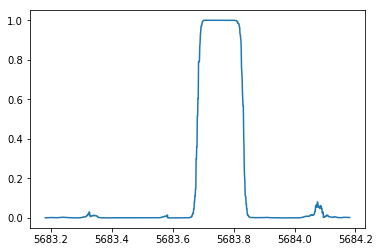

In [57]:
print(output2.call_times[500,])
i0 = 2083682

plt.plot(output2.times[(i0-500):(i0+500)],output2.scores[(i0-500):(i0+500)])

In [50]:
output2.times[2083682]

3600.0